<a href="https://colab.research.google.com/github/momenashra/Data_science/blob/main/Cyshield_Time_series_analysis_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data reading and preprocessing

## Reading data

In [ ]:
#loading libararies
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/CYSHIELD_TASK.csv")

In [ ]:
df.head()

quantity  UnitePrice  discount                  date  retail price  \
0        33        16.0      20.0  2021-10-29T03:33:52Z          16.0   
1        30        16.0      20.0  2021-10-23T12:29:27Z          16.0   
2         2        45.0      30.0  2021-08-03T09:14:16Z          45.0   
3         3        16.0       3.0  2021-08-17T09:00:50Z          16.0   
4         1        45.0      27.0  2021-09-06T19:57:02Z          45.0   

  product_name          area   city  
0    product y        Bahary  North  
1    product y  Dar El-Salam  Cairo  
2    product z         Miamy  North  
3    product y         Miamy  North  
4    product z         Miamy  North

## Edit data format , indexing and sorting

In [ ]:
#ensure the date column is in datetime64 format.
df['date'] = pd.to_datetime(df['date'])
#convert from the datetime64 object, leaving only the date for easier processing and readability .
df['date'] = df['date'].dt.date
# Sort the DataFrame by 'Date'
df = df.sort_values(by='date')
# Set 'Date' as the index
df.set_index('date', inplace=True)

# Exploratory Data Analysis

## Data overview

In [ ]:
df.head()

quantity  UnitePrice  discount  retail price product_name  \
date                                                                    
2021-03-31         5       102.0      33.0         102.0   product x    
2021-04-30         1        16.0       9.0          16.0    product y   
2021-05-08        10        16.0       9.0          16.0    product y   
2021-05-08        10        45.0      22.0          45.0    product z   
2021-05-22        10        16.0      20.0          16.0    product y   

                   area   city  
date                            
2021-03-31  El-Mokattam  Cairo  
2021-04-30    Ain Shams  Cairo  
2021-05-08   El-Zaitoun  Cairo  
2021-05-08   El-Zaitoun  Cairo  
2021-05-22        Bakos  North

In [ ]:
df.describe()

quantity   UnitePrice     discount  retail price
count  2995.000000  2995.000000  2995.000000   2995.000000
mean      7.705509    60.555426    25.917225     59.615776
std     100.466019    35.270286    14.124298     36.944778
min       1.000000    10.000000    -1.000000      0.000000
25%       2.000000    16.000000    20.000000     16.000000
50%       3.000000    45.000000    31.000000     45.000000
75%       5.000000    99.000000    33.000000     99.000000
max    5000.000000   102.000000   561.000000    102.000000


*   obviously there are outilers in data since max is far from
3rd quantile in quantity and discount .
*   discount here is percentage we must impute any row with discount > 100 or <0 .



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2995 entries, 2021-03-31 to 2023-01-17
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   quantity      2995 non-null   int64  
 1   UnitePrice    2995 non-null   float64
 2   discount      2995 non-null   float64
 3   retail price  2995 non-null   float64
 4   product_name  2995 non-null   object 
 5   area          2970 non-null   object 
 6   city          2995 non-null   object 
dtypes: float64(3), int64(1), object(3)
memory usage: 187.2+ KB


In [ ]:
area_frequency = df['area'].value_counts()
area_frequency
#not icluding nan

area
El-Agamy           301
El-Seyouf          300
Nasr City          272
Sidy Bishr         158
El-Sheikh Zayed    151
                  ... 
Helwan               1
Al Sulaimaniyah      1
Marsa Matrouh        1
Shibin El-Kom        1
Al-Khusus            1
Name: count, Length: 70, dtype: int64

* High cardanality .


## Data cleaning

In [ ]:
df.isnull().sum()  # Shows the count of missing values per column

quantity         0
UnitePrice       0
discount         0
retail price     0
product_name     0
area            25
city             0
dtype: int64

* I will Get realation between area and city (two categorical features) to check  .

In [ ]:
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(df['area'], df['city'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
p

0.0


*   intuitively area is not importatnt feature since it doesn't effect our forecasting for each city and highly correlated with city feature (p=0) .

In [ ]:
df.drop(columns=['area'], inplace=True)

In [ ]:
# Calculate the correlation between two specific features
feature_1 =  'UnitePrice'
feature_2 = 'retail price'
spearman_corr = df[feature_1].corr(df[feature_2], method='spearman')
#used spearman INSTEAD of pearson since data has outliers and skwed and distrbution is not normal
# Display the correlation
print(f"Correlation between {feature_1} and {feature_2}: {spearman_corr:.2f}")

Correlation between UnitePrice and retail price: 0.88



*   result suggests multicollinearity (correlationn ~ 0.9 ).
*   for further check i will check causality .



In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
max_lag = 5
df_diff = df[[feature_1, feature_2]].diff().dropna()

# Run Granger test on differenced data
gc_result = grangercausalitytests(df_diff, max_lag, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7293  , p=0.3932  , df_denom=2990, df_num=1
ssr based chi2 test:   chi2=0.7300  , p=0.3929  , df=1
likelihood ratio test: chi2=0.7299  , p=0.3929  , df=1
parameter F test:         F=0.7293  , p=0.3932  , df_denom=2990, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4087  , p=0.2446  , df_denom=2987, df_num=2
ssr based chi2 test:   chi2=2.8222  , p=0.2439  , df=2
likelihood ratio test: chi2=2.8209  , p=0.2440  , df=2
parameter F test:         F=1.4087  , p=0.2446  , df_denom=2987, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9875  , p=0.3976  , df_denom=2984, df_num=3
ssr based chi2 test:   chi2=2.9695  , p=0.3964  , df=3
likelihood ratio test: chi2=2.9680  , p=0.3966  , df=3
parameter F test:         F=0.9875  , p=0.3976  , df_denom=2984, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0308  , p=0.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


*   causality test must be performed in stationary data and it doesn't have strong causality (predictive realtionship) but we will keep both features espacially it may help with dynamic models (tree based).
*   Note : after removing retail_price feature model performance did't change significantly .


In [ ]:
df.drop(columns=['retail price'], inplace=True)

In [ ]:
#adding new feature total price to enhace relation between unit price and quantity
df['total_price'] = df['UnitePrice'] * df['quantity'] * (1 - df['discount']/100)


*   by using tree-based models, which handle feature interactions better, 'total_price' may  provide value. since tree-based models are less sensitive to multicollinearity and can benefit from the combined financial information in 'total_price'.




###Removing outliers using IQR technique

In [ ]:
columns_to_check = ['quantity', 'UnitePrice', 'discount']
df_filtered = df.copy()  # Copy the original DataFrame to keep it intact
def detect_outliers_iqr(column, tolerance=18):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - tolerance * IQR
    upper_bound = Q3 + tolerance * IQR
    return column[(column < lower_bound) | (column > upper_bound)]
#Dictionary to append outliers
outliers_dict = {}
# here i replaced standard 1.5 with bigger tolarance to preserve sufficient amout of data
# with 1.5 as the tolerance value our data was only around 750 rows and with 18 around 2250 .
for col in columns_to_check :
    outliers = detect_outliers_iqr(df[col])
    outliers_dict[col] = outliers.tolist()
    df_filtered = df_filtered[~df_filtered.index.isin(outliers.index)]



In [ ]:
outliers_dict

{'quantity': [100,
  1000,
  5000,
  2000,
  100,
  200,
  232,
  100,
  200,
  60,
  100,
  100,
  100,
  100,
  100,
  60],
 'UnitePrice': [],
 'discount': [561.0]}

In [ ]:
df.describe()

quantity   UnitePrice     discount   total_price
count  2995.000000  2995.000000  2995.000000   2995.000000
mean      7.705509    60.555426    25.917225    218.778564
std     100.466019    35.270286    14.124298   1602.933895
min       1.000000    10.000000    -1.000000  -2068.737500
25%       2.000000    16.000000    20.000000     62.825000
50%       3.000000    45.000000    31.000000     94.500000
75%       5.000000    99.000000    33.000000    183.600000
max    5000.000000   102.000000   561.000000  79200.000000

*  After removing outliers i observed more outliers which i didn't hanle using IQR since i have big tolarnce to keep sufficient amout of data so i have droped unfamiliar values using manual filters .


In [ ]:
#column to check for outliers
columns_to_check= ['UnitePrice','discount','total_price']
# Collect indices of rows to be dropped
rows_to_drop = []
# Iterate over each row using index and row content
for index, row in df_filtered[columns_to_check].iterrows():
    # Check if any value in the row is less than or equal to 0
     if (row[['UnitePrice','total_price']] <= 0).any() or row['discount'] < 0 :
        # Add the index to the list of rows to be dropped
        rows_to_drop.append(index)

# Drop all collected rows at once
df_filtered.drop(index=rows_to_drop, inplace=True)

In [ ]:
df_filtered.describe()

quantity   UnitePrice     discount  total_price
count  2801.000000  2801.000000  2801.000000  2801.000000
mean      4.457694    60.928329    25.729986   160.185021
std       6.043155    35.198251    10.113754   220.268168
min       1.000000    10.000000     0.000000    12.800000
25%       2.000000    16.000000    20.000000    62.400000
50%       3.000000    45.000000    31.000000    94.500000
75%       5.000000    99.000000    33.000000   183.090000
max      50.000000   102.000000    38.000000  3051.500000

In [ ]:
df_filtered.head()

quantity  UnitePrice  discount product_name   city  total_price
date                                                                       
2021-03-31         5       102.0      33.0   product x   Cairo       341.70
2021-04-30         1        16.0       9.0    product y  Cairo        14.56
2021-05-08        10        16.0       9.0    product y  Cairo       145.60
2021-05-08        10        45.0      22.0    product z  Cairo       351.00
2021-05-22        10        16.0      20.0    product y  North       128.00

<Axes: >

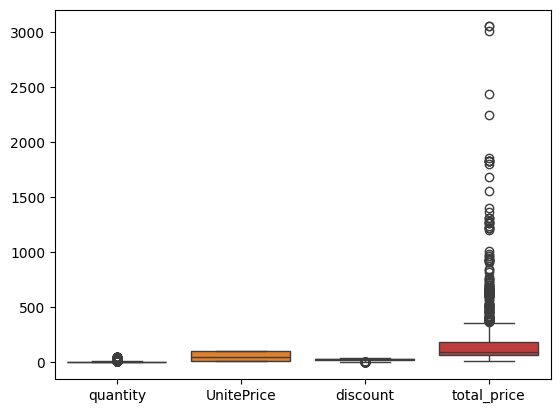

In [ ]:
sns.boxplot(data=df_filtered)

* some outliers i have choosen to keep to preserve sufficient amount of data .

##Univariate Analysis

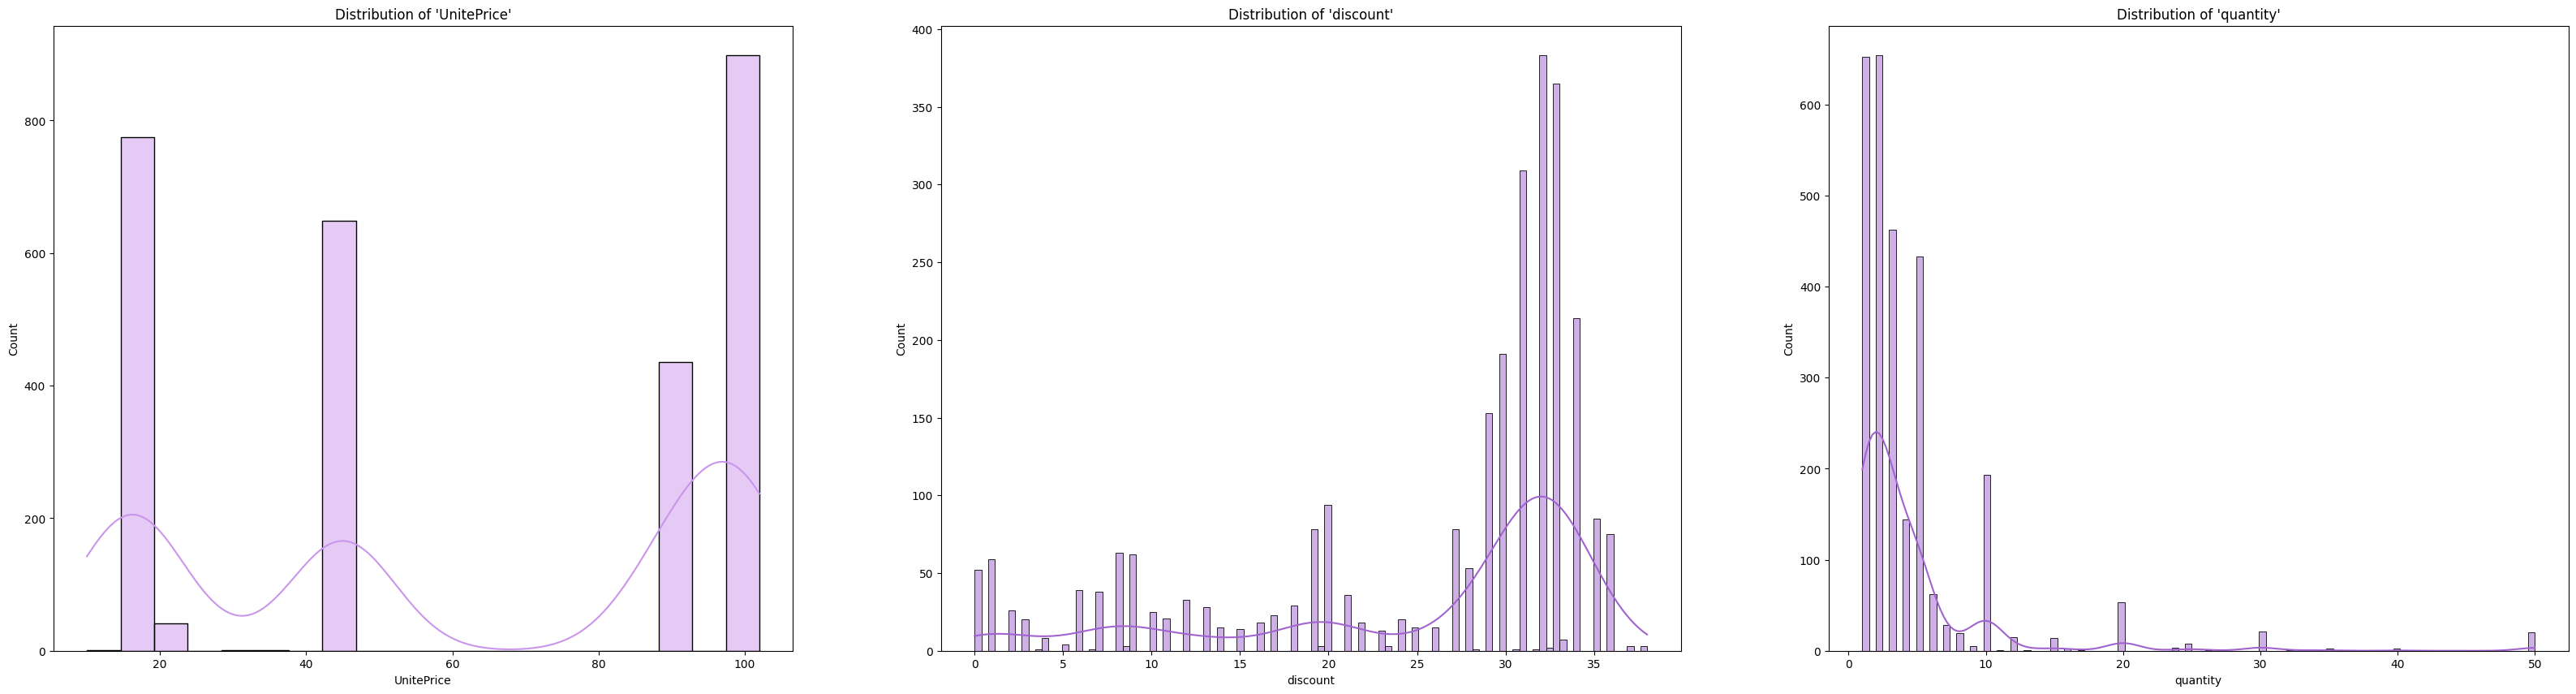

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (40, 10))

sns.histplot(ax = axes[0], x = df_filtered["UnitePrice"],
             bins = 20,
             kde = True,
             cbar = True,
             color = "#CA96EC").set(title = "Distribution of 'UnitePrice'");

sns.histplot(ax = axes[1], x = df_filtered["discount"],
             bins = 100,
             cbar = True,
             kde = True,
             color = "#A163CF").set(title = "Distribution of 'discount'");
# sns.histplot(ax = axes[2], x = df_filtered["retail price"],
#              bins = 20,
#              kde = True,
#              cbar = True,
#              color = "#CA96EC").set(title = "Distribution of 'retail price'");

sns.histplot(ax = axes[2], x = df_filtered["quantity"],
             bins = 100,
             cbar = True,
             kde = True,
             color = "#A163CF").set(title = "Distribution of 'quantity'");


* Features looks Non-Normally distributed (heavy tailed due to outliers) .

<Axes: xlabel='date', ylabel='quantity'>

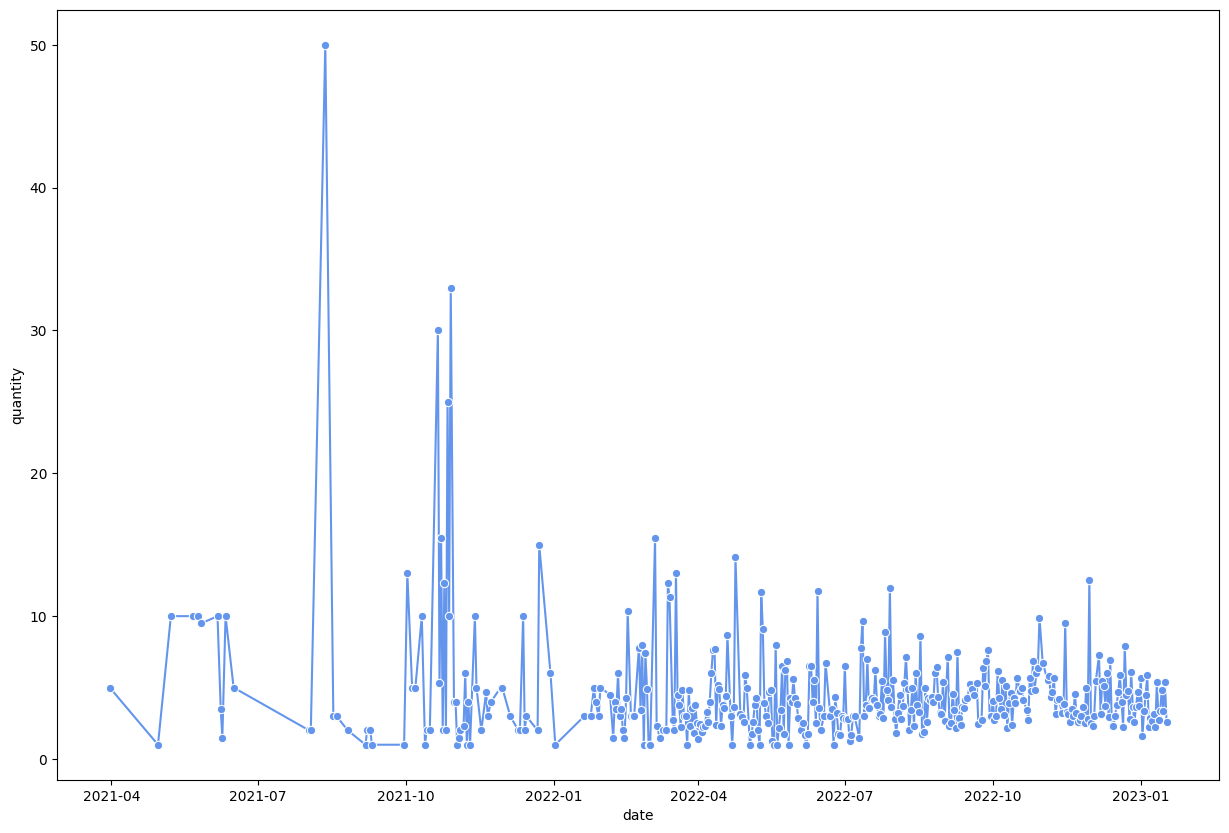

In [ ]:
### Visualize time series ###
fig, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(x=df_filtered.index, y=df_filtered["quantity"], color='cornflowerblue', marker='o',errorbar=None)


## Multivariate Analysis


In [ ]:
# Create a pivot table to see data more clearly and make some relation between categorical data
pivot_df = df_filtered.pivot_table(
    index='date',
    columns=['product_name','city'],
    values=['quantity', 'UnitePrice', 'discount','total_price'],
    aggfunc='sum',
    fill_value=0
)

for column in pivot_df.columns.get_level_values(0).unique():
    if column in ['quantity', 'discount']:
        pivot_df[column] = pivot_df[column].fillna(0)  # Assume no activity = 0
    elif column in ['UnitePrice']:
        pivot_df[column] = pivot_df[column].ffill()  # Forward fill stable prices
    elif column == 'total_price':
        pivot_df[column] = pivot_df[column].interpolate(method='linear')  # Smooth trends

pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]

# Reset the index
pivot_df.reset_index(inplace=True)


In [ ]:
pivot_df

date  UnitePrice_product x _Cairo  UnitePrice_product x _Giza  \
0    2021-03-31                        102.0                         0.0   
1    2021-04-30                          0.0                         0.0   
2    2021-05-08                          0.0                         0.0   
3    2021-05-22                          0.0                         0.0   
4    2021-05-25                          0.0                         0.0   
..          ...                          ...                         ...   
383  2023-01-13                          0.0                        99.0   
384  2023-01-14                        198.0                       297.0   
385  2023-01-15                         99.0                         0.0   
386  2023-01-16                          0.0                         0.0   
387  2023-01-17                          0.0                        99.0   

     UnitePrice_product x _North  UnitePrice_product y_Cairo  \
0                            0.0                         0.0   
1                            0.0                        16.0   
2                            0.0                        16.0   
3                            0.0                         0.0   
4                            0.0                         0.0   
..                           ...                         ...   
383                        198.0                         0.0   
384                        396.0                         0.0   
385                        396.0                        22.0   
386                        594.0                         0.0   
387                        396.0                         0.0   

     UnitePrice_product y_Giza  UnitePrice_product y_North  \
0                          0.0                         0.0   
1                          0.0                         0.0   
2                          0.0                         0.0   
3                          0.0                        16.0   
4                          0.0                        16.0   
..                         ...                         ...   
383                        0.0                         0.0   
384                       38.0                        90.0   
385                       38.0                         0.0   
386                        0.0                        22.0   
387                        0.0                         0.0   

     UnitePrice_product z_Cairo  UnitePrice_product z_Giza  \
0                           0.0                        0.0   
1                           0.0                        0.0   
2                          45.0                        0.0   
3                           0.0                        0.0   
4                           0.0                        0.0   
..                          ...                        ...   
383                         0.0                        0.0   
384                         0.0                       45.0   
385                        45.0                       90.0   
386                        45.0                        0.0   
387                         0.0                        0.0   

     UnitePrice_product z_North  ...  quantity_product z_North  \
0                           0.0  ...                         0   
1                           0.0  ...                         0   
2                           0.0  ...                         0   
3                           0.0  ...                         0   
4                           0.0  ...                         0   
..                          ...  ...                       ...   
383                         0.0  ...                         0   
384                        45.0  ...                         1   
385                         0.0  ...                         0   
386                       135.0  ...                        11   
387                         0.0  ...                         0   

     total_price_product x _Cairo  total_price

* Sparsity in data will make model lazy to learn .

### Correlation map


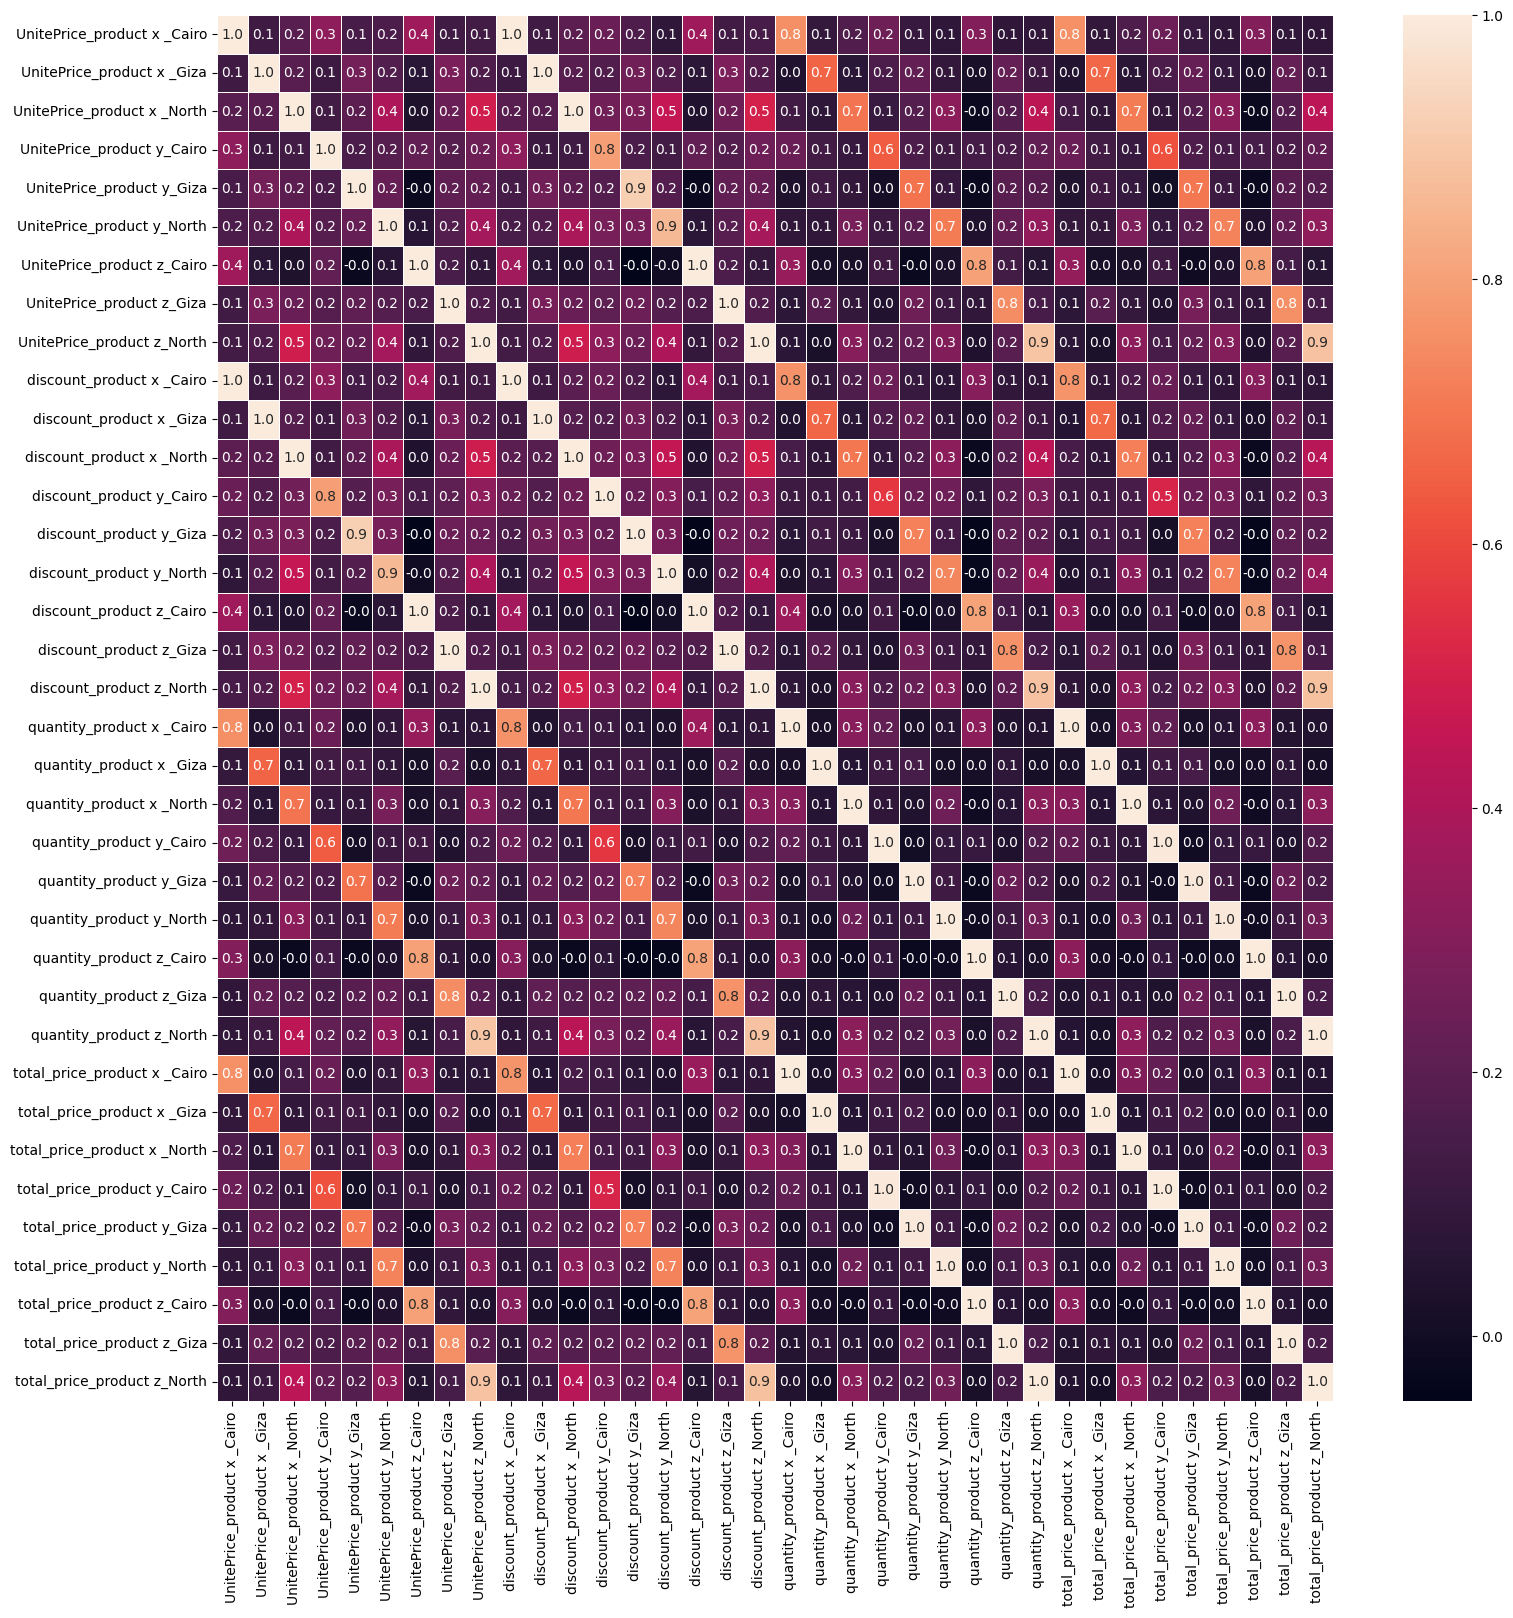

In [ ]:
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(pivot_df.drop(columns=['date']).corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

### Pair plot

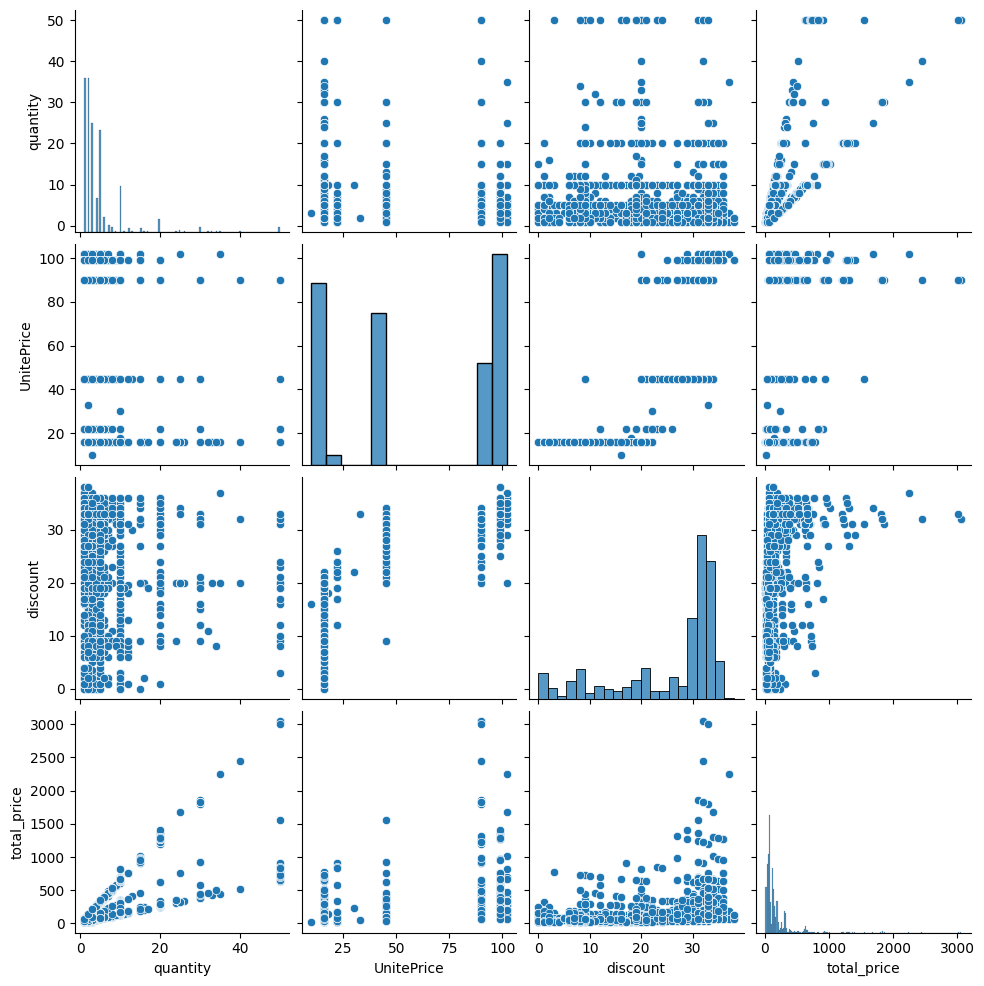

In [ ]:
sns.pairplot(df_filtered)



* Features relations doesn't have a clear pattern .

### lineplot

In [ ]:
# Select output columns from pivot DataFrame
out_cols=['quantity_product x _Cairo', 'quantity_product x _Giza',
          'quantity_product x _North', 'quantity_product y_Cairo',
          'quantity_product y_Giza'  , 'quantity_product y_North',
          'quantity_product z_Cairo' , 'quantity_product z_Giza',
          'quantity_product z_North']

In [ ]:
#strip white spaces in columns names
pivot_df.iloc[:, 1:] = pivot_df.iloc[:, 1:].apply(lambda x: x.str.strip() if x.dtype == 'object' else x)

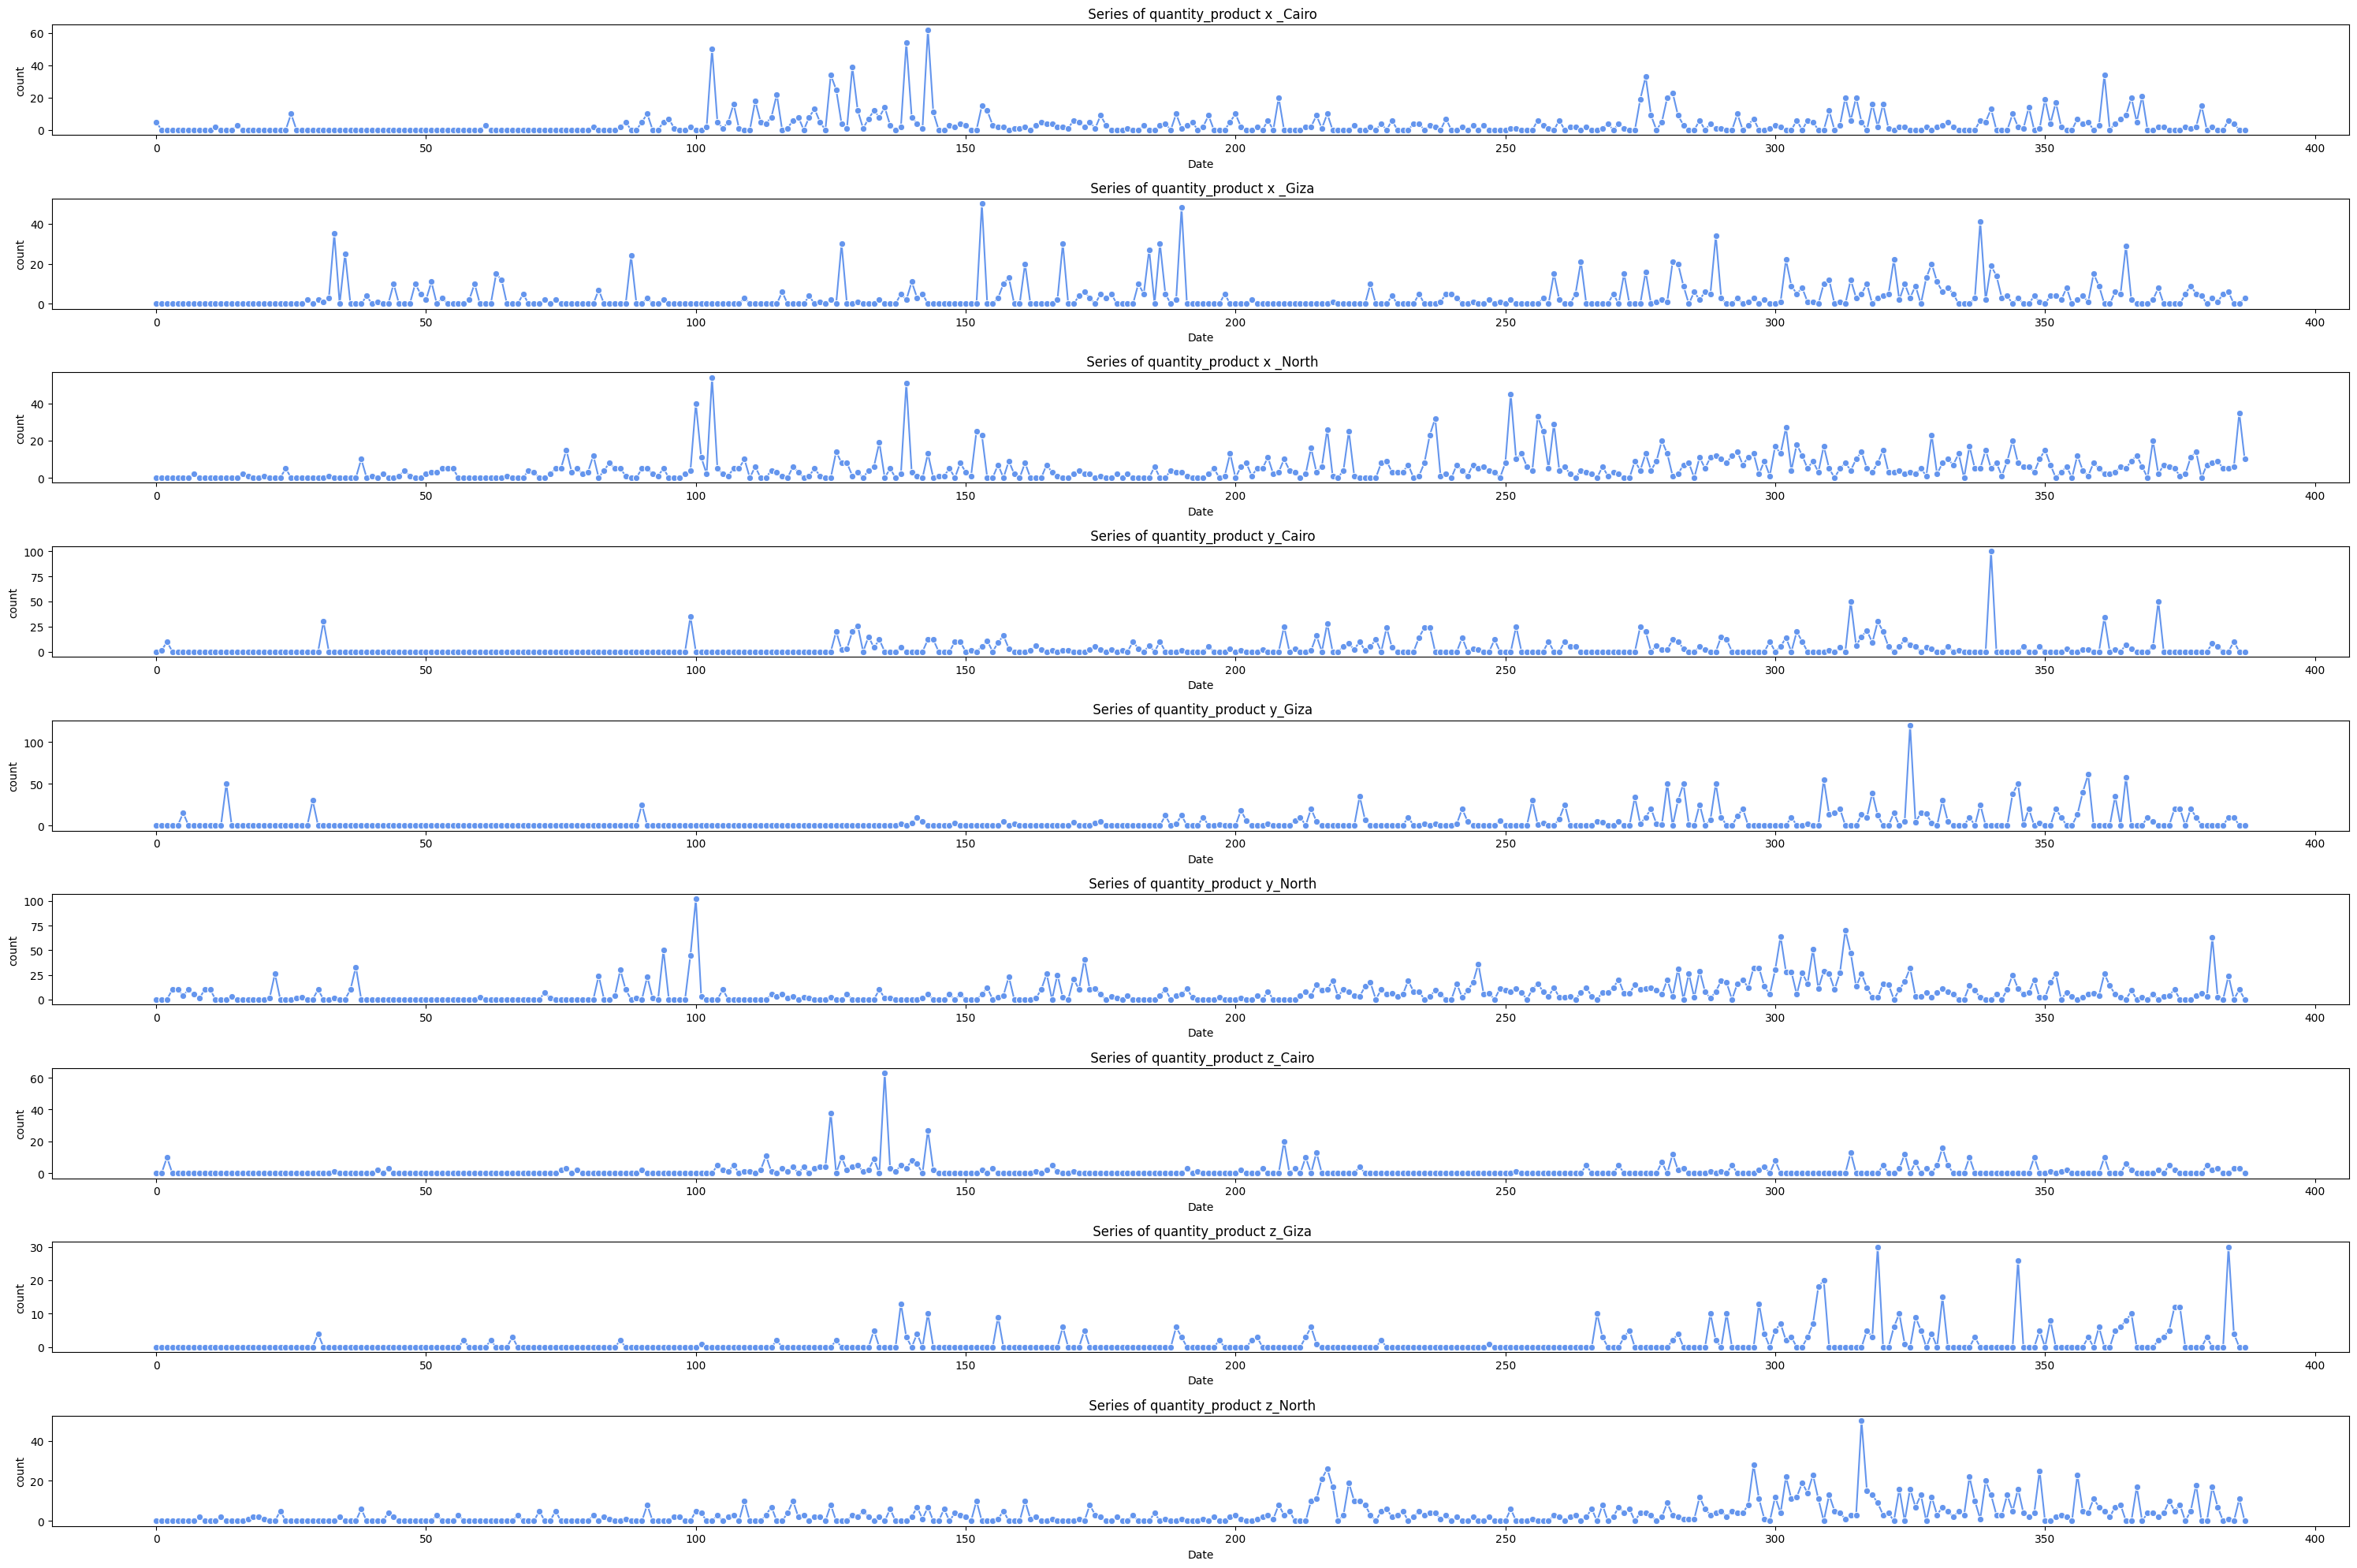

In [ ]:
# Create a figure with as many subplots as the number of out_cols
fig, ax = plt.subplots(nrows=len(out_cols), ncols=1, figsize=(30, 20))
# Loop over your target columns (out_cols) and create one plot for each
for i in range(len(out_cols)):
    sns.lineplot(x=pivot_df.index, y=pivot_df[out_cols[i]], ax=ax[i], color='cornflowerblue', marker='o')
    ax[i].set_title(f" Series of {out_cols[i]}")
    ax[i].set_xlabel('Date')
    ax[i].set_ylabel("count")

# Adjust layout to ensure plots are spaced properly
plt.tight_layout()

# Display the plot
plt.show()



**Observations :**
*   Product X is the most popular .
*   Seasonality and cycle isn't clear .
*   Data has spikes (high sales) .



## Time Series Analysis

In [ ]:
# import libararies for Time series forecasting
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import RobustScaler


### Data resampling

* As data isn't uniformaly spaced so we should resample it as a daily frequency to check for stationarity , seasonality and trend patterns .
* I will resample data at daily frequency since i will predict 10 days in advance.

In [ ]:
pivot_df_resampled=pivot_df.copy()
pivot_df_resampled['date'] = pd.to_datetime(pivot_df_resampled['date'])
pivot_df_resampled.set_index('date', inplace=True)

# Resample to daily frequency
pivot_df_resampled = pivot_df_resampled.resample('D').mean()

# # Handle missing values by interpolation
pivot_df_resampled.interpolate(method='linear', inplace=True)
# # i have tried second degree interpolation and make bad results and time does not change results .

In [ ]:
pivot_df_resampled

UnitePrice_product x _Cairo  UnitePrice_product x _Giza  \
date                                                                  
2021-03-31                        102.0                         0.0   
2021-04-01                         98.6                         0.0   
2021-04-02                         95.2                         0.0   
2021-04-03                         91.8                         0.0   
2021-04-04                         88.4                         0.0   
...                                 ...                         ...   
2023-01-13                          0.0                        99.0   
2023-01-14                        198.0                       297.0   
2023-01-15                         99.0                         0.0   
2023-01-16                          0.0                         0.0   
2023-01-17                          0.0                        99.0   

            UnitePrice_product x _North  UnitePrice_product y_Cairo  \
date                                                                  
2021-03-31                          0.0                    0.000000   
2021-04-01                          0.0                    0.533333   
2021-04-02                          0.0                    1.066667   
2021-04-03                          0.0                    1.600000   
2021-04-04                          0.0                    2.133333   
...                                 ...                         ...   
2023-01-13                        198.0                    0.000000   
2023-01-14                        396.0                    0.000000   
2023-01-15                        396.0                   22.000000   
2023-01-16                        594.0                    0.000000   
2023-01-17                        396.0                    0.000000   

            UnitePrice_product y_Giza  UnitePrice_product y_North  \
date                                                                
2021-03-31                        0.0                         0.0   
2021-04-01                        0.0                         0.0   
2021-04-02                        0.0                         0.0   
2021-04-03                        0.0                         0.0   
2021-04-04                        0.0                         0.0   
...                               ...                         ...   
2023-01-13                        0.0                         0.0   
2023-01-14                       38.0                        90.0   
2023-01-15                       38.0                         0.0   
2023-01-16                        0.0                        22.0   
2023-01-17                        0.0                         0.0   

            UnitePrice_product z_Cairo  UnitePrice_product z_Giza  \
date                                                                
2021-03-31                         0.0                        0.0   
2021-04-01                         0.0                        0.0   
2021-04-02                         0.0                        0.0   
2021-04-03                         0.0                        0.0   
2021-04-04                         0.0                        0.0   
...                                ...                        ...   
2023-01-13                         0.0                        0.0   
2023-01-14                         0.0                       45.0   
2023-01-15                        45.0                       90.0   
2023-01-16                        45.0                        0.0   
2023-01-17                         0.0                        0.0   

            UnitePrice_product z_North  discount_product x _Cairo  ...  \
date                                                               ...   
2021-03-31                         0.0                       33.0  ...   
2021-04-01                         0.0                       31.9  ...   
2021-04-02                         0.0                       30.8  ...  

* After resampling i observed more outliers .

In [ ]:
pivot_df_resampled.describe()

UnitePrice_product x _Cairo  UnitePrice_product x _Giza  \
count                   658.000000                  658.000000   
mean                     61.477204                   46.969985   
std                      94.716045                   93.805323   
min                       0.000000                    0.000000   
25%                       0.000000                    0.000000   
50%                       0.000000                    0.000000   
75%                      90.799202                   89.750000   
max                     718.000000                  792.000000   

       UnitePrice_product x _North  UnitePrice_product y_Cairo  \
count                   658.000000                  658.000000   
mean                    123.690350                    5.231003   
std                     175.300195                   10.823416   
min                       0.000000                    0.000000   
25%                       0.000000                    0.000000   
50%                      73.261905                    0.000000   
75%                     179.500000                    5.828571   
max                     990.000000                   80.000000   

       UnitePrice_product y_Giza  UnitePrice_product y_North  \
count                 658.000000                  658.000000   
mean                    4.548632                   15.623100   
std                    11.755566                   21.614552   
min                     0.000000                    0.000000   
25%                     0.000000                    0.000000   
50%                     0.000000                    8.000000   
75%                     0.000000                   22.000000   
max                   118.000000                  112.000000   

       UnitePrice_product z_Cairo  UnitePrice_product z_Giza  \
count                  658.000000                 658.000000   
mean                    11.129179                   7.898936   
std                     28.888763                  20.253168   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                    270.000000                 180.000000   

       UnitePrice_product z_North  discount_product x _Cairo  ...  \
count                  658.000000                 658.000000  ...   
mean                    33.168693                  20.908875  ...   
std                     55.383129                  32.928195  ...   
min                      0.000000                   0.000000  ...   
25%                      0.000000                   0.000000  ...   
50%                      0.000000                   0.000000  ...   
75%                     45.000000                  32.000000  ...   
max                    315.000000                 256.000000  ...   

       quantity_product z_North  total_price_product x _Cairo  \
count                658.000000                    658.000000   
mean                   2.223404                    166.871505   
std                    4.610044                    383.721525   
min                    0.000000                      0.000000   
25%                    0.000000                      0.000000   
50%                    0.000000                      0.000000   
75%                    2.400000                    172.543929   
max                   50.000000                   3783.860000   

       total_price_product x _Giza  total_price_product x _North  \
count                   658.000000                    658.000000   
mean                    151.549354                    228.795519   
std                     375.158397                    411.450273   
min                       0.000000                      0.000000   
25%                       0.000000                      0.000000   
50%                       0.000000             

#### Removing outliers using IsolationForest

In [ ]:
pivot_df_resampled_filtered=pivot_df_resampled.copy()
from sklearn.ensemble import IsolationForest
model = IsolationForest(contamination=0.5)
outliers = model.fit_predict(pivot_df_resampled)
mask = outliers != -1
pivot_df_resampled_filtered = pivot_df_resampled[mask]

pivot_df_resampled_filtered.describe()

UnitePrice_product x _Cairo  UnitePrice_product x _Giza  \
count                   329.000000                  329.000000   
mean                     20.049302                   12.143027   
std                      34.164224                   31.302640   
min                       0.000000                    0.000000   
25%                       0.000000                    0.000000   
50%                       0.000000                    0.000000   
75%                      32.553191                    0.000000   
max                     179.500000                  136.000000   

       UnitePrice_product x _North  UnitePrice_product y_Cairo  \
count                   329.000000                  329.000000   
mean                     36.631586                    1.021277   
std                      54.345338                    3.337564   
min                       0.000000                    0.000000   
25%                       0.000000                    0.000000   
50%                       0.000000                    0.000000   
75%                      85.000000                    0.000000   
max                     297.000000                   16.000000   

       UnitePrice_product y_Giza  UnitePrice_product y_North  \
count                 329.000000                  329.000000   
mean                    0.641945                    6.447011   
std                     2.614857                    9.147850   
min                     0.000000                    0.000000   
25%                     0.000000                    0.000000   
50%                     0.000000                    0.000000   
75%                     0.000000                   14.857143   
max                    16.000000                   32.000000   

       UnitePrice_product z_Cairo  UnitePrice_product z_Giza  \
count                  329.000000                 329.000000   
mean                     0.957447                   2.078810   
std                      6.190970                   7.500625   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                     45.000000                  45.000000   

       UnitePrice_product z_North  discount_product x _Cairo  ...  \
count                  329.000000                 329.000000  ...   
mean                     9.118541                   6.506441  ...   
std                     16.118020                  11.260928  ...   
min                      0.000000                   0.000000  ...   
25%                      0.000000                   0.000000  ...   
50%                      0.000000                   0.000000  ...   
75%                     13.500000                  10.000000  ...   
max                     60.000000                  64.000000  ...   

       quantity_product z_North  total_price_product x _Cairo  \
count                329.000000                    329.000000   
mean                   0.447822                     42.258283   
std                    0.935164                     83.302110   
min                    0.000000                      0.000000   
25%                    0.000000                      0.000000   
50%                    0.000000                      0.000000   
75%                    0.450000                     58.577143   
max                    5.000000                    612.000000   

       total_price_product x _Giza  total_price_product x _North  \
count                   329.000000                    329.000000   
mean                     41.188455                     57.143679   
std                     137.209459                    107.147199   
min                       0.000000                      0.000000   
25%                       0.000000                      0.000000   
50%                       0.000000             

* This time I choosed to try isolation forest since data is multivariant and nonlinear.

In [ ]:
pivot_df_resampled_filtered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 329 entries, 2021-03-31 to 2023-01-13
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   UnitePrice_product x _Cairo   329 non-null    float64
 1   UnitePrice_product x _Giza    329 non-null    float64
 2   UnitePrice_product x _North   329 non-null    float64
 3   UnitePrice_product y_Cairo    329 non-null    float64
 4   UnitePrice_product y_Giza     329 non-null    float64
 5   UnitePrice_product y_North    329 non-null    float64
 6   UnitePrice_product z_Cairo    329 non-null    float64
 7   UnitePrice_product z_Giza     329 non-null    float64
 8   UnitePrice_product z_North    329 non-null    float64
 9   discount_product x _Cairo     329 non-null    float64
 10  discount_product x _Giza      329 non-null    float64
 11  discount_product x _North     329 non-null    float64
 12  discount_product y_Cairo      329 non-null   

In [ ]:
pivot_df_resampled

UnitePrice_product x _Cairo  UnitePrice_product x _Giza  \
date                                                                  
2021-03-31                        102.0                         0.0   
2021-04-01                         98.6                         0.0   
2021-04-02                         95.2                         0.0   
2021-04-03                         91.8                         0.0   
2021-04-04                         88.4                         0.0   
...                                 ...                         ...   
2023-01-13                          0.0                        99.0   
2023-01-14                        198.0                       297.0   
2023-01-15                         99.0                         0.0   
2023-01-16                          0.0                         0.0   
2023-01-17                          0.0                        99.0   

            UnitePrice_product x _North  UnitePrice_product y_Cairo  \
date                                                                  
2021-03-31                          0.0                    0.000000   
2021-04-01                          0.0                    0.533333   
2021-04-02                          0.0                    1.066667   
2021-04-03                          0.0                    1.600000   
2021-04-04                          0.0                    2.133333   
...                                 ...                         ...   
2023-01-13                        198.0                    0.000000   
2023-01-14                        396.0                    0.000000   
2023-01-15                        396.0                   22.000000   
2023-01-16                        594.0                    0.000000   
2023-01-17                        396.0                    0.000000   

            UnitePrice_product y_Giza  UnitePrice_product y_North  \
date                                                                
2021-03-31                        0.0                         0.0   
2021-04-01                        0.0                         0.0   
2021-04-02                        0.0                         0.0   
2021-04-03                        0.0                         0.0   
2021-04-04                        0.0                         0.0   
...                               ...                         ...   
2023-01-13                        0.0                         0.0   
2023-01-14                       38.0                        90.0   
2023-01-15                       38.0                         0.0   
2023-01-16                        0.0                        22.0   
2023-01-17                        0.0                         0.0   

            UnitePrice_product z_Cairo  UnitePrice_product z_Giza  \
date                                                                
2021-03-31                         0.0                        0.0   
2021-04-01                         0.0                        0.0   
2021-04-02                         0.0                        0.0   
2021-04-03                         0.0                        0.0   
2021-04-04                         0.0                        0.0   
...                                ...                        ...   
2023-01-13                         0.0                        0.0   
2023-01-14                         0.0                       45.0   
2023-01-15                        45.0                       90.0   
2023-01-16                        45.0                        0.0   
2023-01-17                         0.0                        0.0   

            UnitePrice_product z_North  discount_product x _Cairo  ...  \
date                                                               ...   
2021-03-31                         0.0                       33.0  ...   
2021-04-01                         0.0                       31.9  ...   
2021-04-02                         0.0                       30.8  ...  

<Axes: >

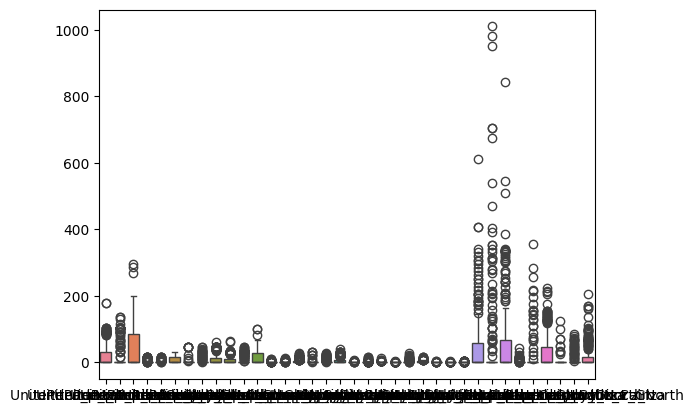

In [ ]:
sns.boxplot(data=pivot_df_resampled_filtered)

* Again i preferd preserving data over removing all outliers .

### Stationarity check

* First we will check for stationarity using Augmented Dicky fuller test .

In [ ]:
def test_stationarity(series):
    result = adfuller(series)
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("Series is stationary")
    else:
        print("Series is not stationary")

# Test for stationarity on each column (assuming each column is a time series)
for column in pivot_df[out_cols]:
    print(f"Testing stationarity for {column}")
    test_stationarity(pivot_df_resampled_filtered[column])


Testing stationarity for quantity_product x _Cairo
p-value: 0.00011578766829360261
Series is stationary
Testing stationarity for quantity_product x _Giza
p-value: 0.008919878249595163
Series is stationary
Testing stationarity for quantity_product x _North
p-value: 0.2326249791902173
Series is not stationary
Testing stationarity for quantity_product y_Cairo
p-value: 0.004490425343573078
Series is stationary
Testing stationarity for quantity_product y_Giza
p-value: 1.4822671845653746e-05
Series is stationary
Testing stationarity for quantity_product y_North
p-value: 0.14385850807343903
Series is not stationary
Testing stationarity for quantity_product z_Cairo
p-value: 2.534455463014628e-16
Series is stationary
Testing stationarity for quantity_product z_Giza
p-value: 0.012788057830490886
Series is stationary
Testing stationarity for quantity_product z_North
p-value: 0.0022454190540922843
Series is stationary


* Data was found to be non-stationary thereby we will need further maniuplation .

### Seasonality , trend and residuals

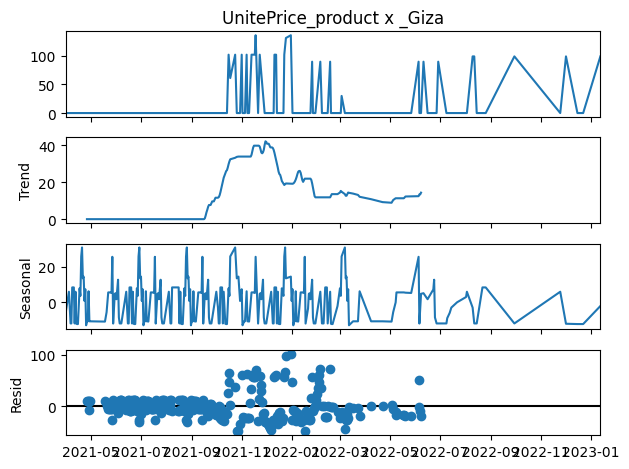

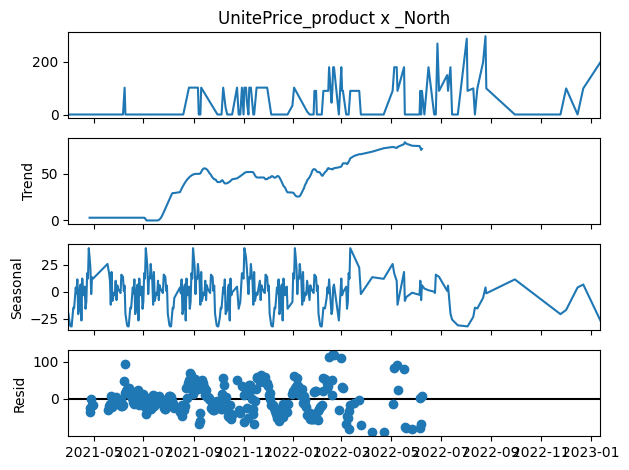

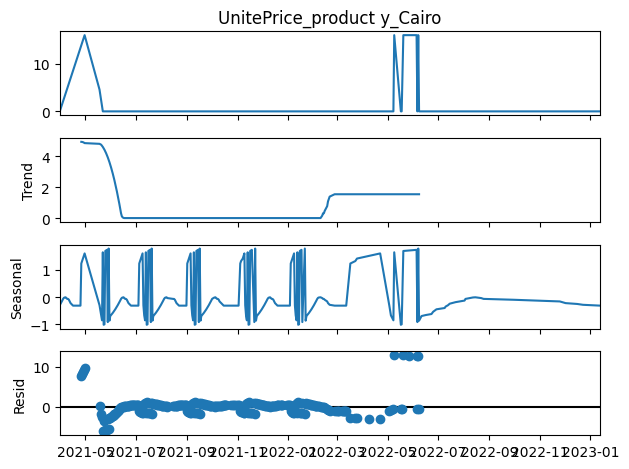

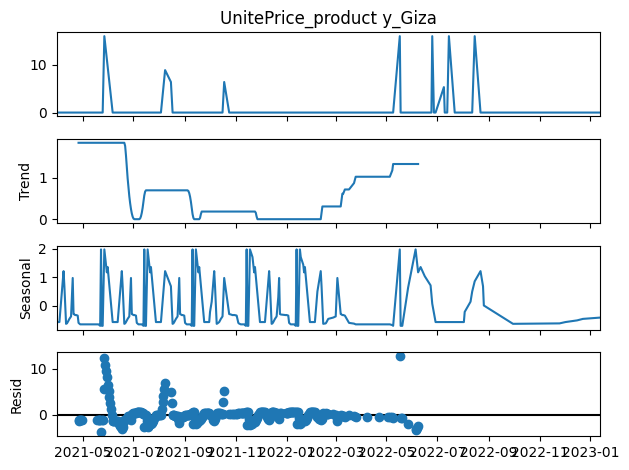

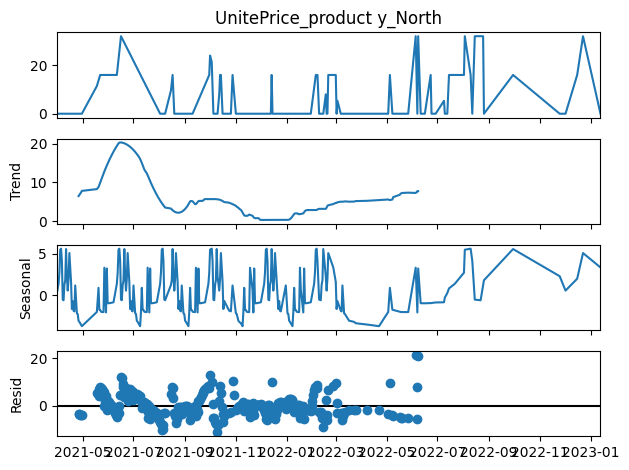

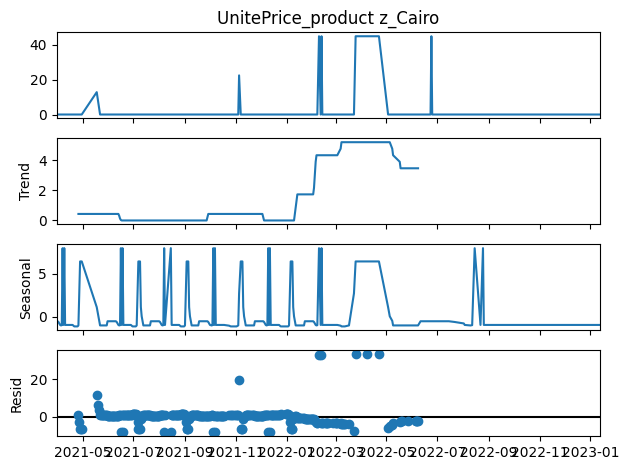

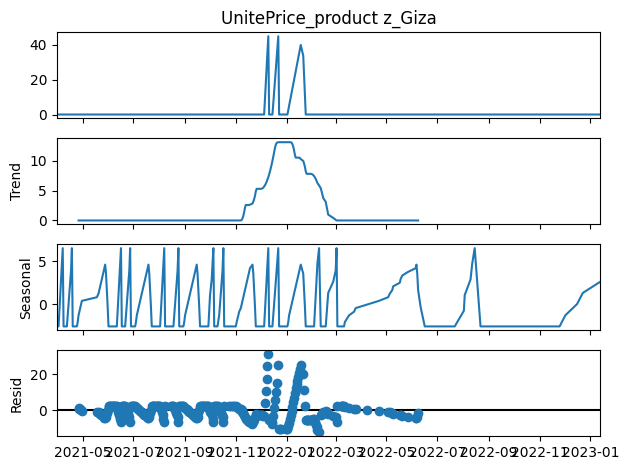

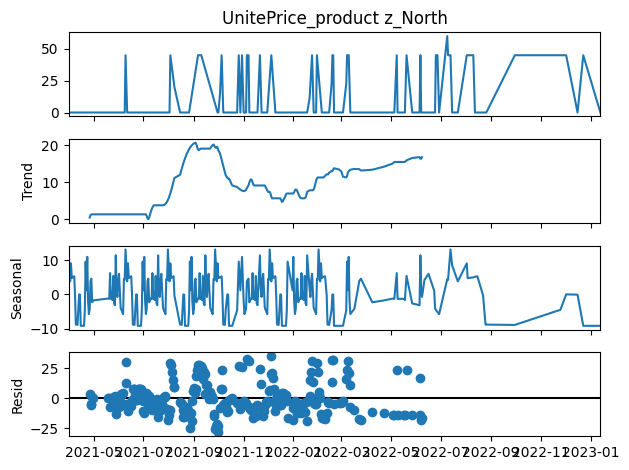

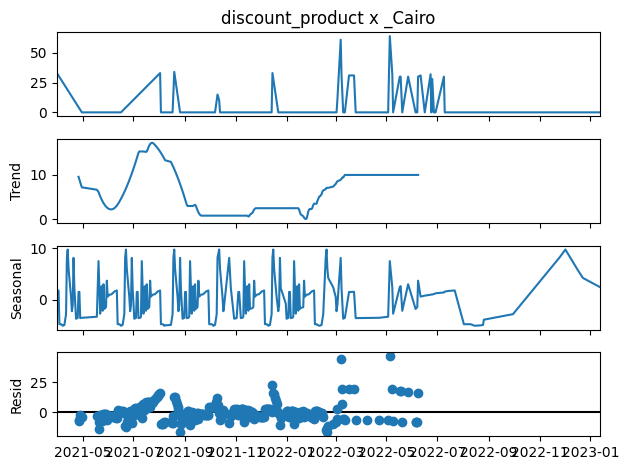

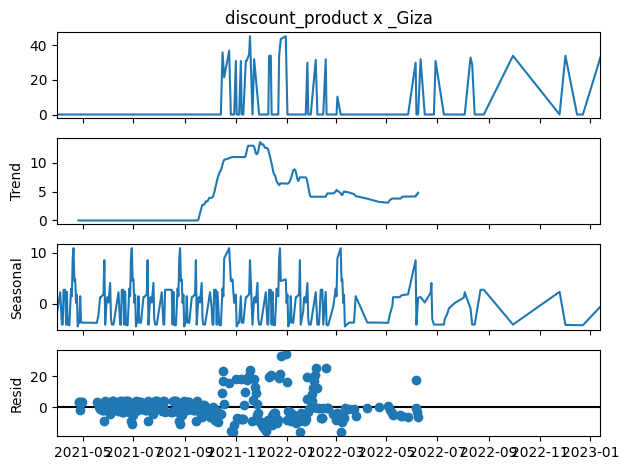

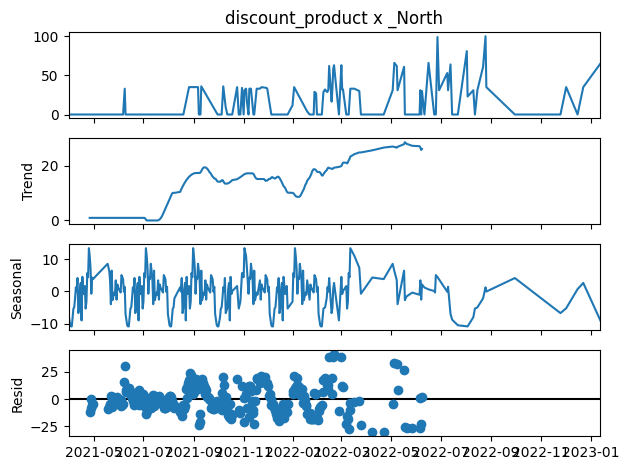

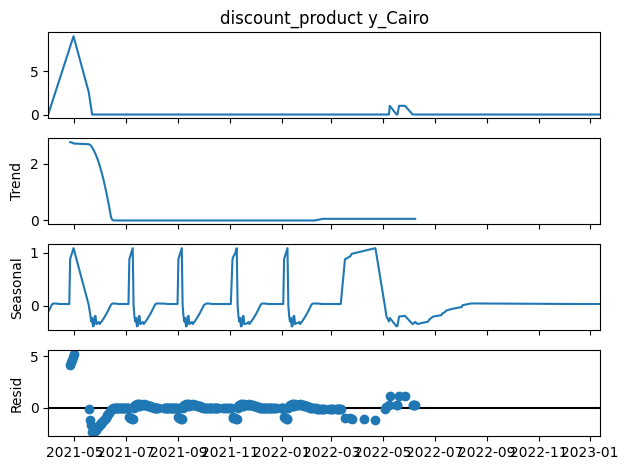

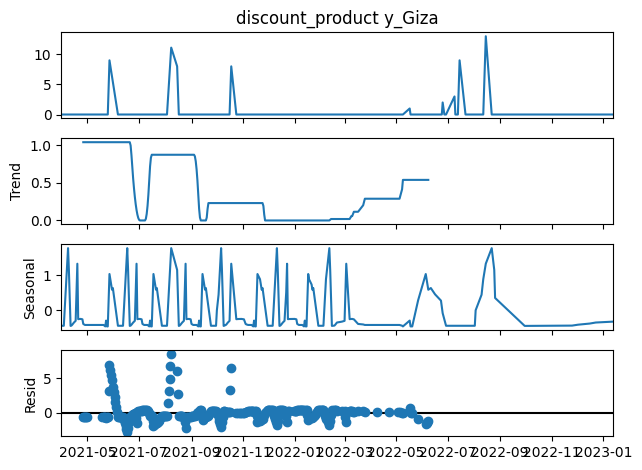

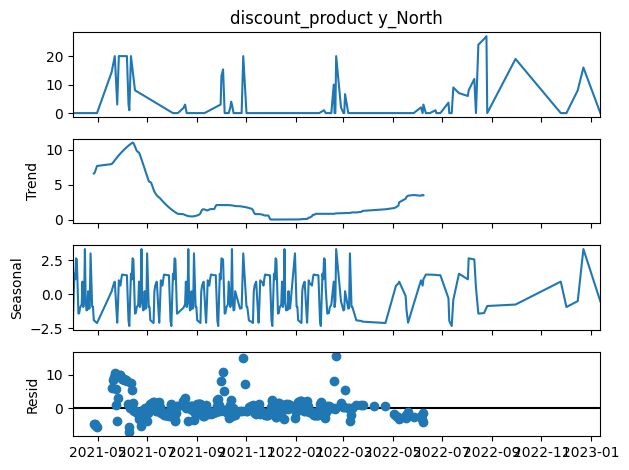

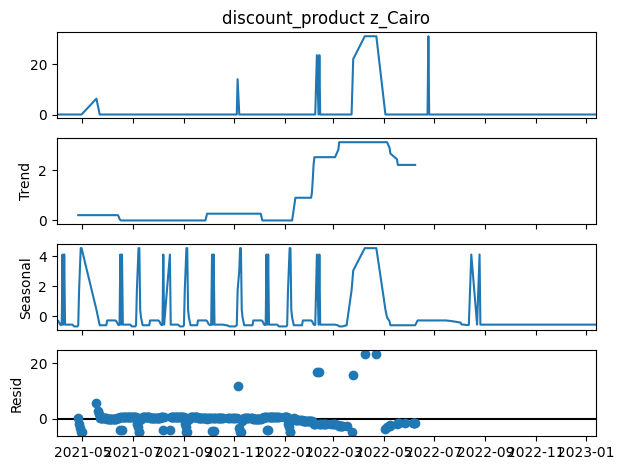

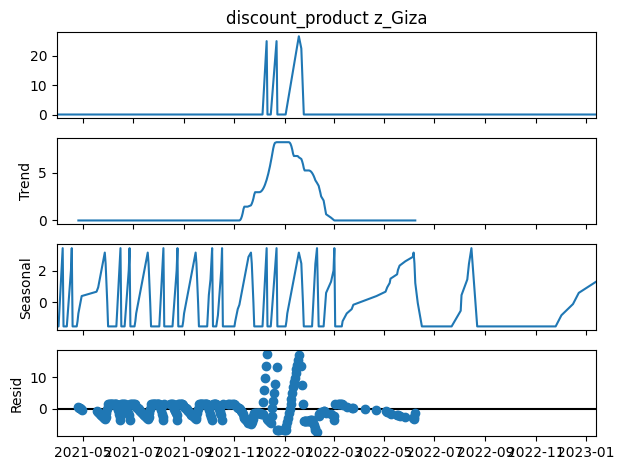

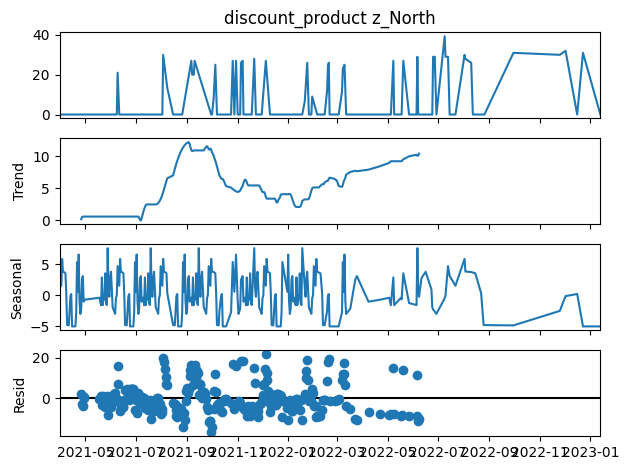

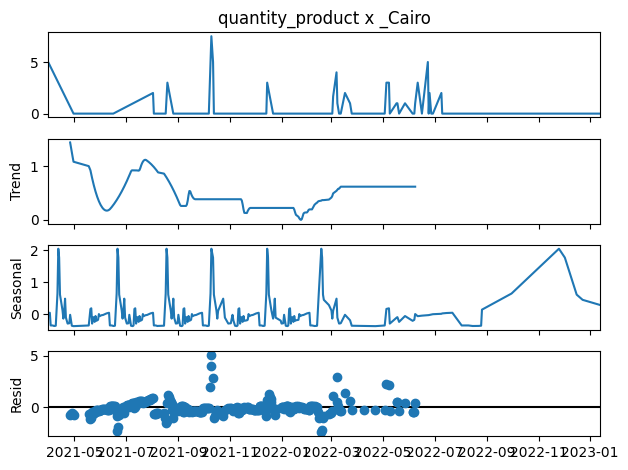

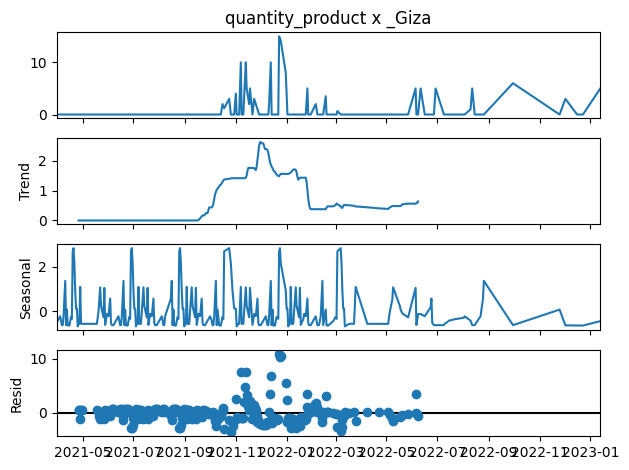

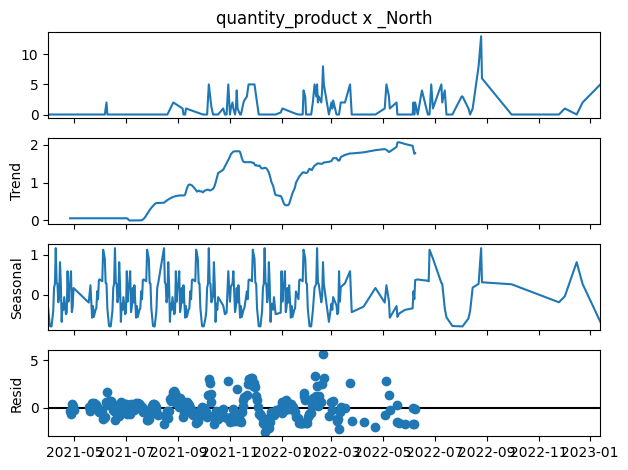

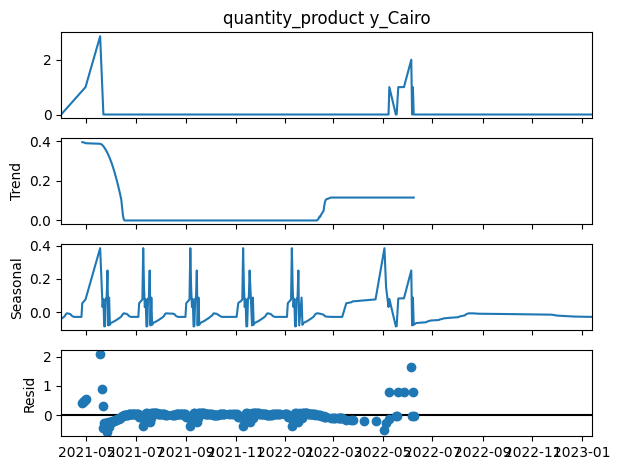

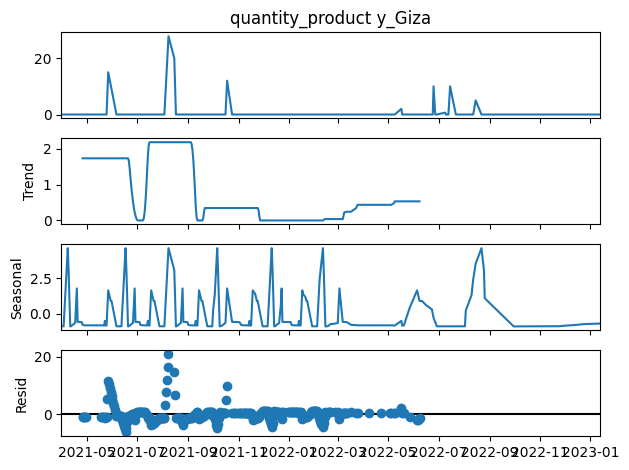

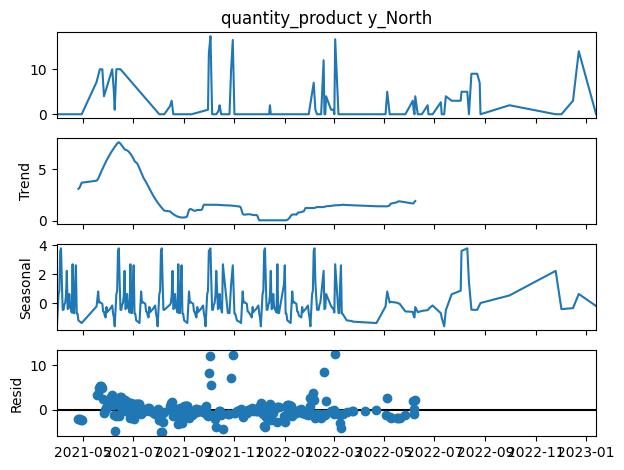

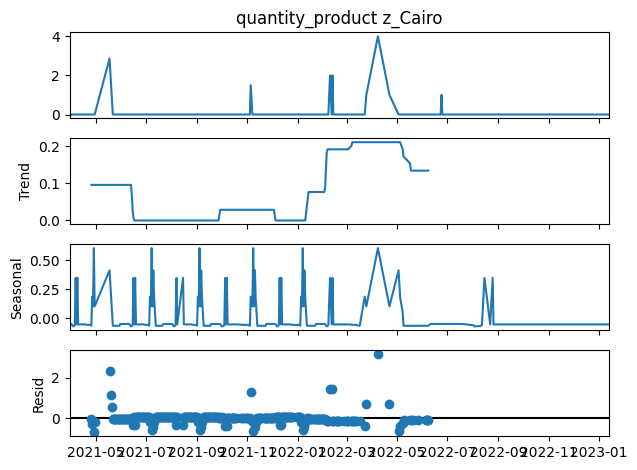

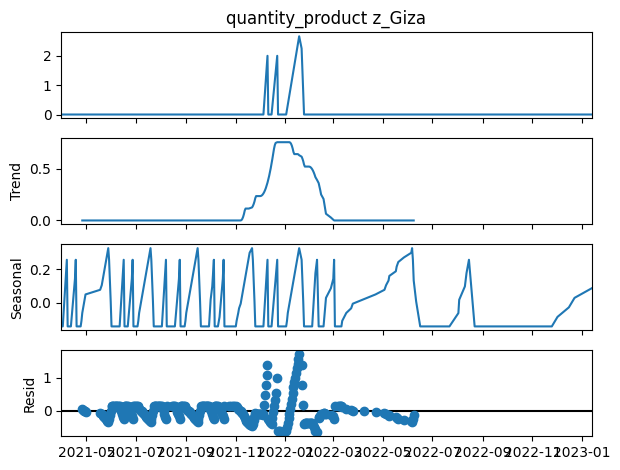

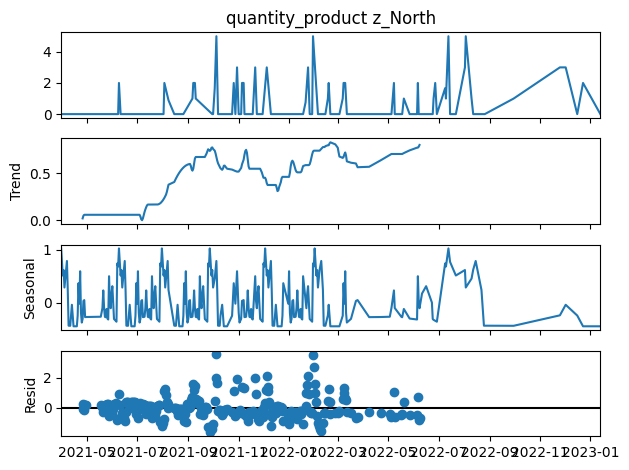

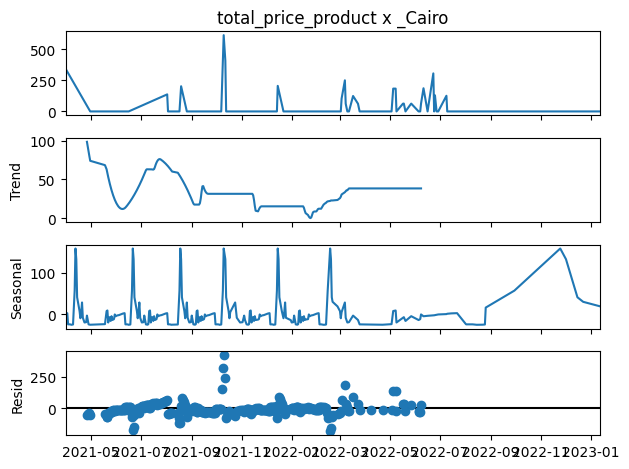

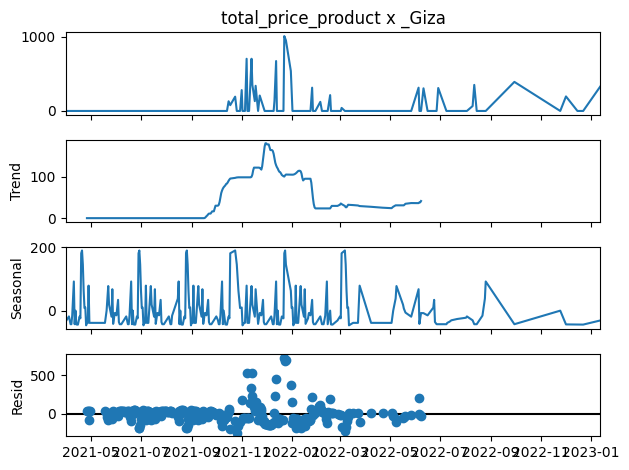

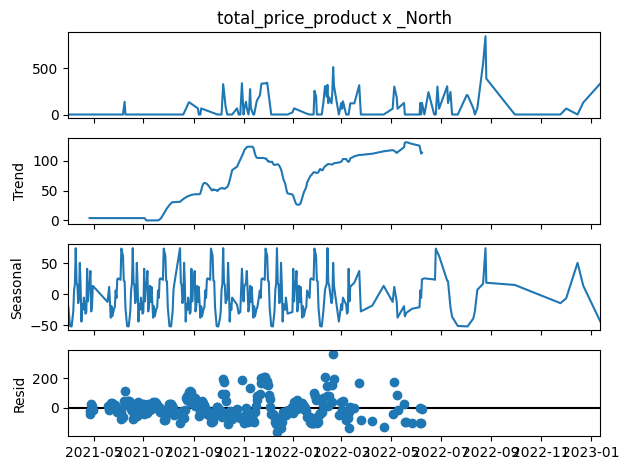

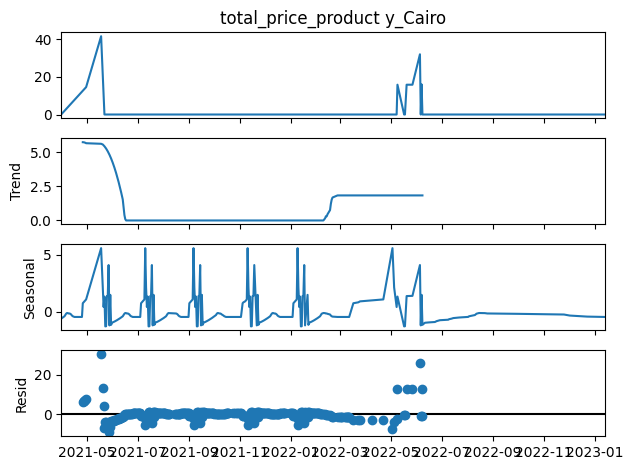

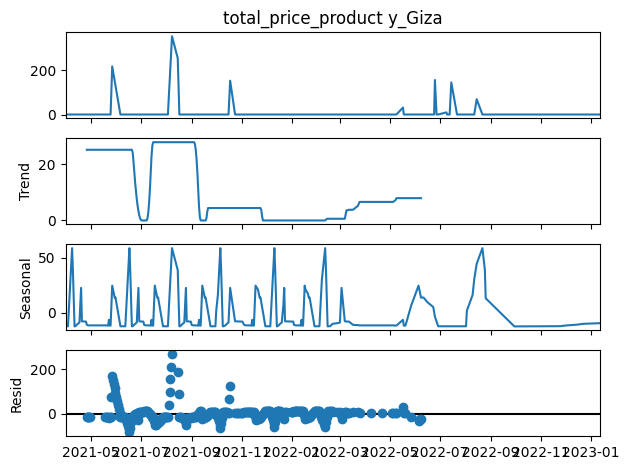

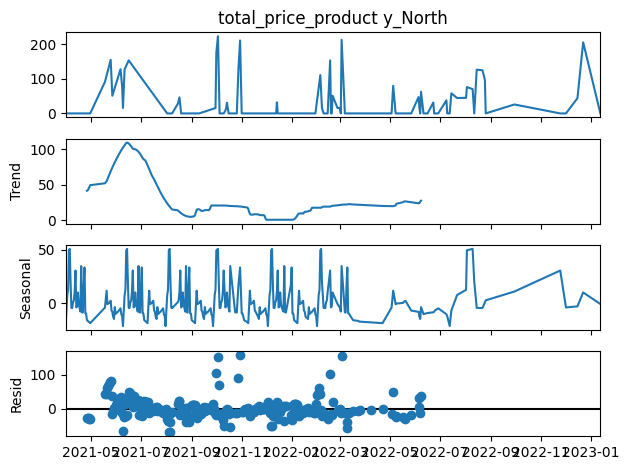

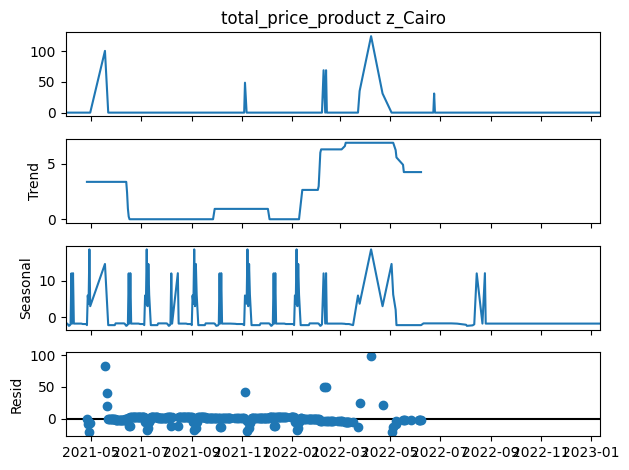

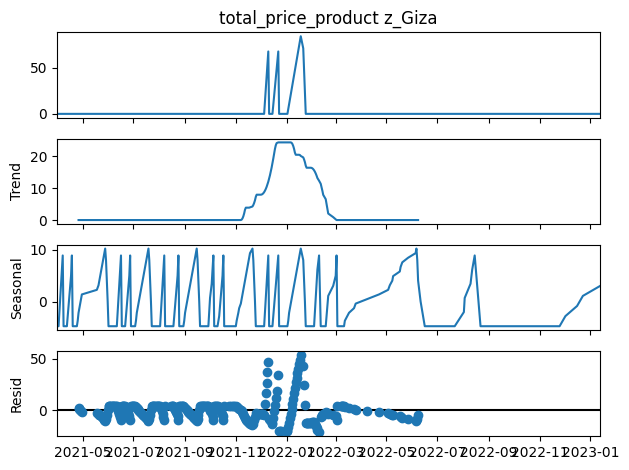

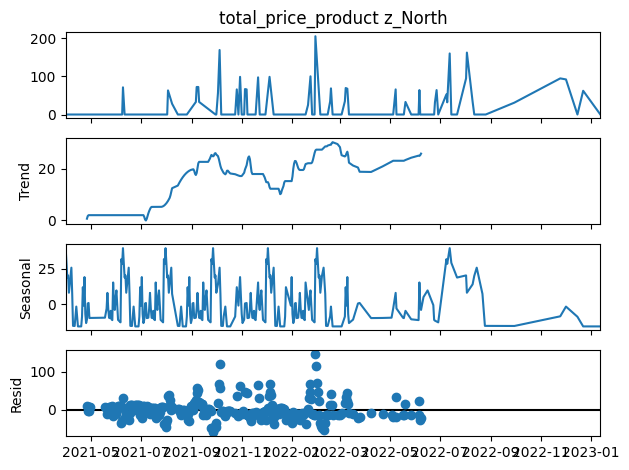

In [ ]:
# I will use additive approch where yt= seasonal component + trend + residuals
def decompose_time_series(series):
  # i will check for weekly seasonal component period = 52 week
    decomposition = seasonal_decompose(series, model='additive', period=52)
  # used additive approch since Multiplicative seasonality is not appropriate for zero and negative values
    decomposition.plot()
    plt.show()

# Decompose output c to visualize seasonality
for i in range (1 , len(pivot_df_resampled_filtered.columns)) :
  decompose_time_series(pivot_df_resampled_filtered.iloc[:, i])


*  Although data has no obvious pattern but decomposition leads to seasonality
(seasonal fluctuations are constant over time) .
*  seasonal component’s amplitude looks consistent and does not grow/shrink with the trend, an additive decomposition seems to be the correct choice for this time series since multiplicative seasonality is not appropriate for zero and negative values.





### ACF & PACF

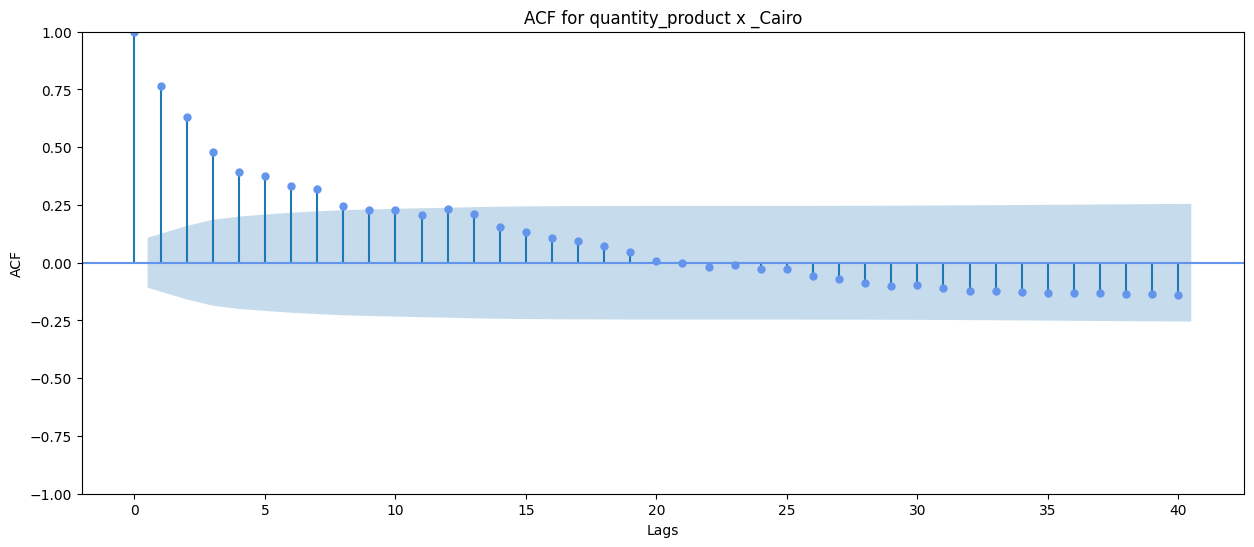

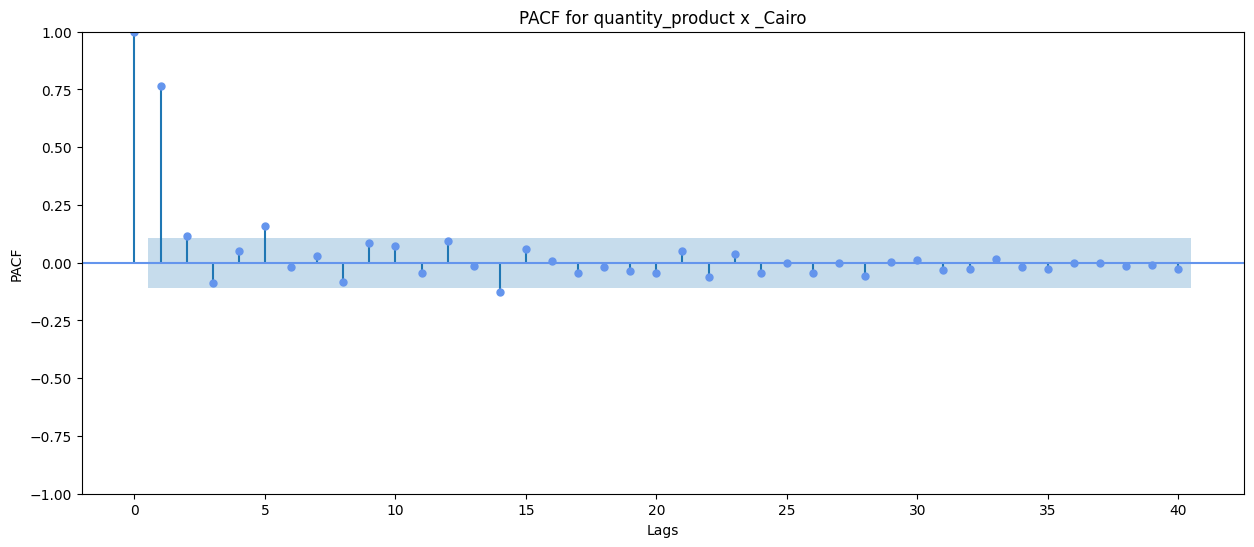

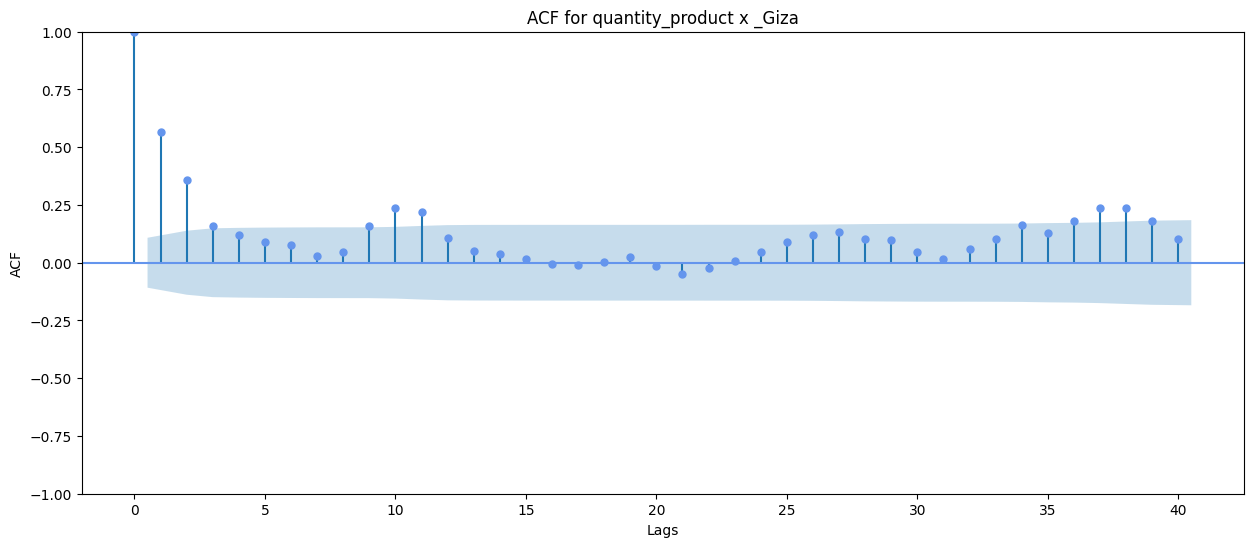

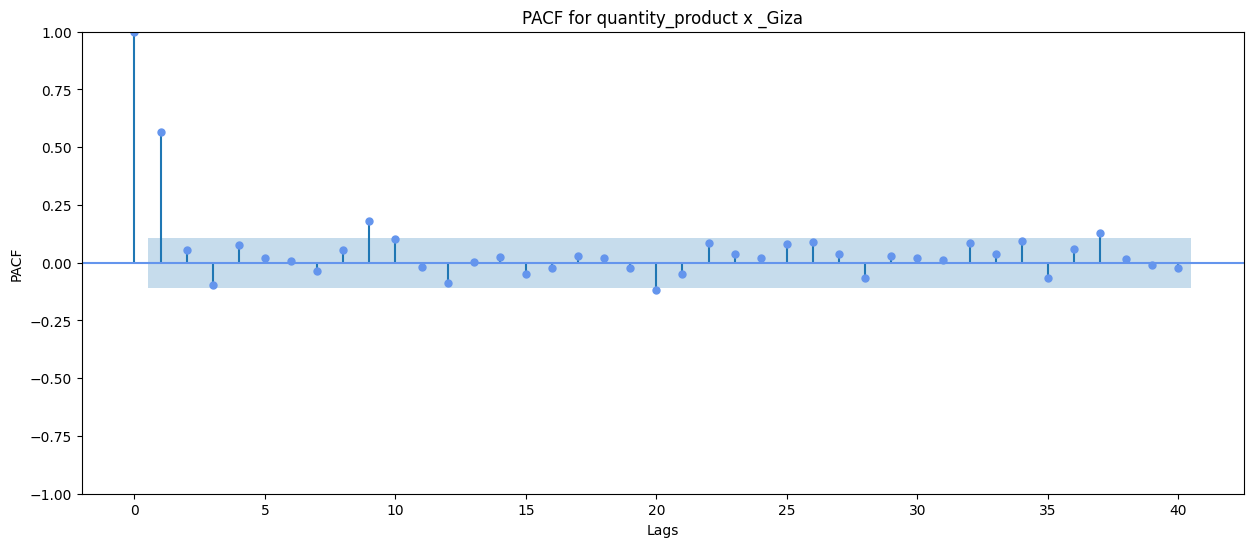

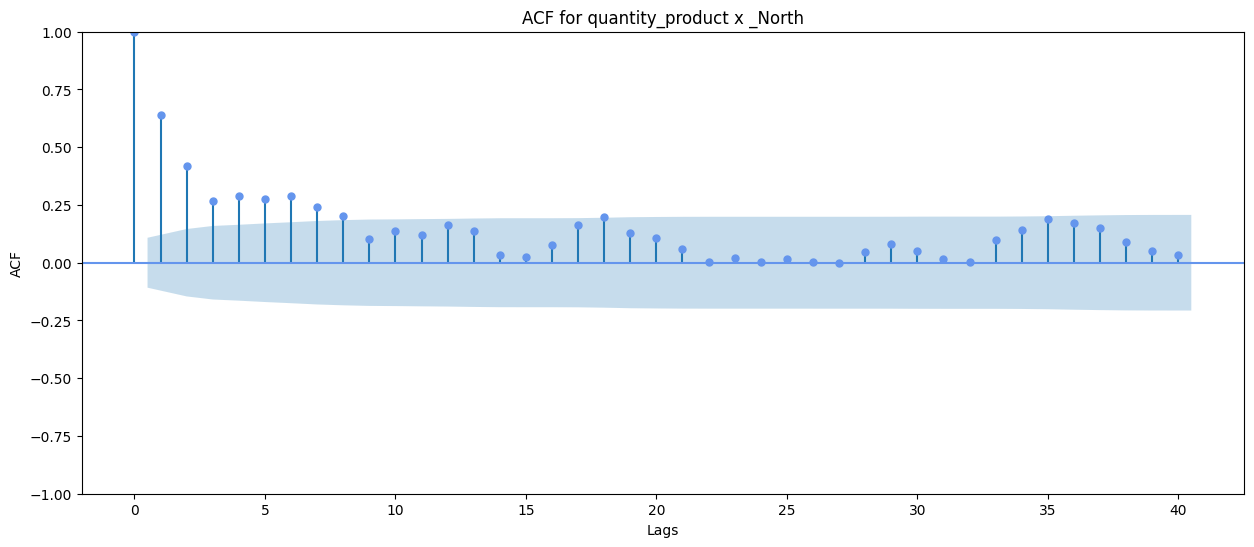

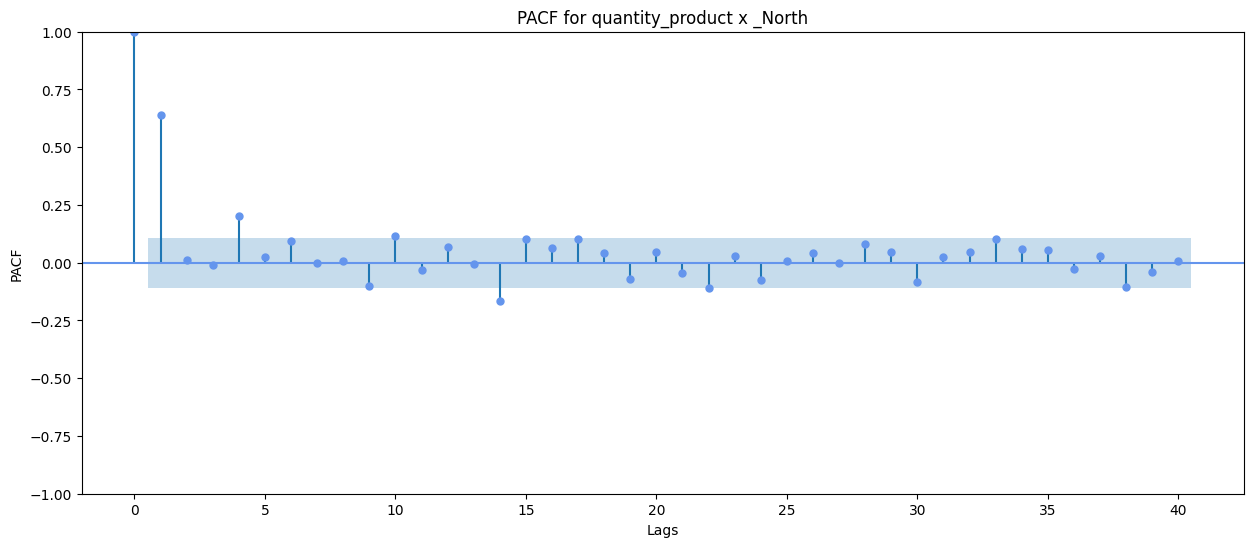

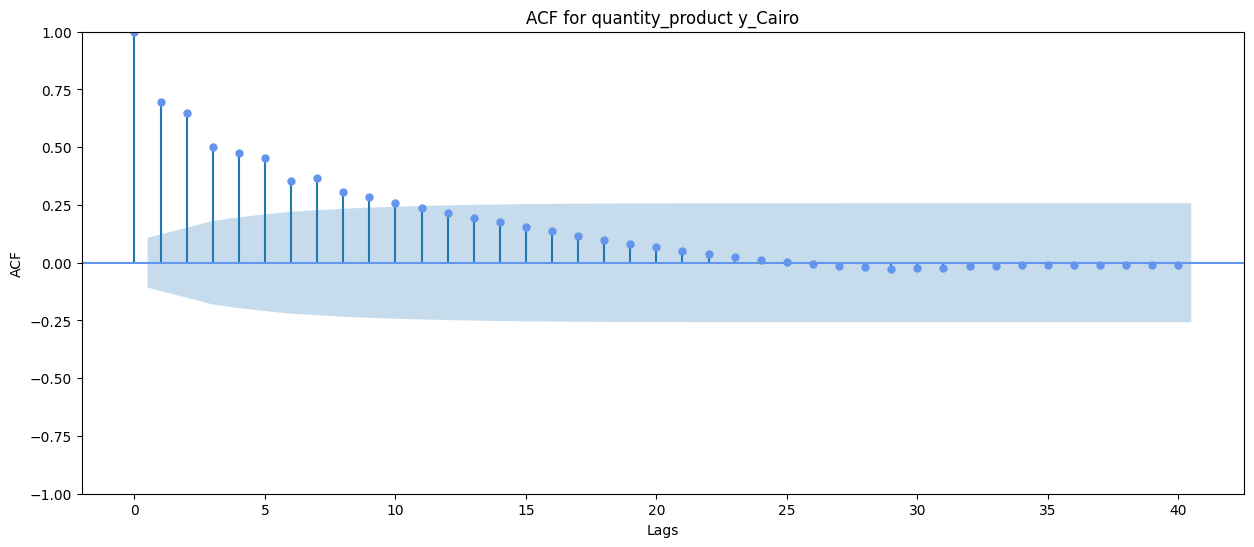

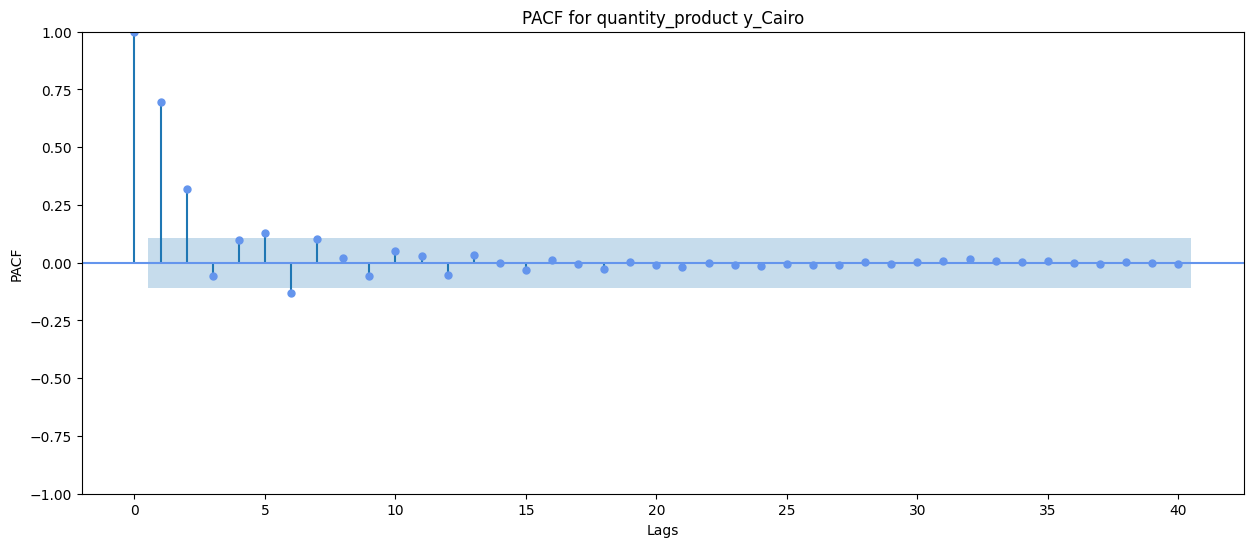

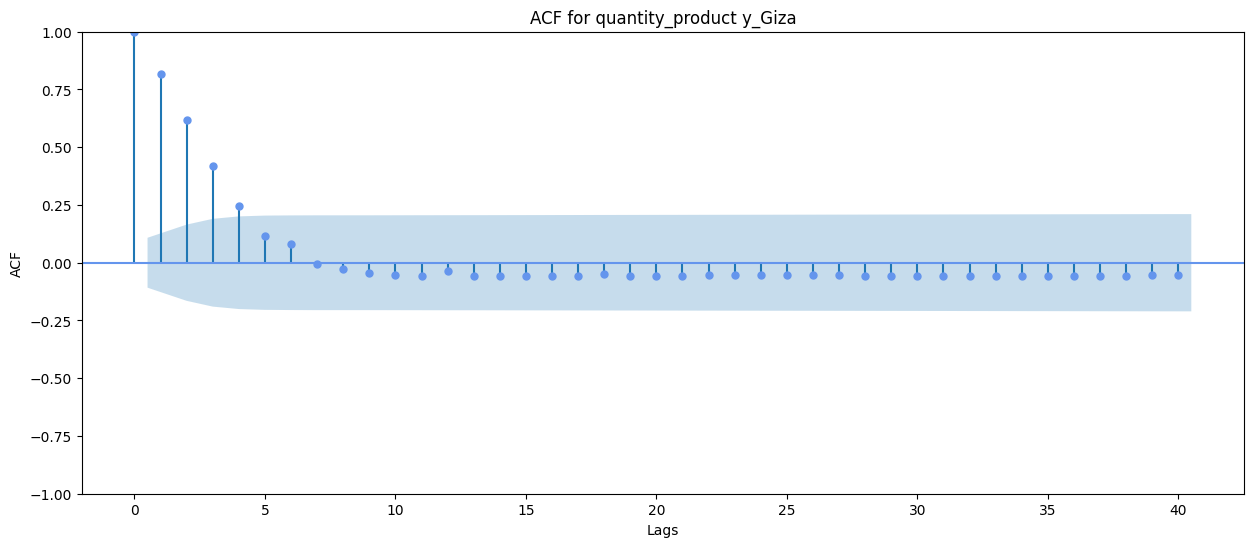

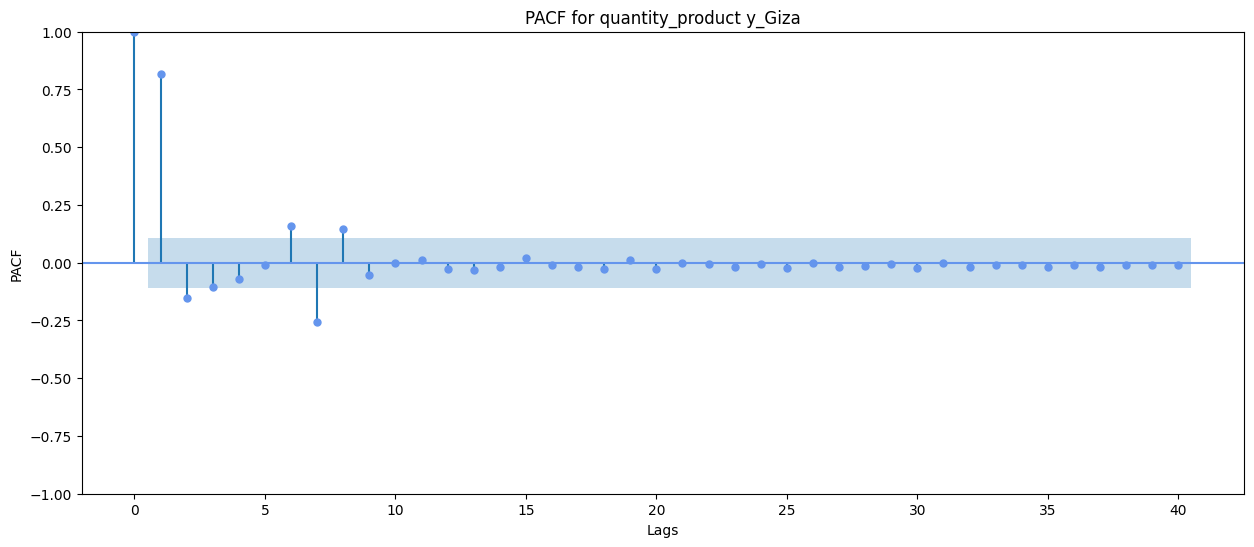

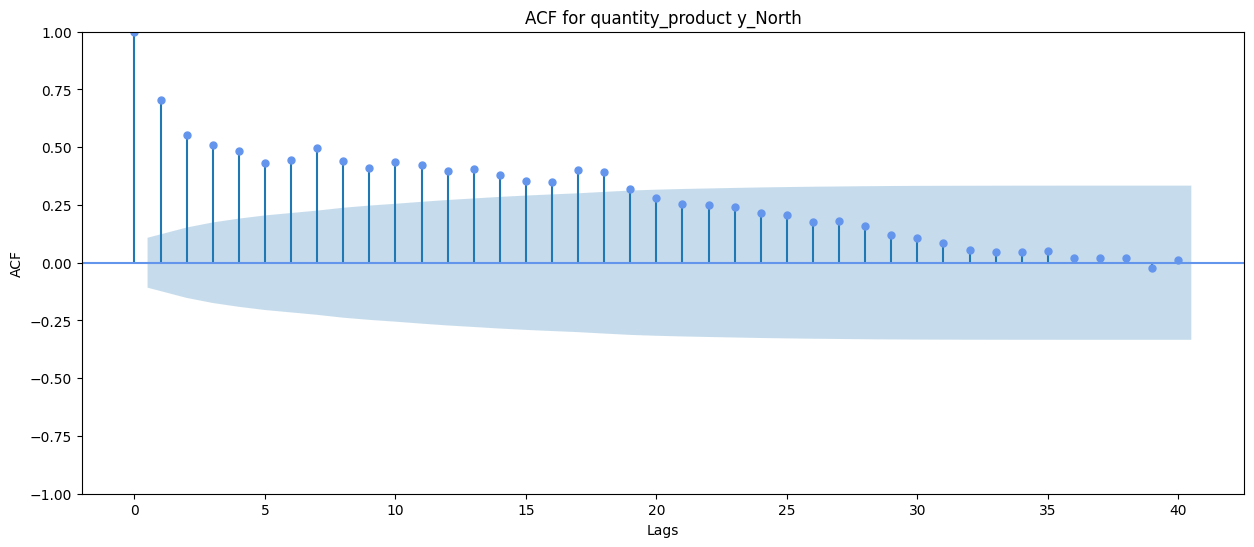

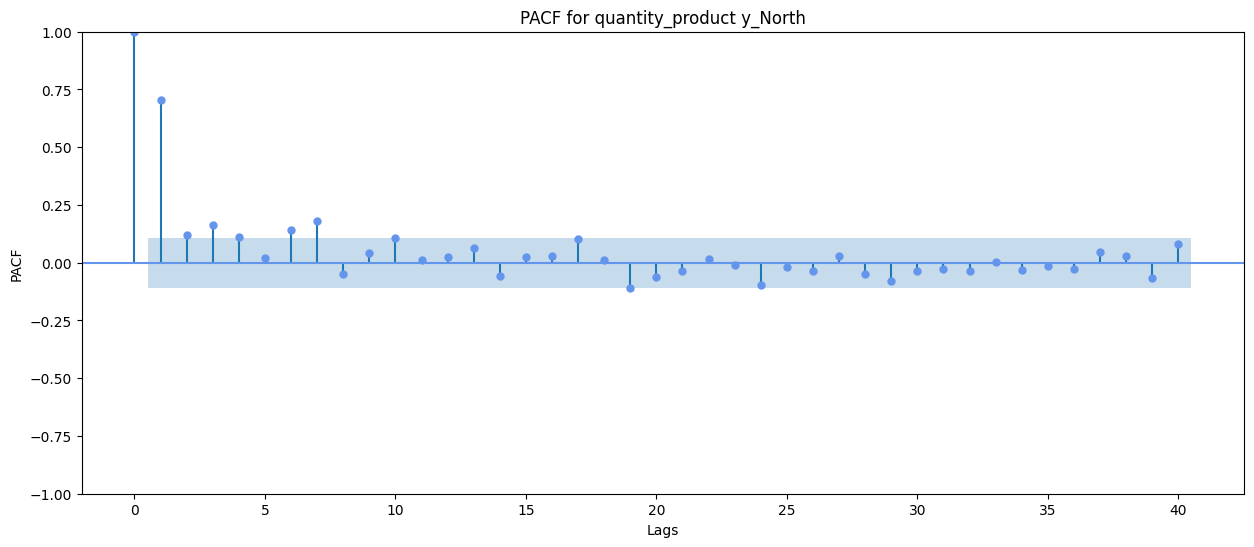

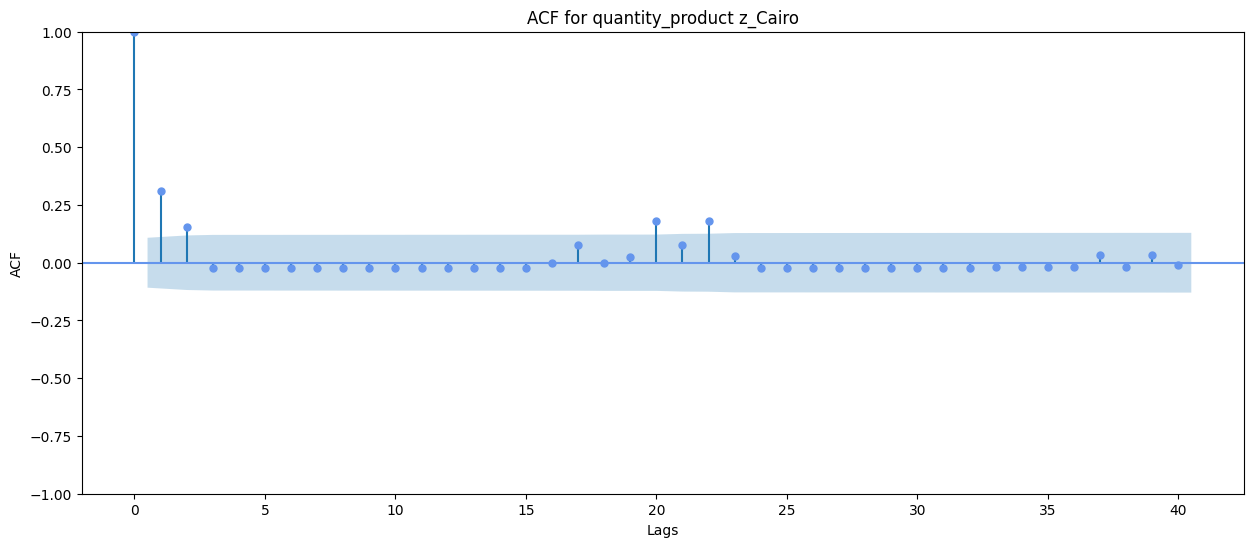

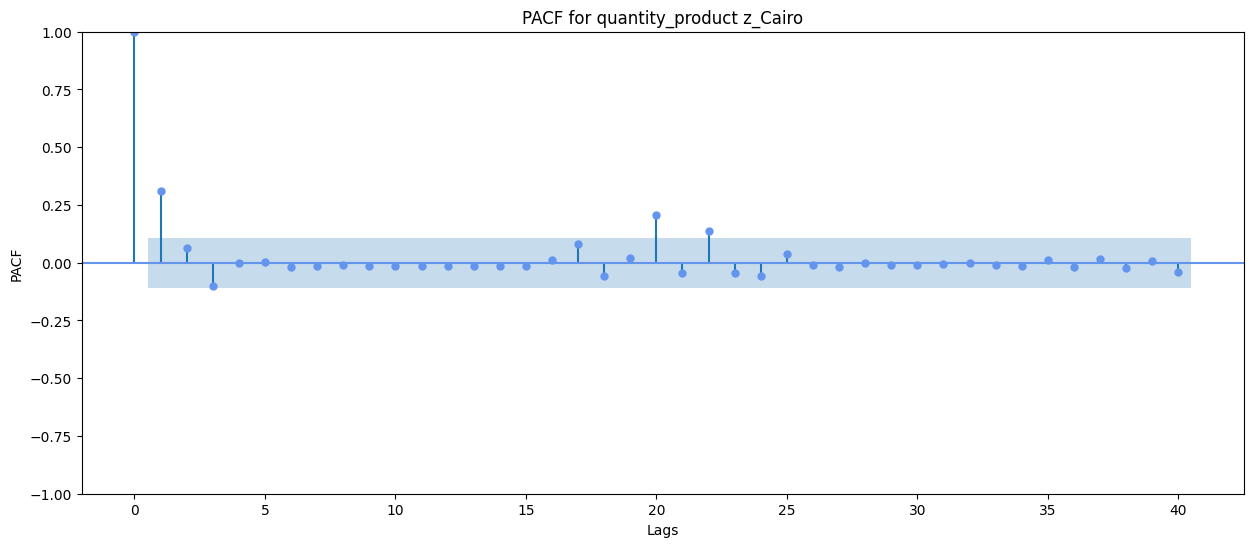

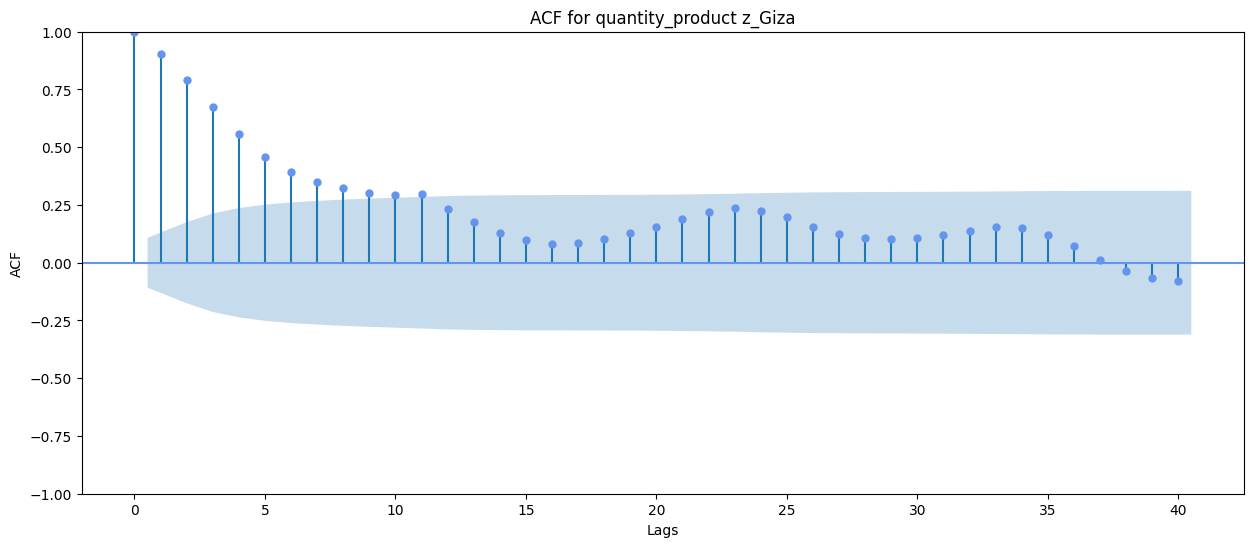

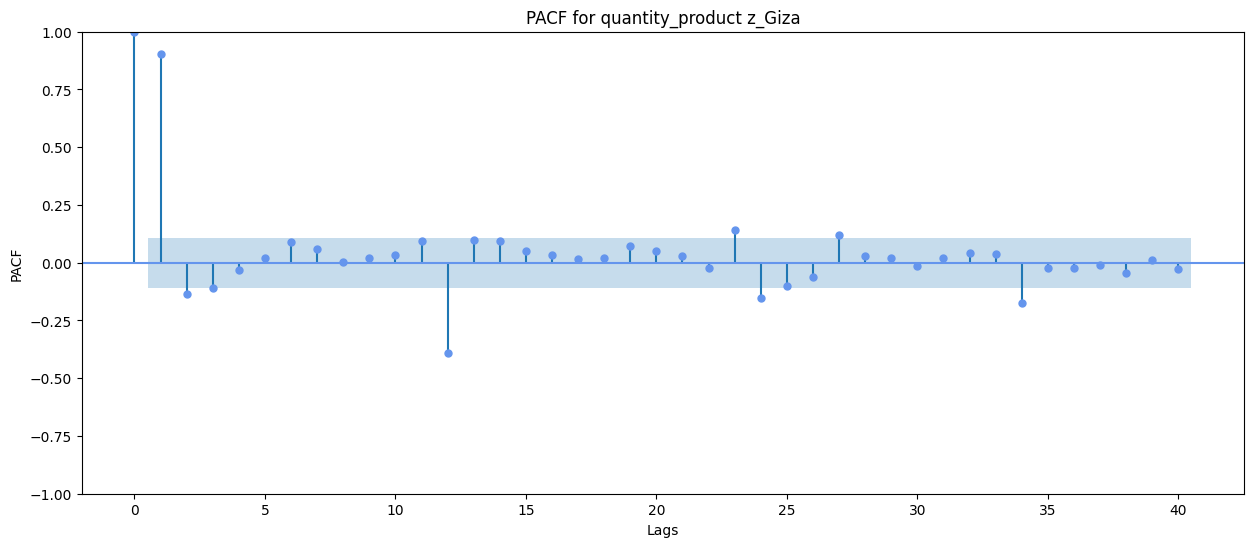

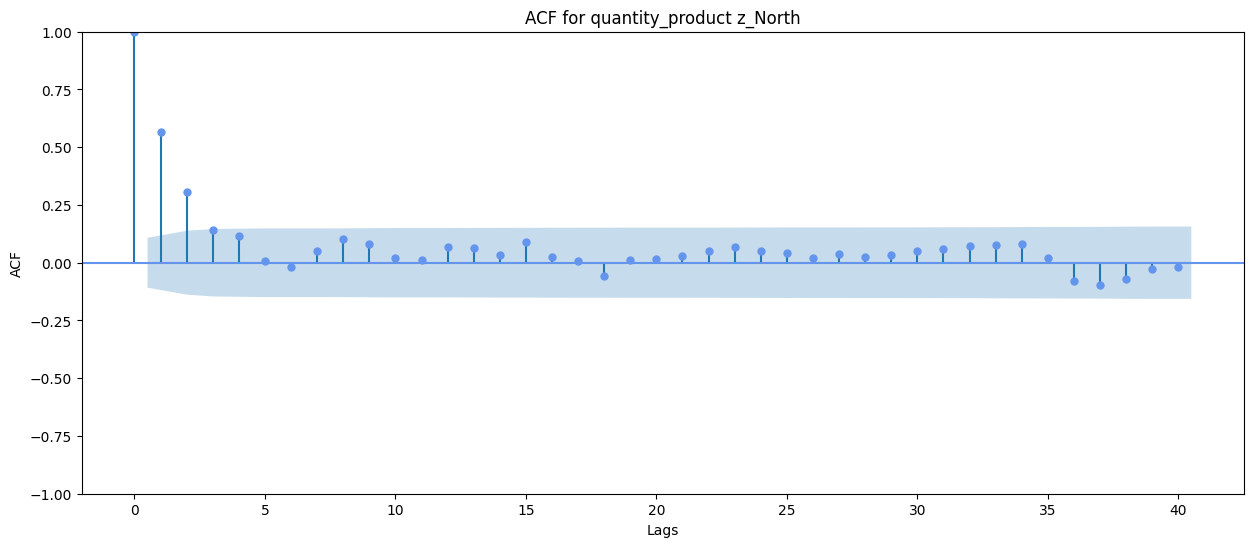

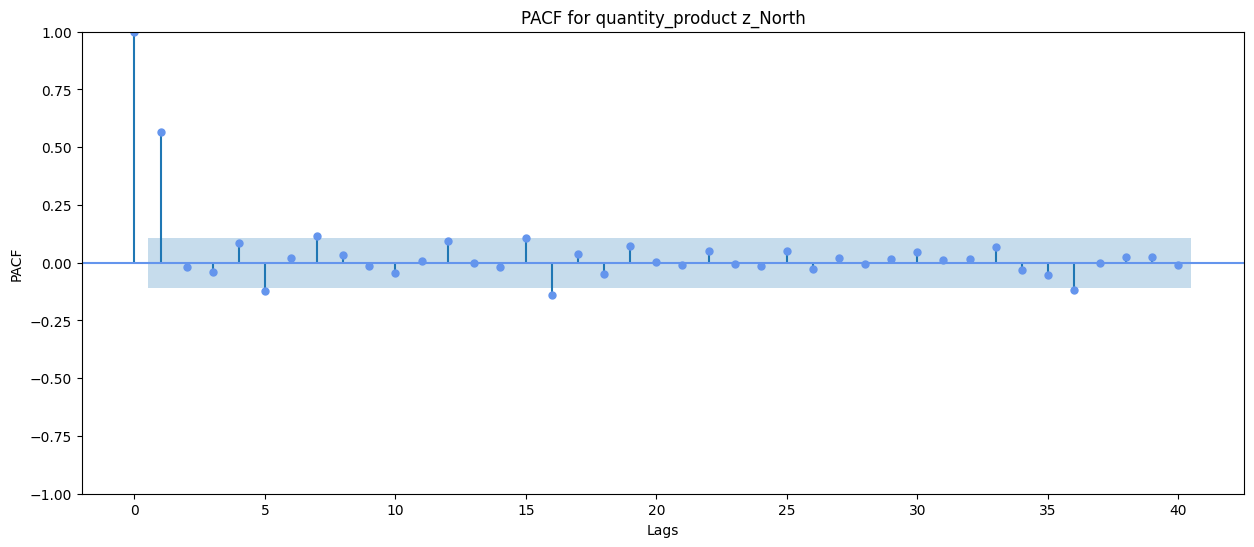

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Loop through your target columns and plot ACF and PACF
for col in out_cols:
    # Plot ACF
    plt.figure(figsize=(15, 6))
    plot_acf(pivot_df_resampled_filtered[col], lags=40, ax=plt.gca(), color='cornflowerblue')
    plt.title(f'ACF for {col}')
    plt.xlabel('Lags')
    plt.ylabel('ACF')
    plt.show()

    # Plot PACF
    plt.figure(figsize=(15, 6))
    plot_pacf(pivot_df_resampled_filtered[col], lags=40, ax=plt.gca(), color='cornflowerblue')
    plt.title(f'PACF for {col}')
    plt.xlabel('Lags')
    plt.ylabel('PACF')
    plt.show()


### Conclusion

* Series is non stationary and have seasonal component which would limit our choices .

# Model

## Traditional model ( LightGBM )

### Why


*   Since our series is multivariant and non stationary and has seasonal component .

*   we have alot of features (dimensions) .

*   28 input features (exogenous) + 9 output targets (endogenous) .

**so i decided to use LightGBM since CatBoost slower than LightGBM and more memory consuming (take me alot of time to do random search).**

NOTE : another alternative to use similar model like XGboost or statistical models like VARX .

### Data Preparation


In [ ]:
n_steps = 20           # used instances to make prediction
n_features_out=9       # output features
forecast_horizon = 10  # Predict 10 days ahead

In [ ]:
def split_sequences_multi_output(data, n_steps, forecast_horizon, n_features_out):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        out_end_ix = end_ix + forecast_horizon - 1
        if out_end_ix > len(data) - 1:
            break
        seq_x = data[i:end_ix, :-n_features_out]  # Exclude future output features (data leakage)
        seq_y = data[end_ix:out_end_ix + 1, -n_features_out:]  # Collect 10-day future outputs
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
y = pivot_df_resampled_filtered[out_cols]
X = pivot_df_resampled_filtered.drop(out_cols, axis=1)

In [ ]:
pivot_df_diff = pivot_df_resampled_filtered.copy()
for feature in X.columns:
  pivot_df_diff[f'{feature}_rolling7'] = pivot_df_diff[feature].rolling(7).mean()

### Feature Engineering

In [ ]:
y = pivot_df_diff[out_cols]
X = pivot_df_diff.drop(out_cols, axis=1)

In [ ]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
from numpy import hstack
dataset = hstack((X_scaled,y)) # stack data horizontally
# convert into input/output
X, y = split_sequences_multi_output(dataset, n_steps, forecast_horizon, n_features_out)
n_features_in = X.shape[2]

In [ ]:
import datetime
# Define  reference date
reference_date = np.datetime64('2021-03-31')
# Convert datetime.date to number of days since the reference date
def convert_dates_to_days_since_reference(data):
    # Convert to NumPy datetime64 and subtract reference_date to get the timedelta
    return (np.datetime64(data) - reference_date).astype('timedelta64[D]').astype(int)

# Apply this conversion to the first column
for i in range(X.shape[0]):  # Iterate over each sample
    for j in range(X.shape[1]):  # Iterate over each time step
        if isinstance(X[i, j, 0], datetime.date):  # If the element is a date object
            X[i, j, 0] = convert_dates_to_days_since_reference(X[i, j, 0])

In [ ]:
X = X.astype('float32')
y = y.astype('float32')
X_test = X[-10:]
y_test = y[-10:]
X_remaining = X[:-10]
y_remaining = y[:-10]
val_size = int(0.1 * len(X_remaining))  # 10% of remaining data for validation
X_train = X_remaining[:-val_size]
y_train = y_remaining[:-val_size]
X_val = X_remaining[-val_size:]
y_val = y_remaining[-val_size:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (261, 20, 54), y_train shape: (261, 10, 9)
X_test shape: (10, 20, 54), y_test shape: (10, 10, 9)


### Model Training with LightGBM


In [ ]:
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor

# Initialize LightGBM model
lgbm = LGBMRegressor(objective='regression', reg_alpha=0.1,reg_lambda=0.2)

# Wrap for multi-output regression
model = MultiOutputRegressor(lgbm)

# Train
# model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Hyperparameter Tuning (Randomized Search)

In [54]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'estimator__n_estimators': [500,1000,1500,2000],
    'estimator__learning_rate': [0.01,0.05 ,0.1],
    'estimator__max_depth': [12,15,20],
    'estimator__subsample': [0.6, 0.8,1]

}

search = RandomizedSearchCV(
    model,
    param_distributions=param_grid,
    n_iter=15,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)
X_train_Lgbm=X_train.reshape(X_train.shape[0], -1)
y_train_Lgbm=y_train.reshape(y_train.shape[0], -1)
search.fit(X_train_Lgbm, y_train_Lgbm)
best_model = search.best_estimator_

Fitting 3 folds for each of 15 candidates, totalling 45 fits


KeyboardInterrupt: 

###Evaluation

In [55]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
forecast_horizon=10
n_features_out=9
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)  # Shape: (num_samples, forecast_horizon * num_features)
y_pred = best_model.predict(X_test_reshaped)
y_pred_clipped = np.clip(y_pred, 0, np.inf)
y_pred=y_pred_clipped.reshape(y_pred_clipped.shape[0], forecast_horizon, n_features_out)
product_names = [
    'quantity_product x_Cairo',
    'quantity_product x_Giza',
    'quantity_product x_North',
    'quantity_product y_Cairo',
    'quantity_product y_Giza',
    'quantity_product y_North',
    'quantity_product z_Cairo',
    'quantity_product z_Giza',
    'quantity_product z_North'
]

# 1. Combine y_test and y_pred for comparison (along the feature axis)
combined = np.concatenate([y_test, y_pred], axis=-1)
print(f"Combined shape: {combined.shape}")

# 2. Compute Root Mean Squared Error (RMSE) for all samples, timesteps, and products
mse = mean_squared_error(
    y_test.reshape(-1, y_test.shape[-1]),
    y_pred.reshape(-1, y_pred.shape[-1]),
    multioutput='uniform_average'
)
print(f"Root Mean Squared Error: {mse**0.5}")

# 3. Compute Mean Absolute Error (MAE) for all samples, timesteps, and products
mae = mean_absolute_error(
    y_test.reshape(-1, y_test.shape[-1]),
    y_pred.reshape(-1, y_pred.shape[-1]),
    multioutput='uniform_average'
)
print(f"Mean Absolute Error: {mae}")

# 4. Visualize comparison by day (all products per day)
samples = y_test.shape[0]  # Number of days
timesteps = 10
products = 9

for day in range(timesteps):  # Loop through all days
    print(f"\nVisualizing results for Day {day + 1} of {timesteps}")

    # Create a subplot for all products for the current day
    fig, axes = plt.subplots(nrows=products, ncols=1, figsize=(12, products * 3), sharex=True)
    fig.suptitle(f"Day {day + 1} - Product Comparison", fontsize=16)

    for product_idx, ax in enumerate(axes):  # Loop through all products
        # Plot True values
        ax.plot(range(samples), y_test[:, day, product_idx], label='True', color='blue')

        # Plot Predicted values
        ax.plot(range(samples), y_pred[:, day, product_idx], label='Predicted', color='red')

        # Title and Labels
        ax.set_title(f"{product_names[product_idx]}")
        ax.set_ylabel("Value")
        ax.grid()

    # Common labels
    axes[-1].set_xlabel("Samples (10 Days)")
    axes[0].legend(loc='upper right')

    # Adjust layout and show
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust for title space
    plt.show()

NameError: name 'best_model' is not defined

In [ ]:
# Check performance on non-zero sales days
#MAE
non_zero_mask = y_test != 0
non_zero_mae = np.mean(np.abs(y_test[non_zero_mask] - y_pred[non_zero_mask]))
print(f"Non-Zero MAE: {non_zero_mae:.2f}")
#RMSE
non_zero_rmse = np.sqrt(np.mean((y_test[non_zero_mask] - y_pred[non_zero_mask]) ** 2))
print(f"Non-Zero RMSE: {non_zero_rmse:.2f}")

In [ ]:
# Get feature importances for the first target
importance = best_model.estimators_[0].feature_importances_
X_train=X
feature_names =pivot_df_diff.drop(out_cols, axis=1).columns

plt.figure(figsize=(12, 150))
plt.barh(range(len(importance)), importance, align='center')
plt.yticks(range(len(importance)), feature_names)
plt.xlabel('Feature Importance')
plt.title('LightGBM Feature Importance')
plt.show()

* Added (total_price) feature has significant impact on model .

### Interpretation

* MAE about 2 in averge which means predictions is off by 2 units and RMSE about 6 in average (Larger errors occur,
 likely from missing sales spikes) so RMSE > MAE means Model predicts zeros well (overpredicts)but struggles with sales spikes.
*  Trade off between RMSE and MAE (Bussines dependent) .


### Concolusion

* We need alot of hand crafted feature engineering .

## Deep learning model ( LSTM )

 -----------------------------------------------------------------------------------------------------------------------------

In [56]:
from numpy import hstack
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Flatten , Input,Masking ,TimeDistributed,RepeatVector  ,TimeDistributed,AdditiveAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

### Data Preparation


In [57]:
n_steps = 20           # used instances to make prediction
n_features_out=9       # output features
forecast_horizon = 10  # Predict 10 days ahead

In [58]:
def split_sequences_multi_output(data, n_steps, forecast_horizon, n_features_out):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        out_end_ix = end_ix + forecast_horizon - 1
        if out_end_ix > len(data) - 1:
            break
        seq_x = data[i:end_ix, :-n_features_out]  # Exclude future output features (data leakage)
        seq_y = data[end_ix:out_end_ix + 1, -n_features_out:]  # Collect 10-day future outputs
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [59]:
y = pivot_df_resampled_filtered[out_cols]
X = pivot_df_resampled_filtered.drop(out_cols, axis=1)

In [60]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [61]:
dataset = hstack((X_scaled,y)) # stack data horizontally
# convert into input/output
X, y = split_sequences_multi_output(dataset, n_steps, forecast_horizon, n_features_out)
n_features_in = X.shape[2]

In [62]:
import datetime
# Define  reference date
reference_date = np.datetime64('2021-03-31')
# Convert datetime.date to number of days since the reference date
def convert_dates_to_days_since_reference(data):
    # Convert to NumPy datetime64 and subtract reference_date to get the timedelta
    return (np.datetime64(data) - reference_date).astype('timedelta64[D]').astype(int)

# Apply this conversion to the first column
for i in range(X.shape[0]):  # Iterate over each sample
    for j in range(X.shape[1]):  # Iterate over each time step
        if isinstance(X[i, j, 0], datetime.date):  # If the element is a date object
            X[i, j, 0] = convert_dates_to_days_since_reference(X[i, j, 0])

In [63]:
# Total data
n = len(X)

# Test set: Last 10 samples
X_test = X[-10:]
y_test = y[-10:]

# Remaining data (N-10 samples)
X_remaining = X[:-10]
y_remaining = y[:-10]

# Validation set: Last 10% of remaining data
val_size = int(0.1 * len(X_remaining))  # Adjust to your needs
X_train = X_remaining[:-val_size]
y_train = y_remaining[:-val_size]
X_val = X_remaining[-val_size:]
y_val = y_remaining[-val_size:]

# Check shapes
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val: {X_val.shape}, {y_val.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

Train: (261, 20, 27), (261, 10, 9)
Val: (29, 20, 27), (29, 10, 9)
Test: (10, 20, 27), (10, 10, 9)


In [64]:
print("X shape:", X.shape)  # Expected: (num_samples, n_steps, n_features)
print("y shape:", y.shape)  # Expected: (num_samples, 10)


X shape: (300, 20, 27)
y shape: (300, 10, 9)


### Oversampling

In [65]:
high_sales_mask = (y_train >= 1).any(axis=(1, 2))

X_high = X_train[high_sales_mask]
y_high = y_train[high_sales_mask]

# Combine with original data
X_combined = np.vstack([X_train, X_high])
y_combined = np.vstack([y_train, y_high])

* Oversampling high values to add balance to data (Reduce RMSE) .

In [66]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

print("Final X_combined shape:", X_combined.shape)
print("Final y_combined shape:", y_combined.shape)
y_combined = y_combined.reshape(y_combined.shape[0], -1)

Shape of X_train: (261, 20, 27)
Shape of y_train: (261, 10, 9)
Final X_combined shape: (512, 20, 27)
Final y_combined shape: (512, 10, 9)


* Oversample high sales periods to reduce class imbalance .

##### Custom loss function

In [226]:
from tensorflow.keras.models import load_model
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler

@register_keras_serializable()

def weighted_rmse(y_true, y_pred,  base_weight_zero=1.0,  base_weight_non_zero=25.0, high_sales_factor=5.0, high_sales_threshold=8.0, normalize_weights=True):
    base_weights = tf.where(y_true == 0, base_weight_zero, base_weight_non_zero)
    high_sales_mask = tf.cast(y_true >= high_sales_threshold, tf.float32)
    high_sales_weights = high_sales_factor * high_sales_mask
    weights = base_weights + high_sales_weights

    if normalize_weights:
        weights = weights / tf.reduce_mean(weights)

    squared_errors = weights * tf.square(y_true - y_pred)
    rmse = tf.sqrt(tf.reduce_mean(squared_errors))
    return rmse

Resulting Weights:

* 1.0 for y_true == 0.

* 9.0 for 0 < y_true < 5.

* 20.0 for y_true >= 5.

**Penalize predictions of high sales is scale .**

### One shot LSTM

####LSTM Model Architecture


In [227]:
from tensorflow.keras.layers import GRU
input_shape = (n_steps, n_features_in)
model = Sequential()
model.add(Input(shape=input_shape))
model.add(Masking(mask_value=0.0))
model.add(GRU(70, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(40))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(n_features_out * forecast_horizon, activation='linear'))  # Linear activation for regression
# model.summary()

* Masking layer to pay more attention to non-zero values .
* Adding dropout layer to prevent overfitting .
* Replace faltten layer with LSTM to preserve temporal structure .
* Adding batchnorm layer helps stabilize training and improve convergence .
* Adding relu activiation in last layer to cut off negative predictions .

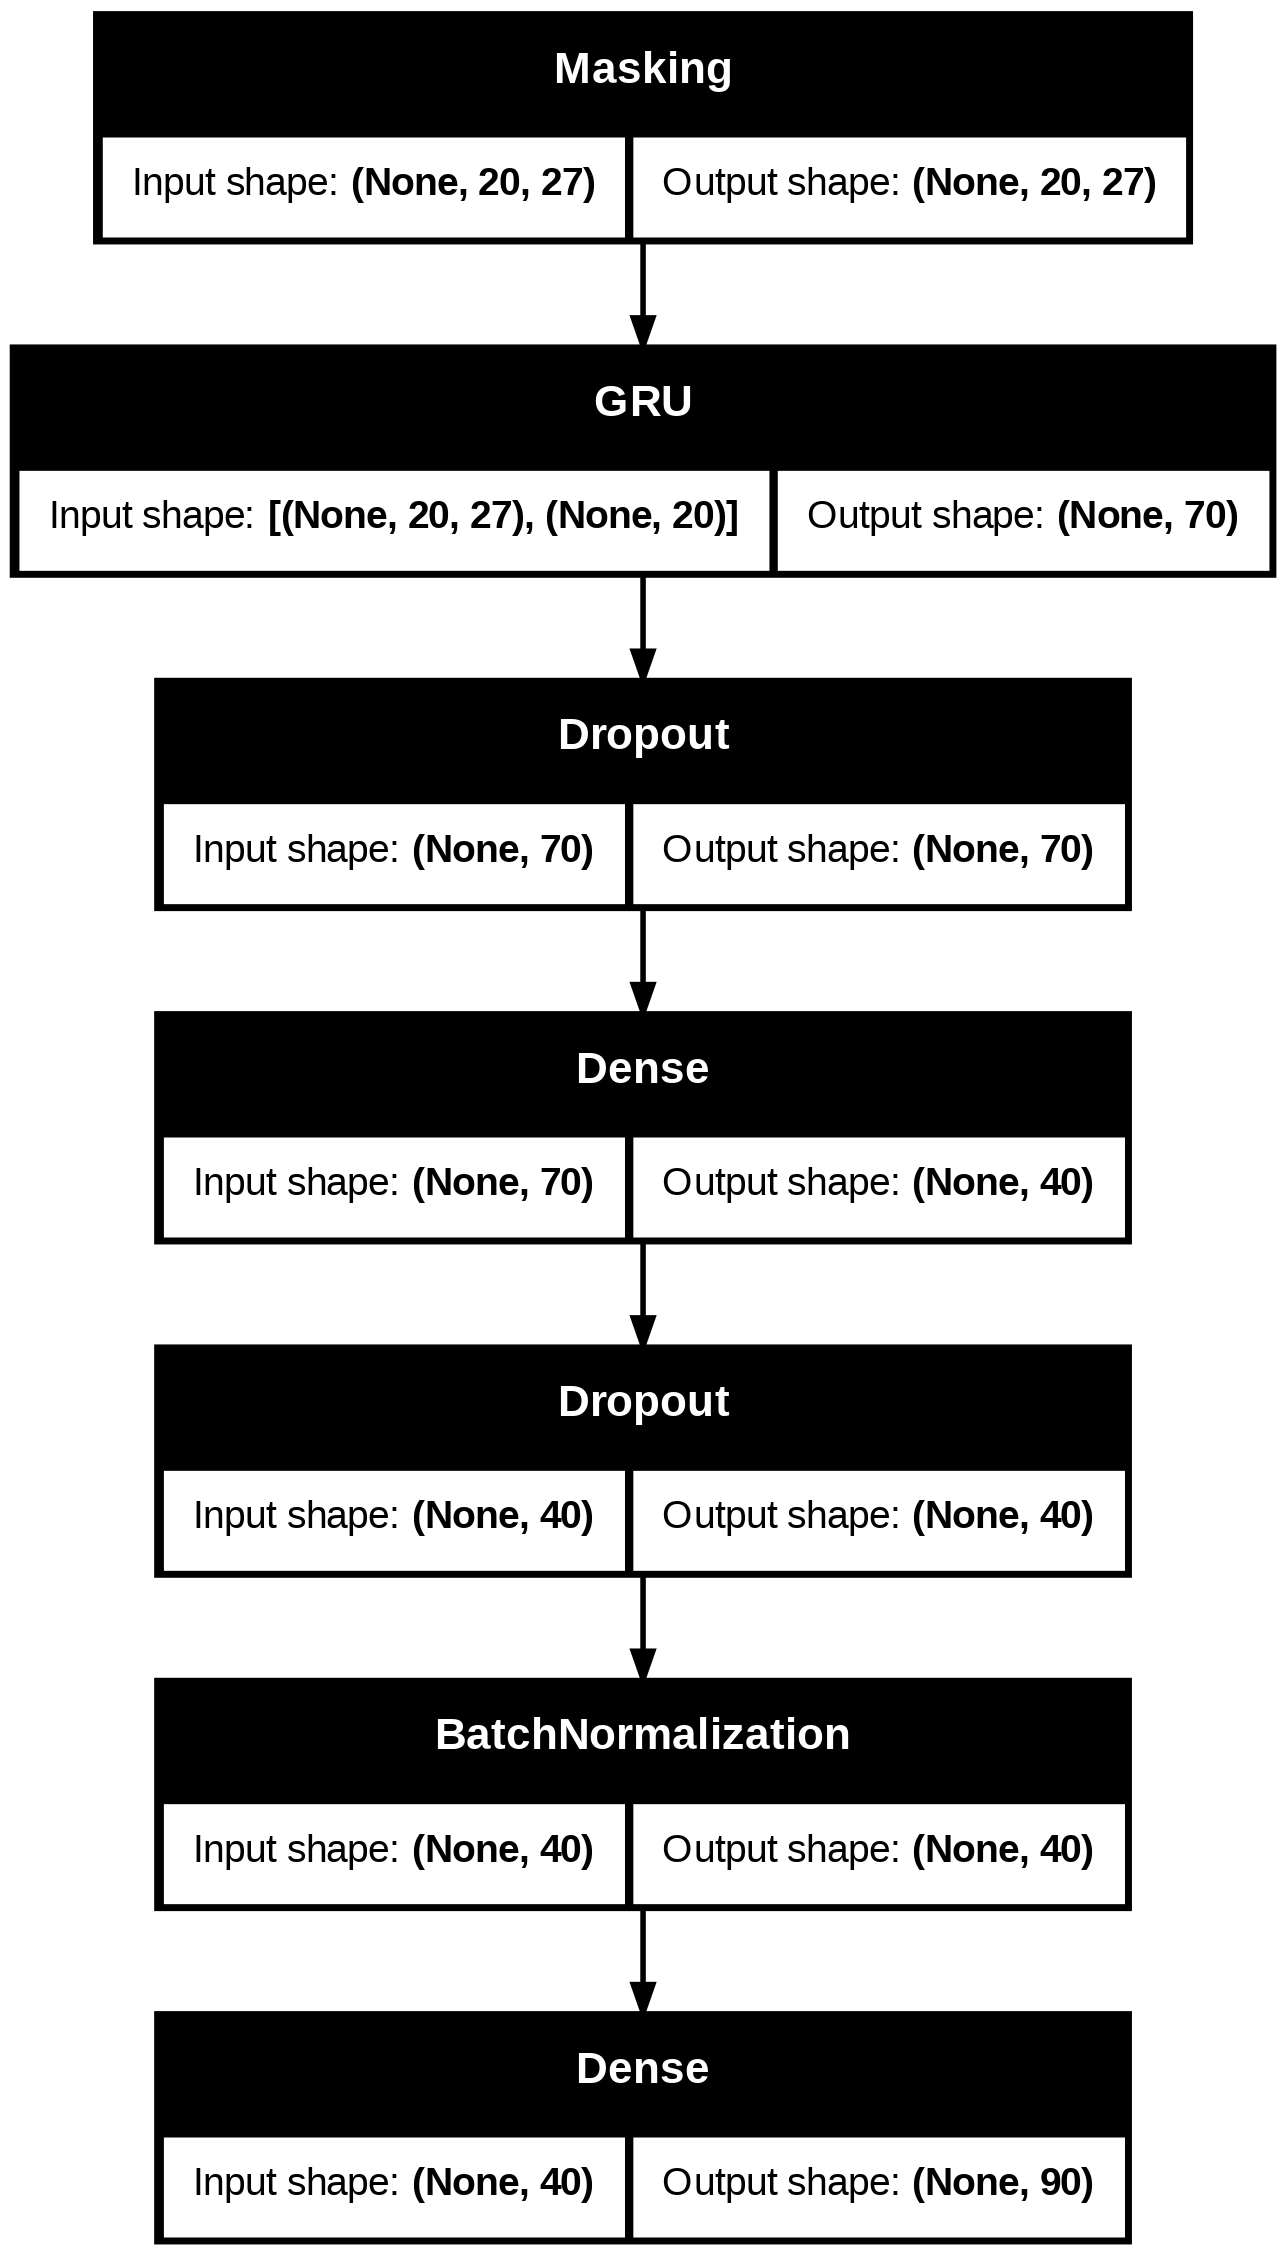

In [242]:
plot_model(model, show_shapes=True)

##### Model training

In [229]:
# Define the optimizer with a custom exponentially decaying learning rate
def lr_schedule(epoch, lr):
    if epoch > 10:  # Start decaying after 10 epochs
        lr = lr * 0.99999
    return lr
lr_scheduler = LearningRateScheduler(lr_schedule)
optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss=weighted_rmse)

* Small learning rate with decaying to apply smoothness .

In [230]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/NLP/best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

* Adding early stoping to prevent overfitting and callback to save best model .


In [231]:
# Train the model
history = model.fit(X_combined, y_combined,
                    epochs=750,
                    verbose=1,
                    callbacks=[ model_checkpoint,early_stopping,lr_scheduler],
                    validation_data=(X_val, y_val.reshape(y_val.shape[0], -1)))


Epoch 1/750
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.8528
Epoch 1: val_loss improved from inf to 3.17025, saving model to /content/drive/MyDrive/NLP/best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 4.8254 - val_loss: 3.1703 - learning_rate: 1.0000e-04
Epoch 2/750
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.8288
Epoch 2: val_loss improved from 3.17025 to 3.16575, saving model to /content/drive/MyDrive/NLP/best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 4.8169 - val_loss: 3.1658 - learning_rate: 1.0000e-04
Epoch 3/750
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.9154
Epoch 3: val_loss improved from 3.16575 to 3.16347, saving model to /content/drive/MyDrive/NLP/best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 4.9026 - val_loss: 3.1635 - learning_rate: 1.0000e-04
Epoch 4/750
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.5186
Epoch 4: val_loss improved from 3.16347 to 3.16066, saving model to /content/drive/MyDrive/NLP

* First approch , I use only encoder LSTM to predict all 10 days in one shot without feedback from prediction of previous day .
* In this case many to many un aligned .

### Seq2seq LSTM

#### Seq2seq model architecture

In [238]:
# Encoder Processes the input sequence and encodes it into a context vector.
encoder_inputs = Input(shape=(n_steps, n_features_in))
masking=(Masking(mask_value=0.0))(encoder_inputs)
lstm1 = (LSTM(350,return_sequences=True))(masking)
encoder1=Dropout(0.8)(lstm1)
lstm2 = LSTM(250)(masking)
encoder2=Dropout(0.8)(lstm2)
encoder=(BatchNormalization())(encoder2)



# Decoder generates the output sequence step-by-step using the context vector.

# Repeats the context vector for each time step in the output sequence
decoder_inputs = RepeatVector(forecast_horizon)(encoder)
decoder = LSTM(150,return_sequences=True)(decoder_inputs)
# TimeDistributed	Applies a dense layer to each time step independently
outputs = TimeDistributed(Dense(n_features_out,activation="linear"))(decoder)

model_seq = Model(encoder_inputs, outputs)

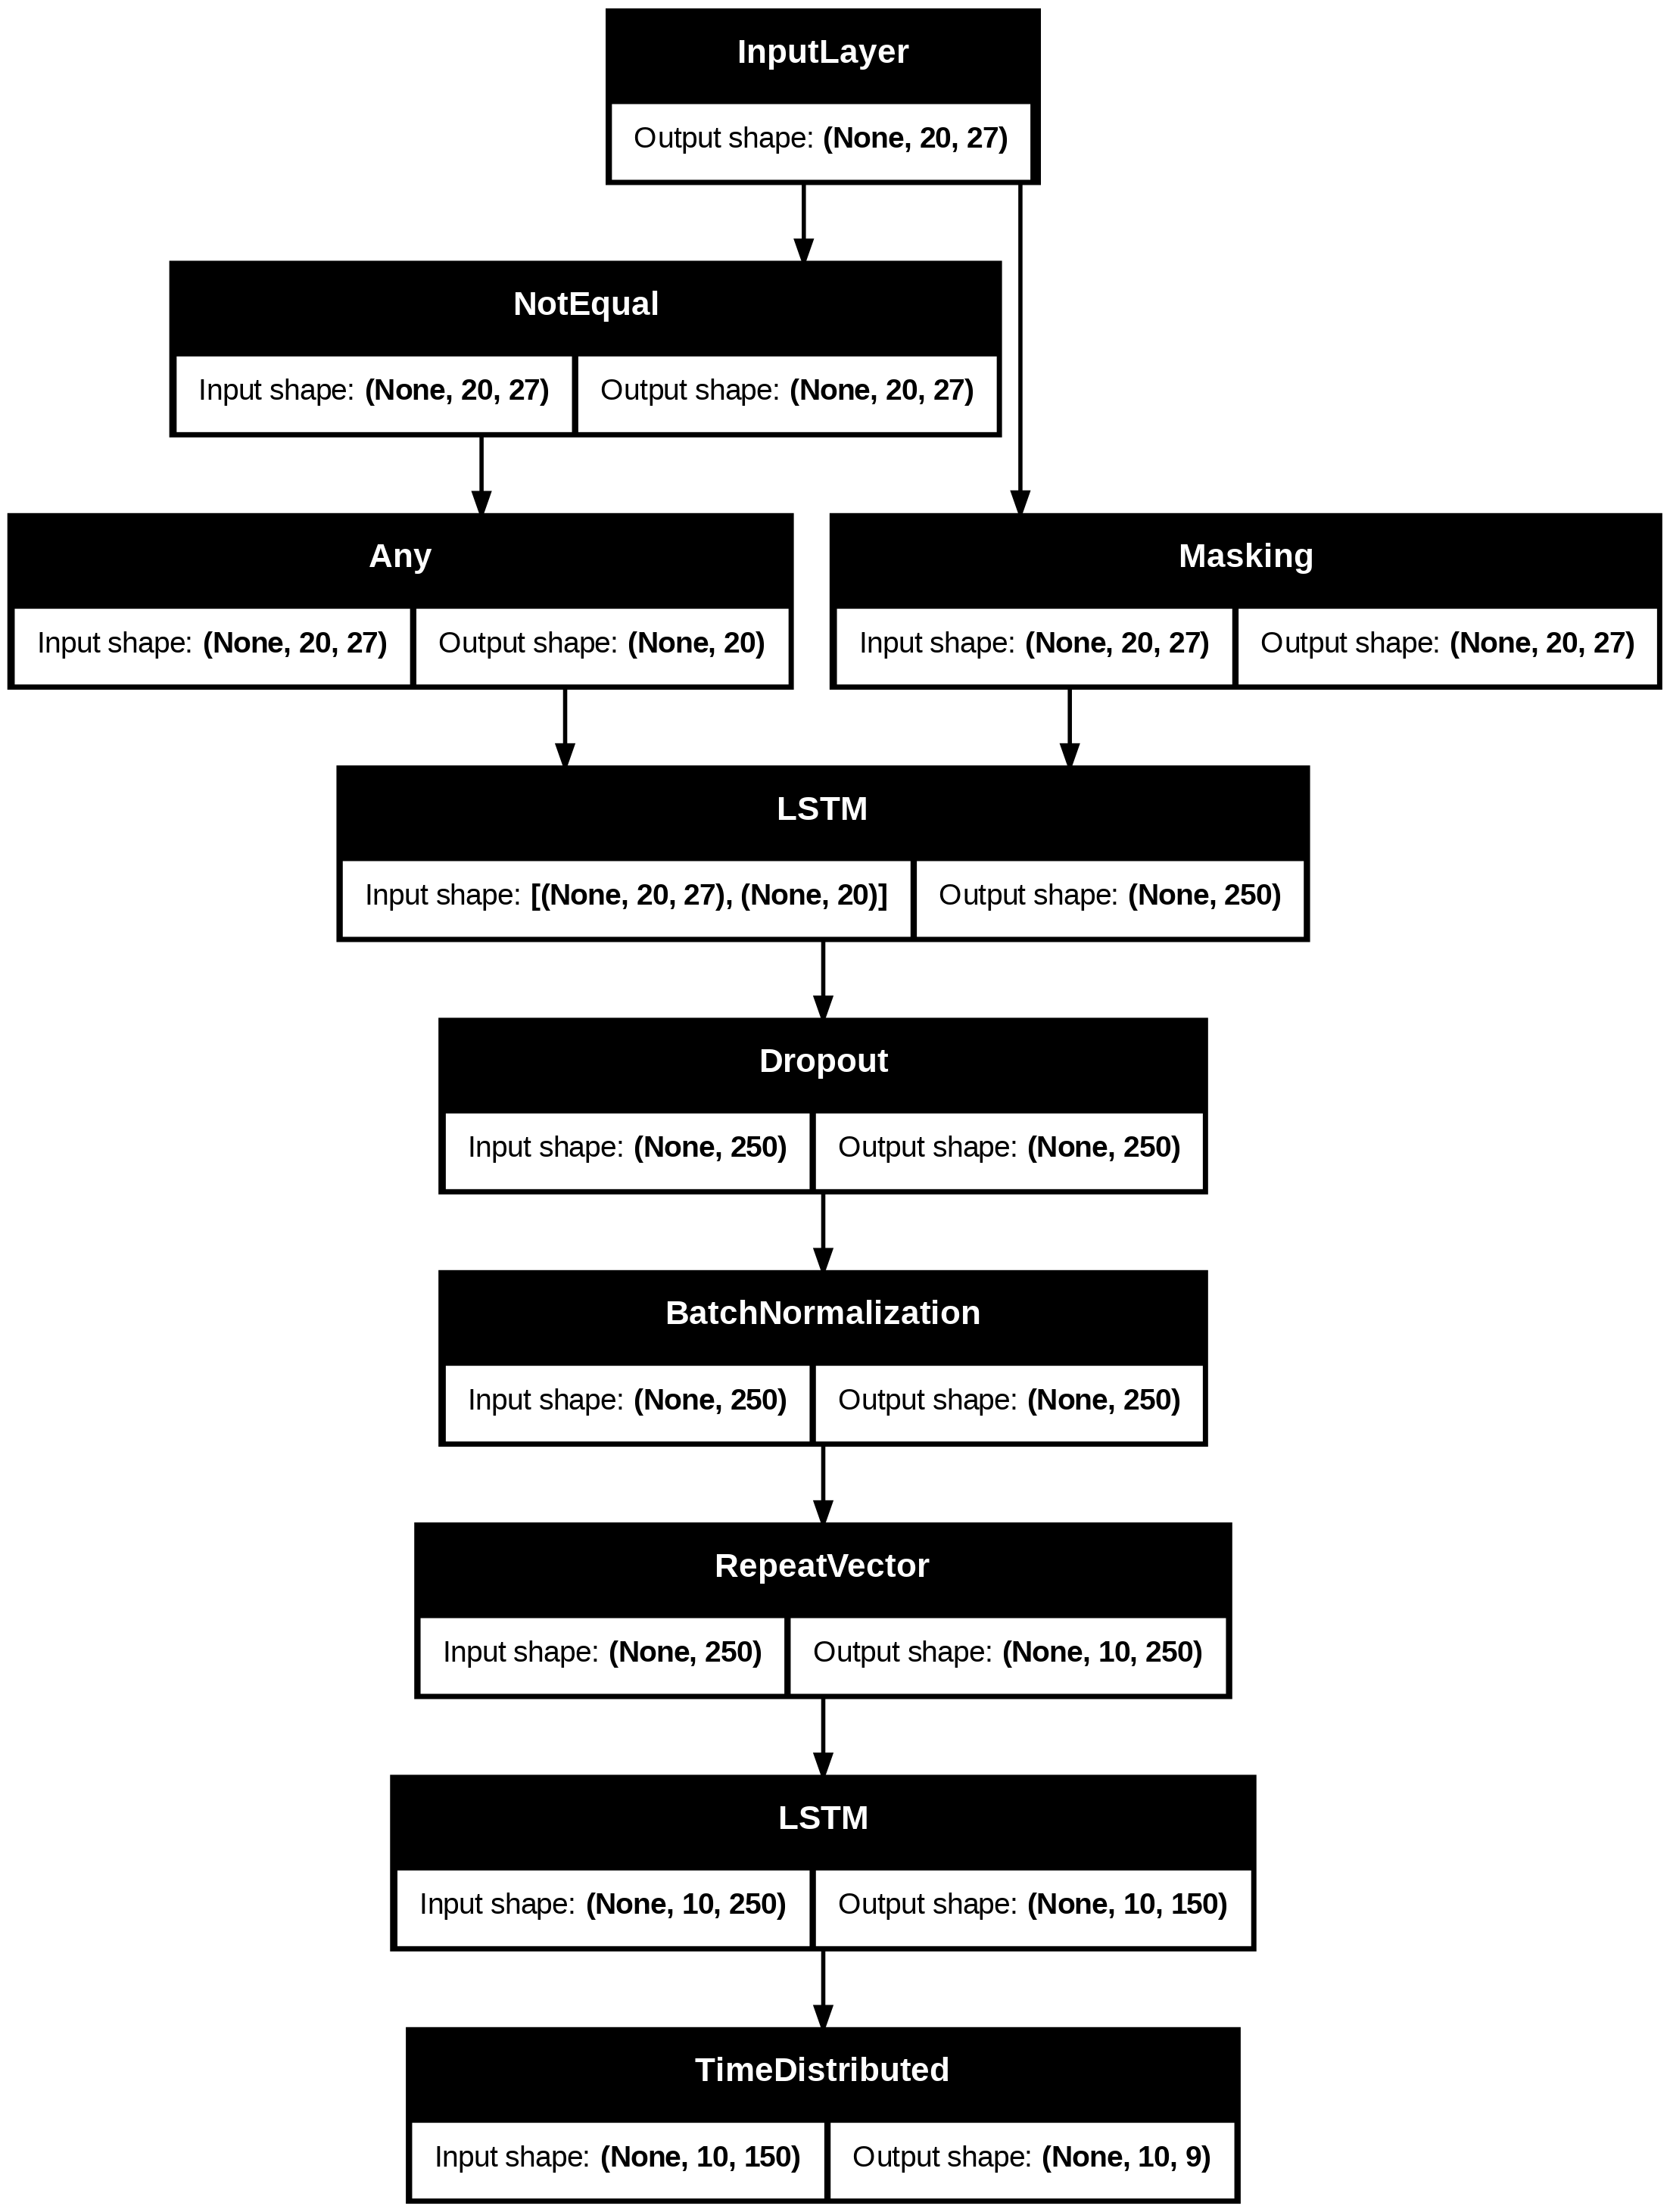

In [241]:
plot_model(model_seq, show_shapes=True)

##### Model training

In [243]:
# Define the optimizer with a custom exponentially decaying learning rate
def lr_schedule(epoch, lr):
    if epoch > 10:  # Start decaying after 10 epochs
        lr = lr * 0.99999
    return lr
lr_scheduler = LearningRateScheduler(lr_schedule)
optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss=weighted_rmse)

In [245]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/NLP/best_model_seq.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [246]:
# Train the model
y_combined = y_combined.reshape(-1, forecast_horizon, n_features_out)
history2 = model_seq.fit(X_combined, y_combined,
                    epochs=300,
                    verbose=1,
                    callbacks=[ model_checkpoint,early_stopping],
                    validation_data=(X_val, y_val))

Epoch 1/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 4.7395
Epoch 1: val_loss improved from inf to 3.13503, saving model to /content/drive/MyDrive/NLP/best_model_seq.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 210ms/step - loss: 4.7359 - val_loss: 3.1350
Epoch 2/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 4.6004
Epoch 2: val_loss improved from 3.13503 to 3.13132, saving model to /content/drive/MyDrive/NLP/best_model_seq.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 4.6003 - val_loss: 3.1313
Epoch 3/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 4.6330
Epoch 3: val_loss improved from 3.13132 to 3.12607, saving model to /content/drive/MyDrive/NLP/best_model_seq.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 4.6274 - val_loss: 3.1261
Epoch 4/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 4.4756
Epoch 4: val_loss improved from 3.12607 to 3.11752, saving model to /content/drive/MyDrive/NLP/best_model_seq.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - los

### Visualization

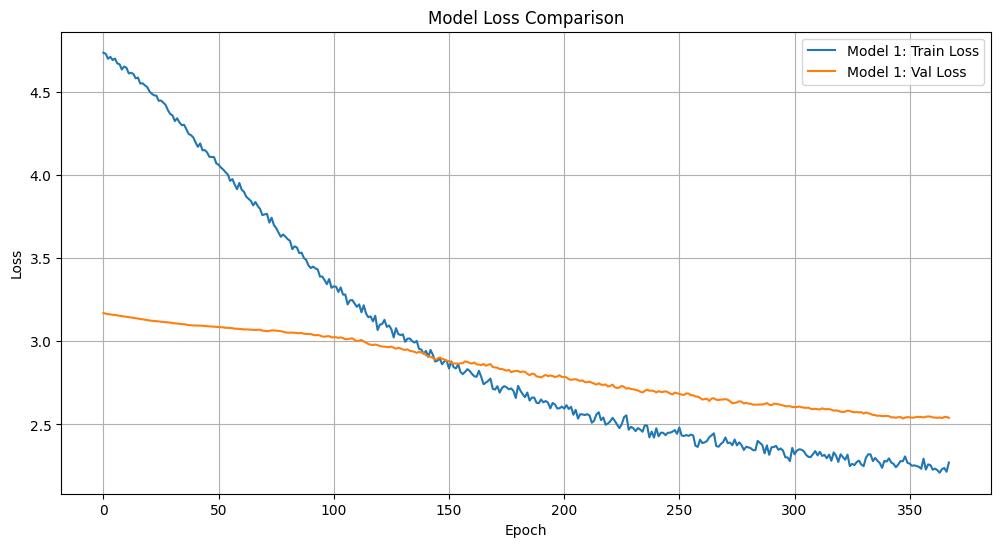

In [249]:
plt.figure(figsize=(12, 6))

# Model 1
plt.plot(history.history['loss'], label='Model 1: Train Loss', linestyle='-')
plt.plot(history.history['val_loss'], label='Model 1: Val Loss', linestyle='-')

plt.title('Model Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

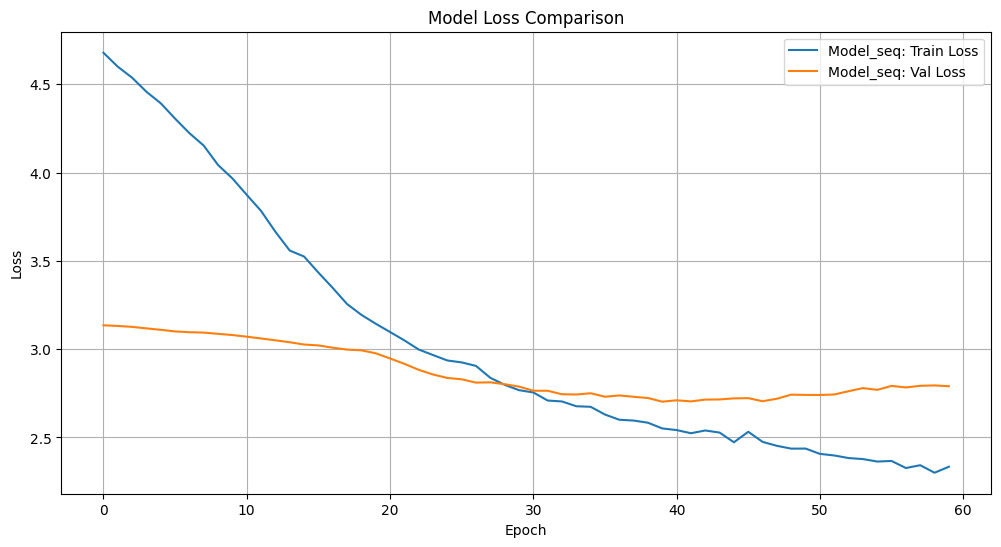

In [250]:
plt.figure(figsize=(12, 6))
plt.plot(history2.history['loss'], label='Model_seq: Train Loss', linestyle='-')
plt.plot(history2.history['val_loss'], label='Model_seq: Val Loss', linestyle='-')

plt.title('Model Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

* Both models have approximate performance .

### Evaluation

In [251]:
from tensorflow.keras.models import load_model
# Load best model
best_model = load_model('/content/drive/MyDrive/NLP/best_model_seq.keras',
                          custom_objects={'weighted_mae': weighted_rmse} )

In [252]:
y_pred = best_model.predict(X_test, verbose=0)  # Predict future sequences
y_pred = y_pred.reshape(y_pred.shape[0], forecast_horizon, n_features_out)
y_pred = y_pred.astype('int')
y_test = y_test.astype('int')
y_pred = np.maximum(y_pred, 0)


Combined shape: (10, 10, 18)
Root Mean Squared Error: 2.559079695689231
Mean Absolute Error: 1.3022222222222224

Visualizing results for Day 1 of 10


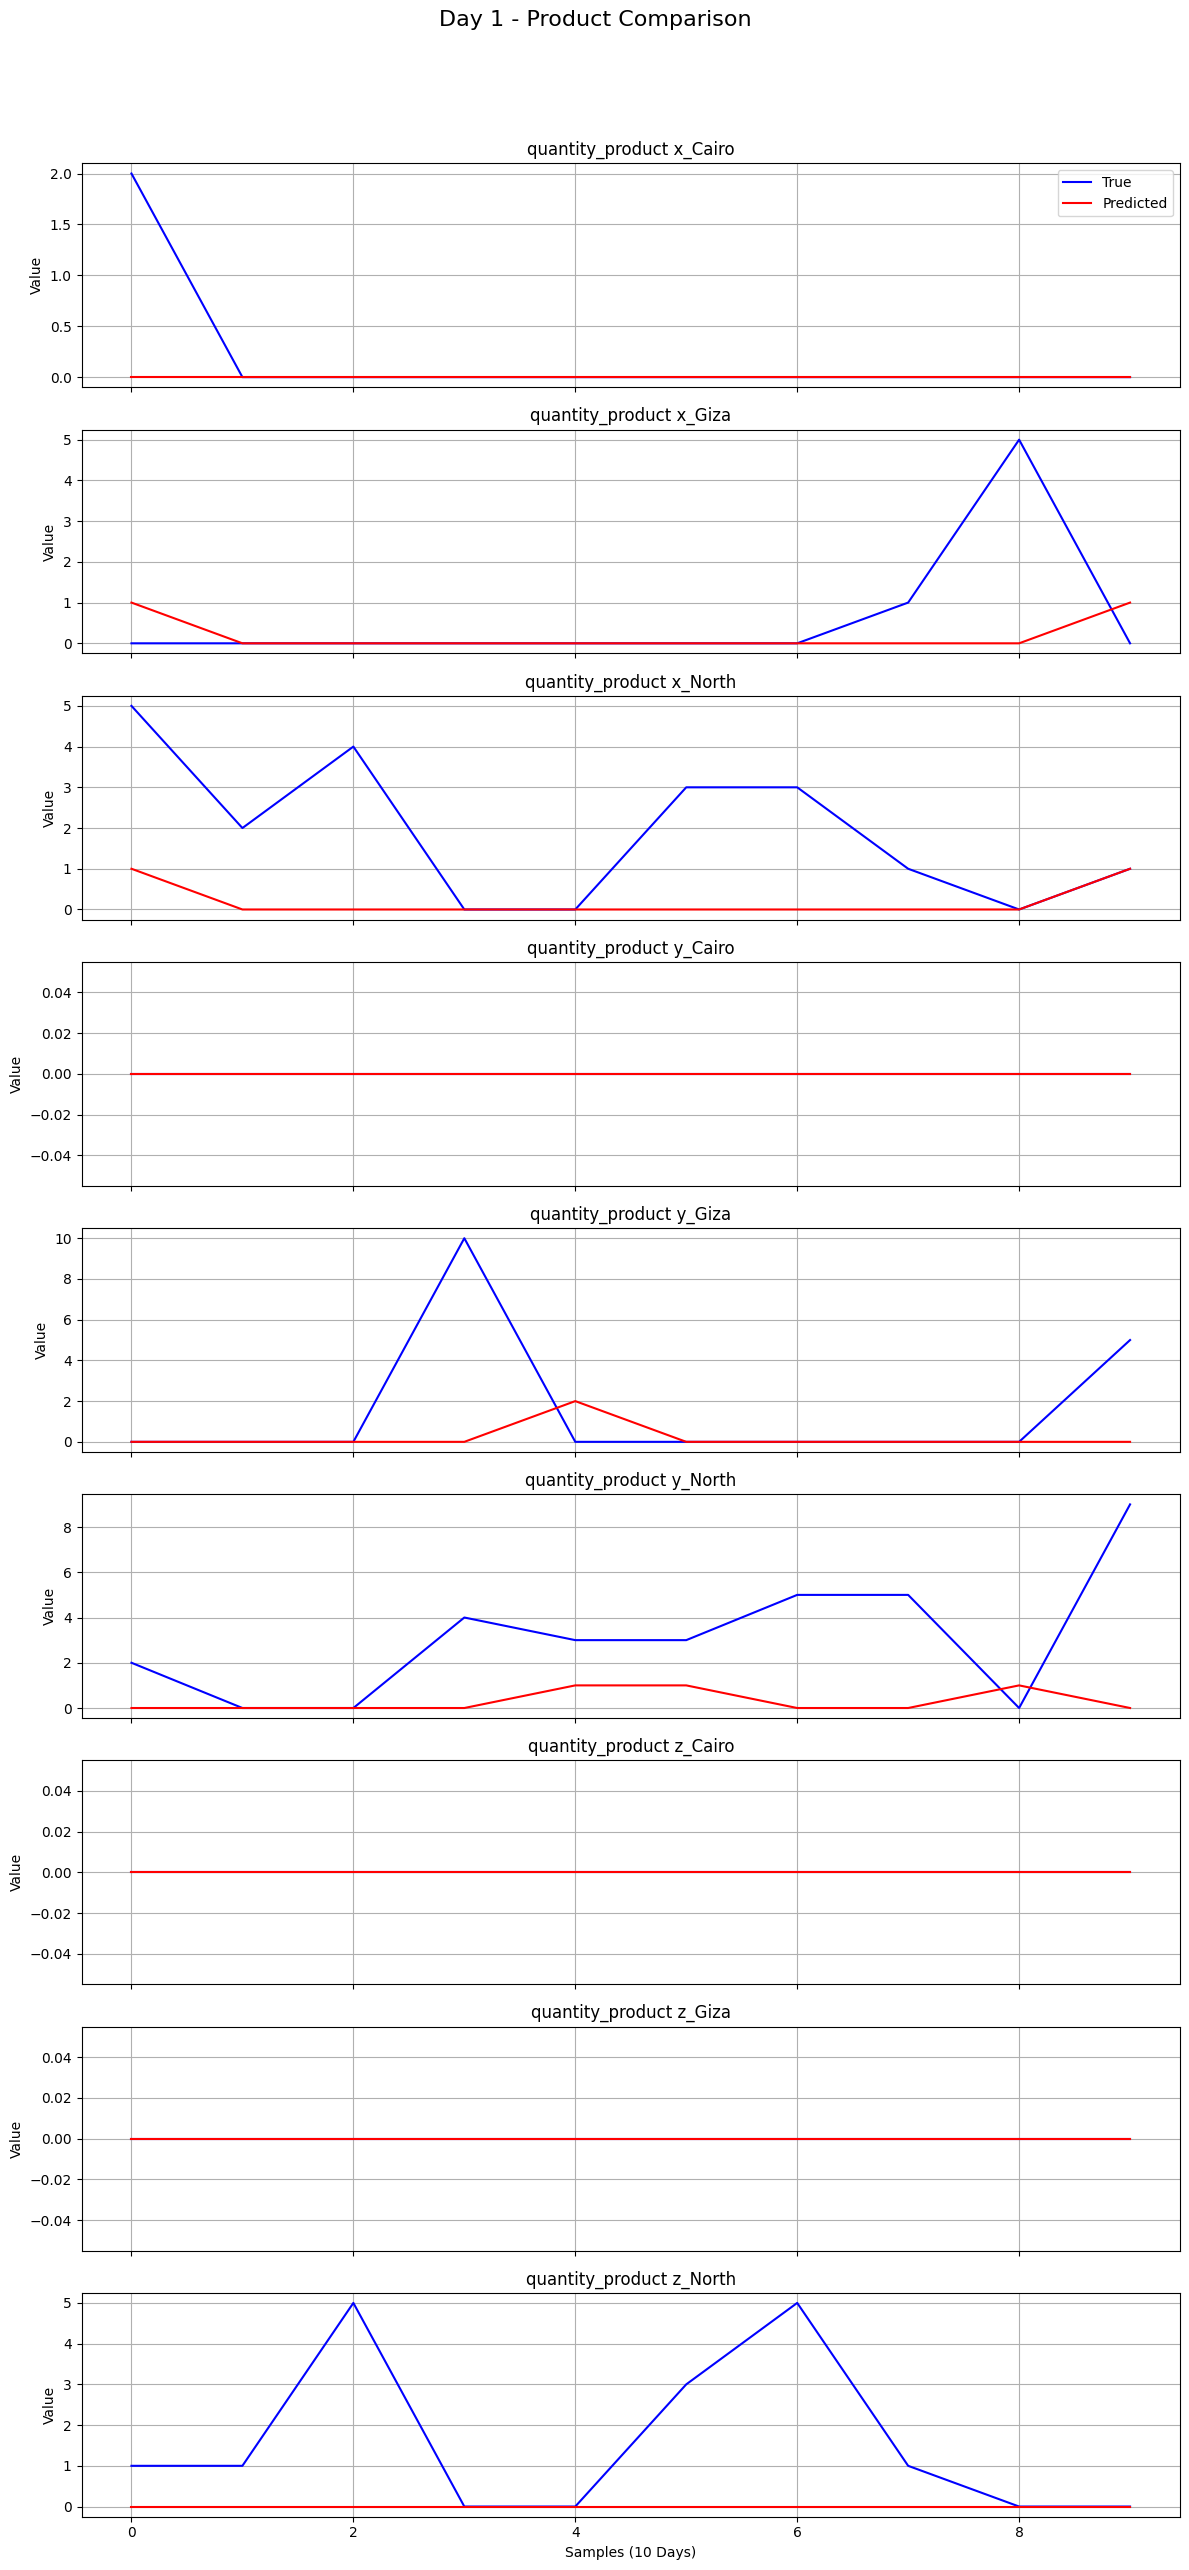


Visualizing results for Day 2 of 10


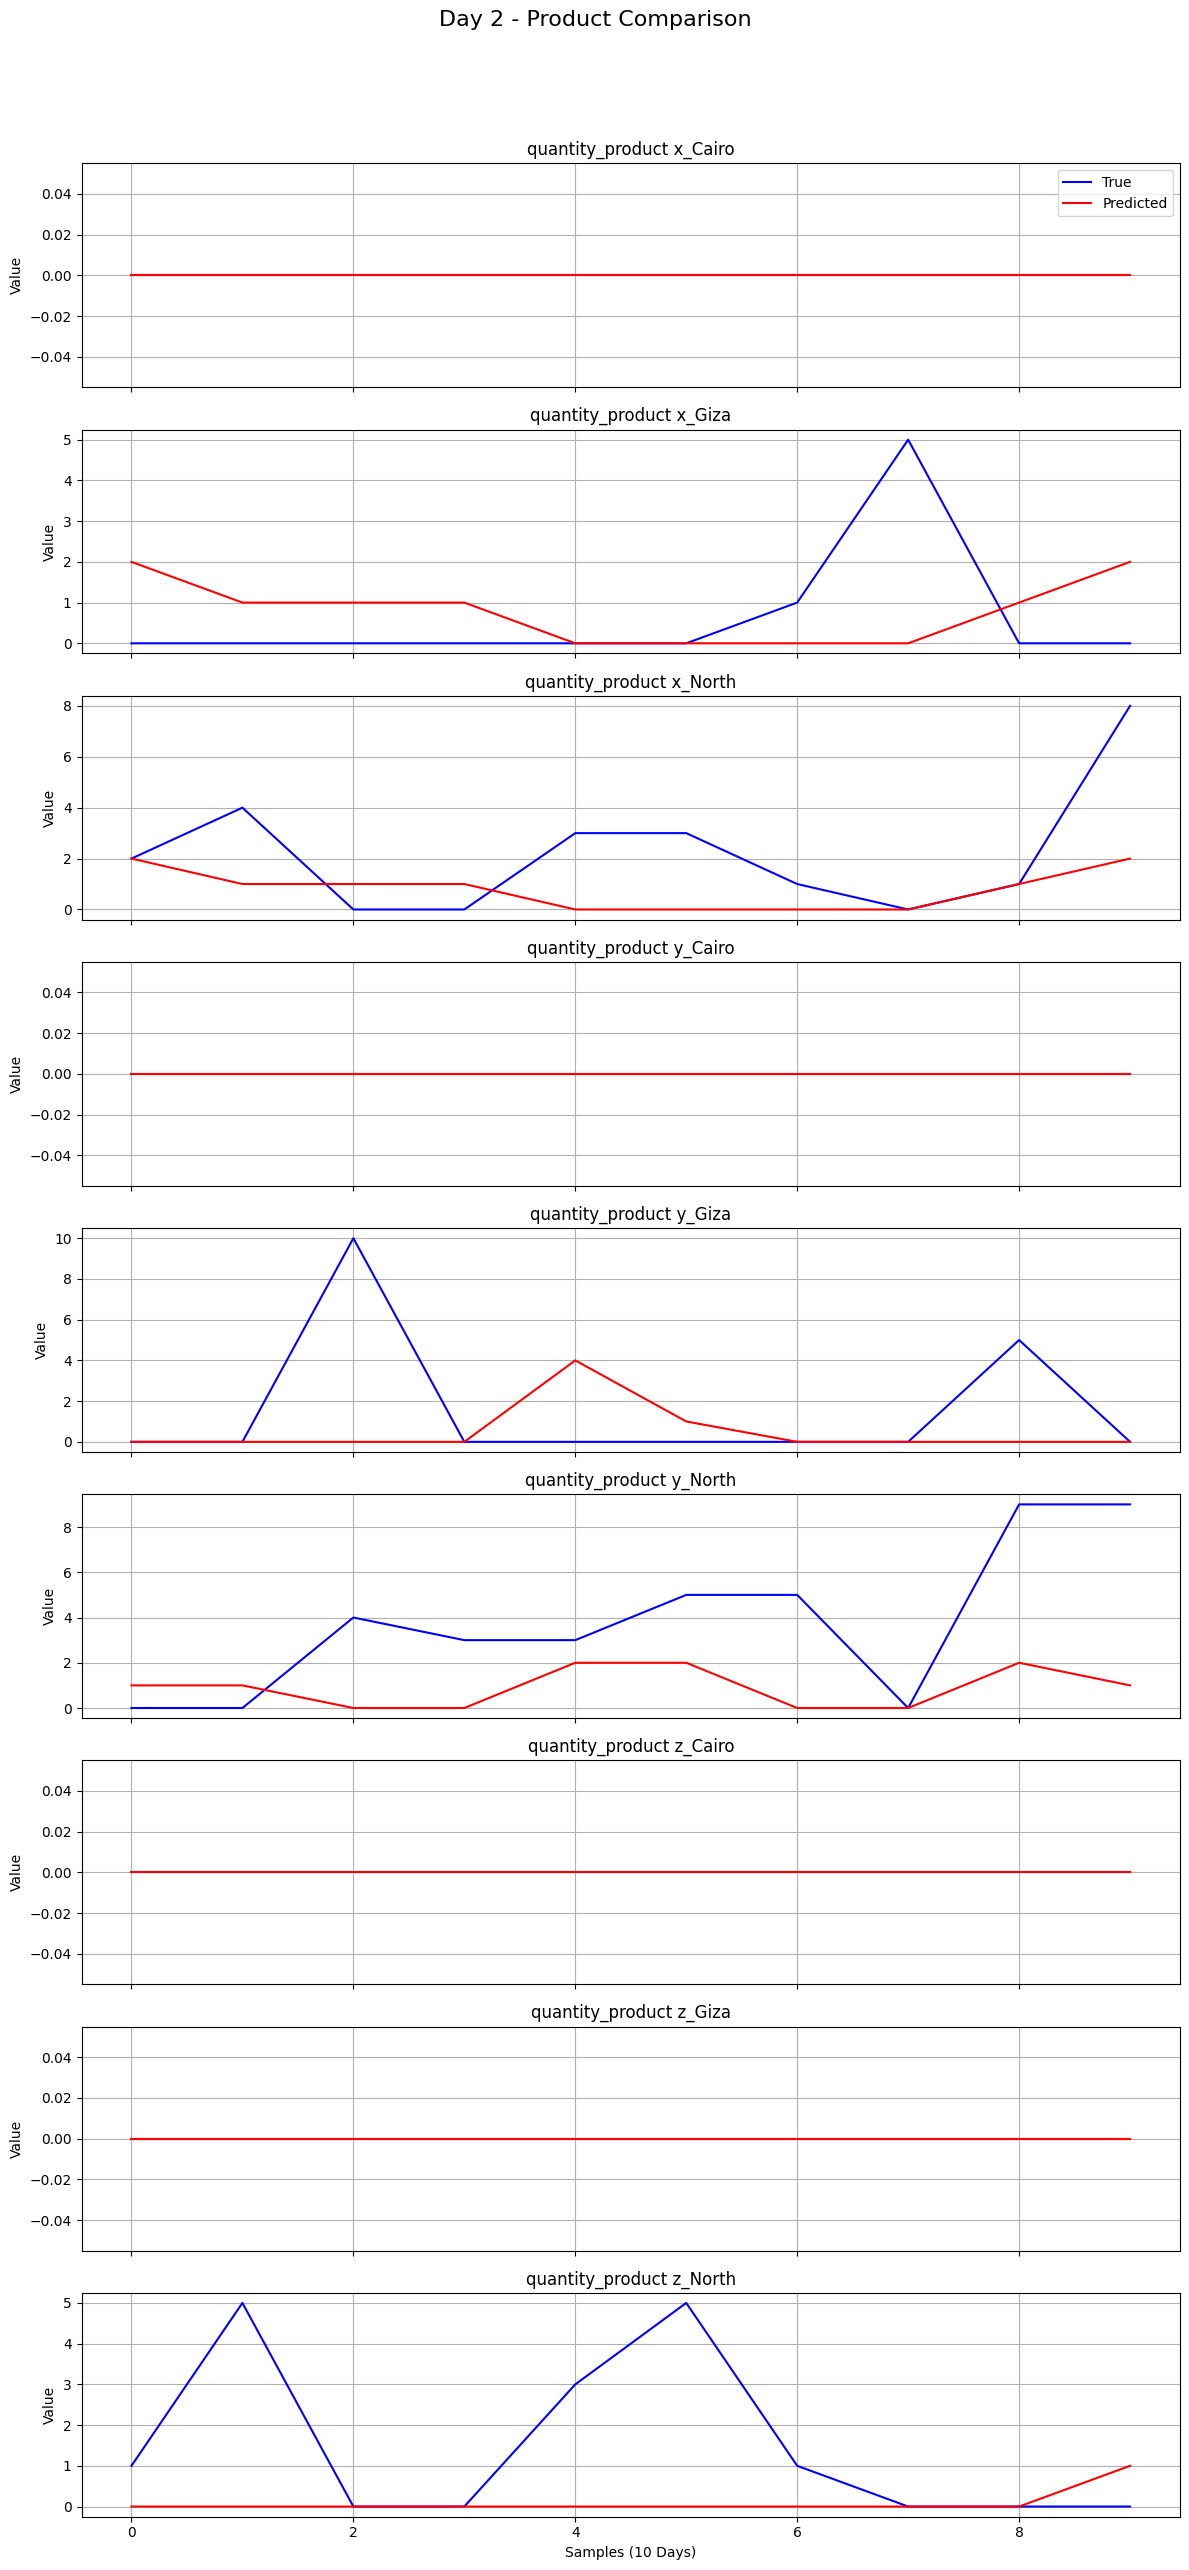


Visualizing results for Day 3 of 10


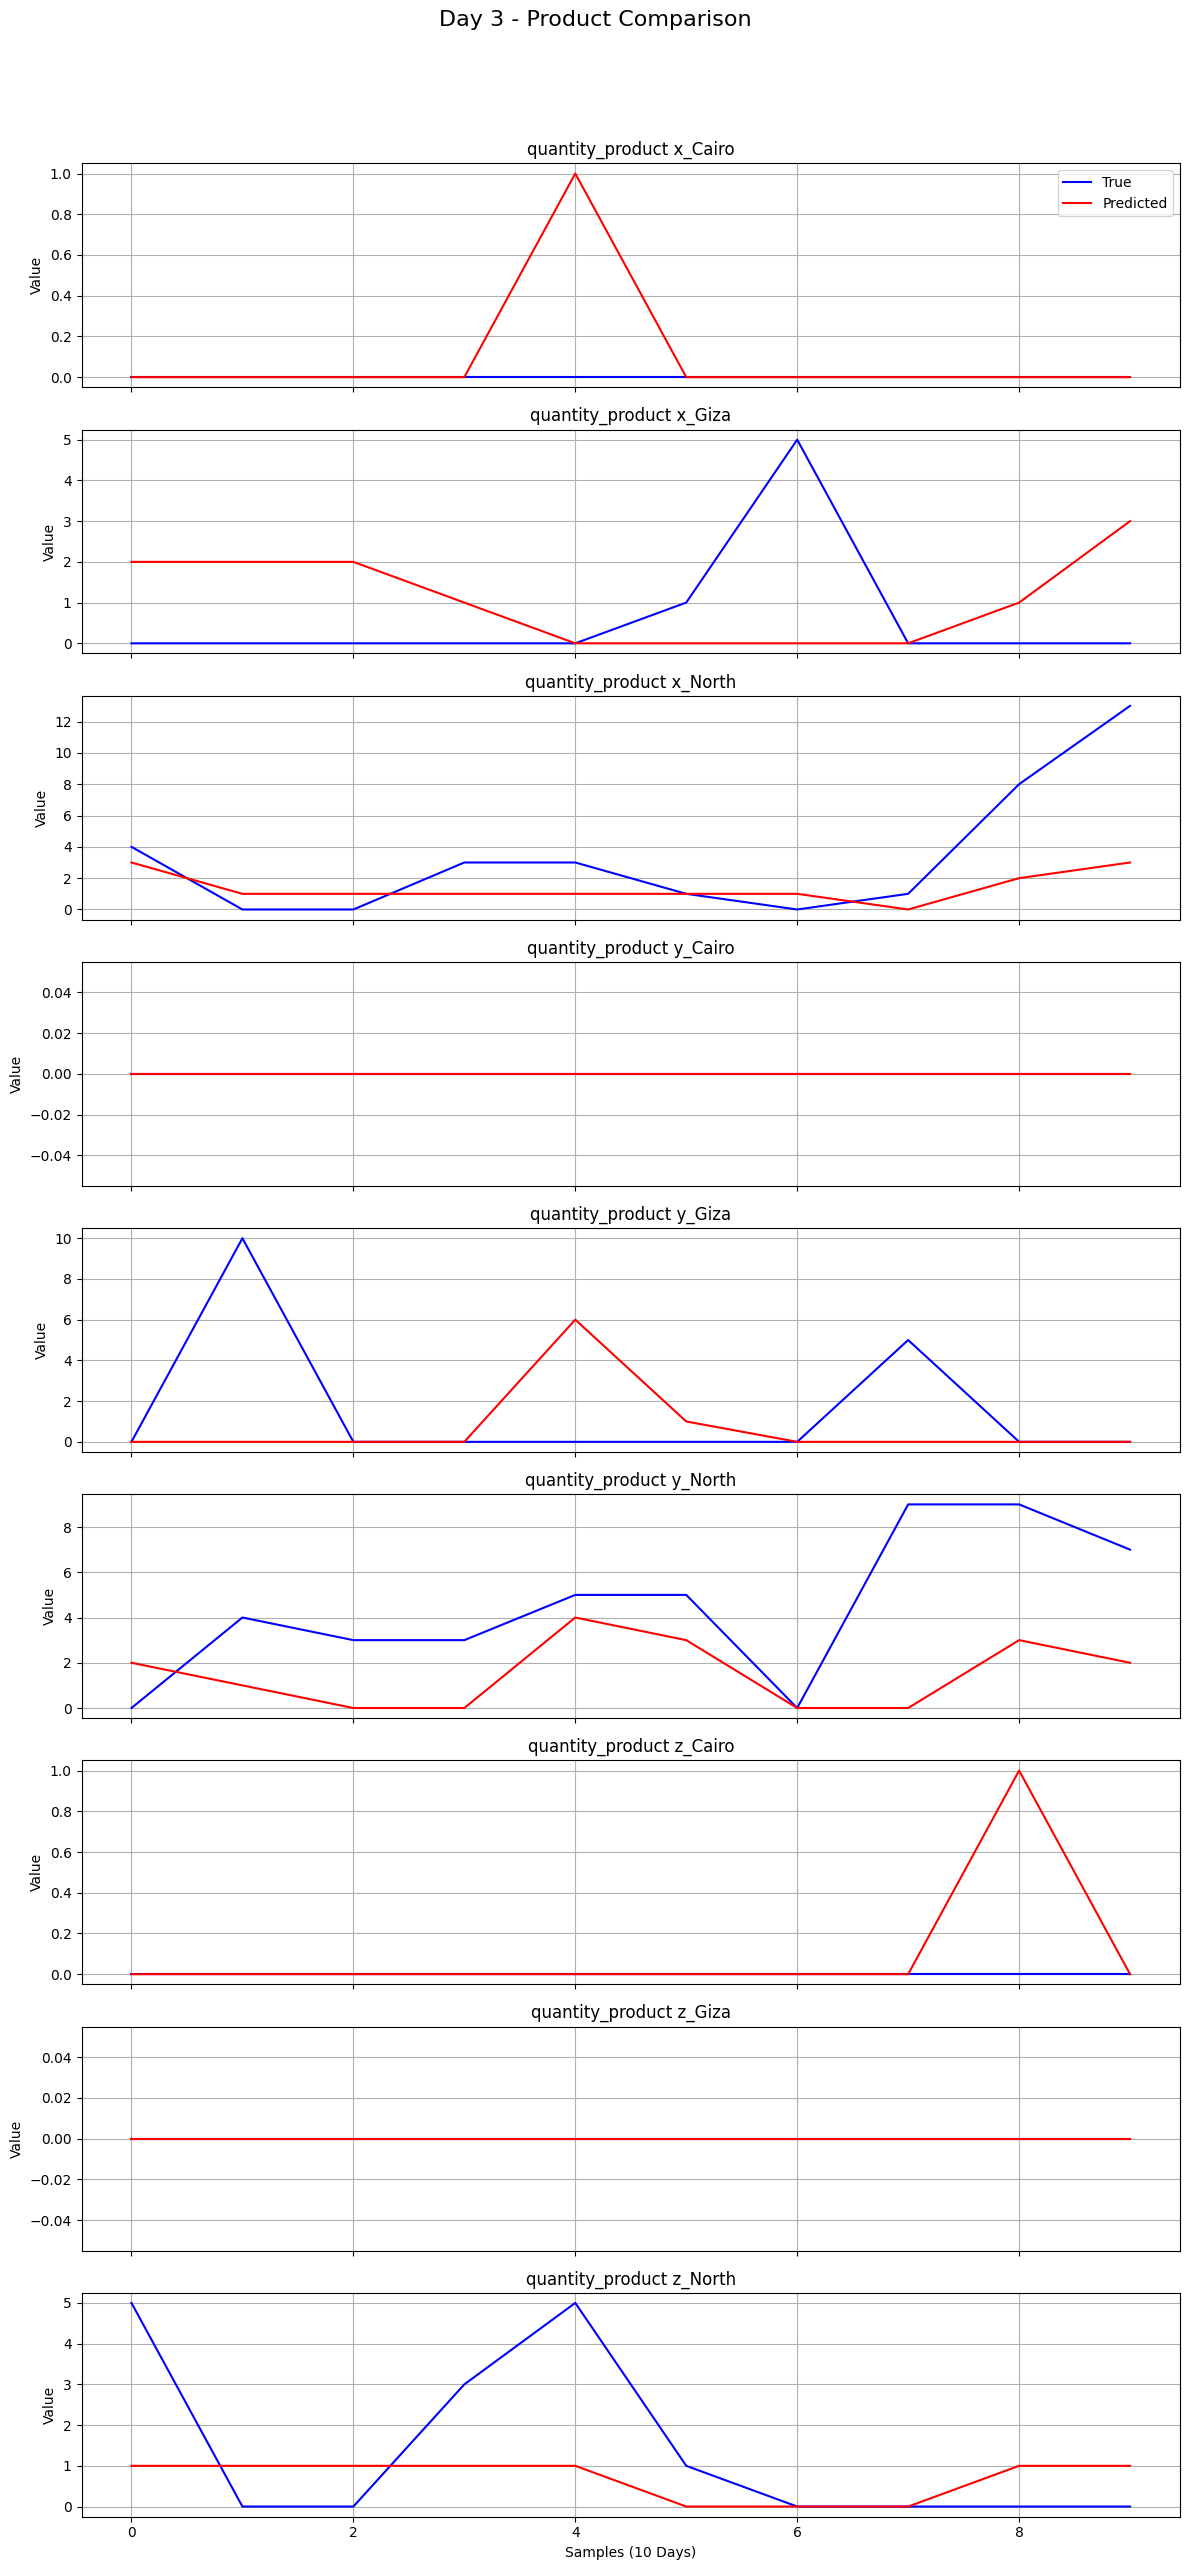


Visualizing results for Day 4 of 10


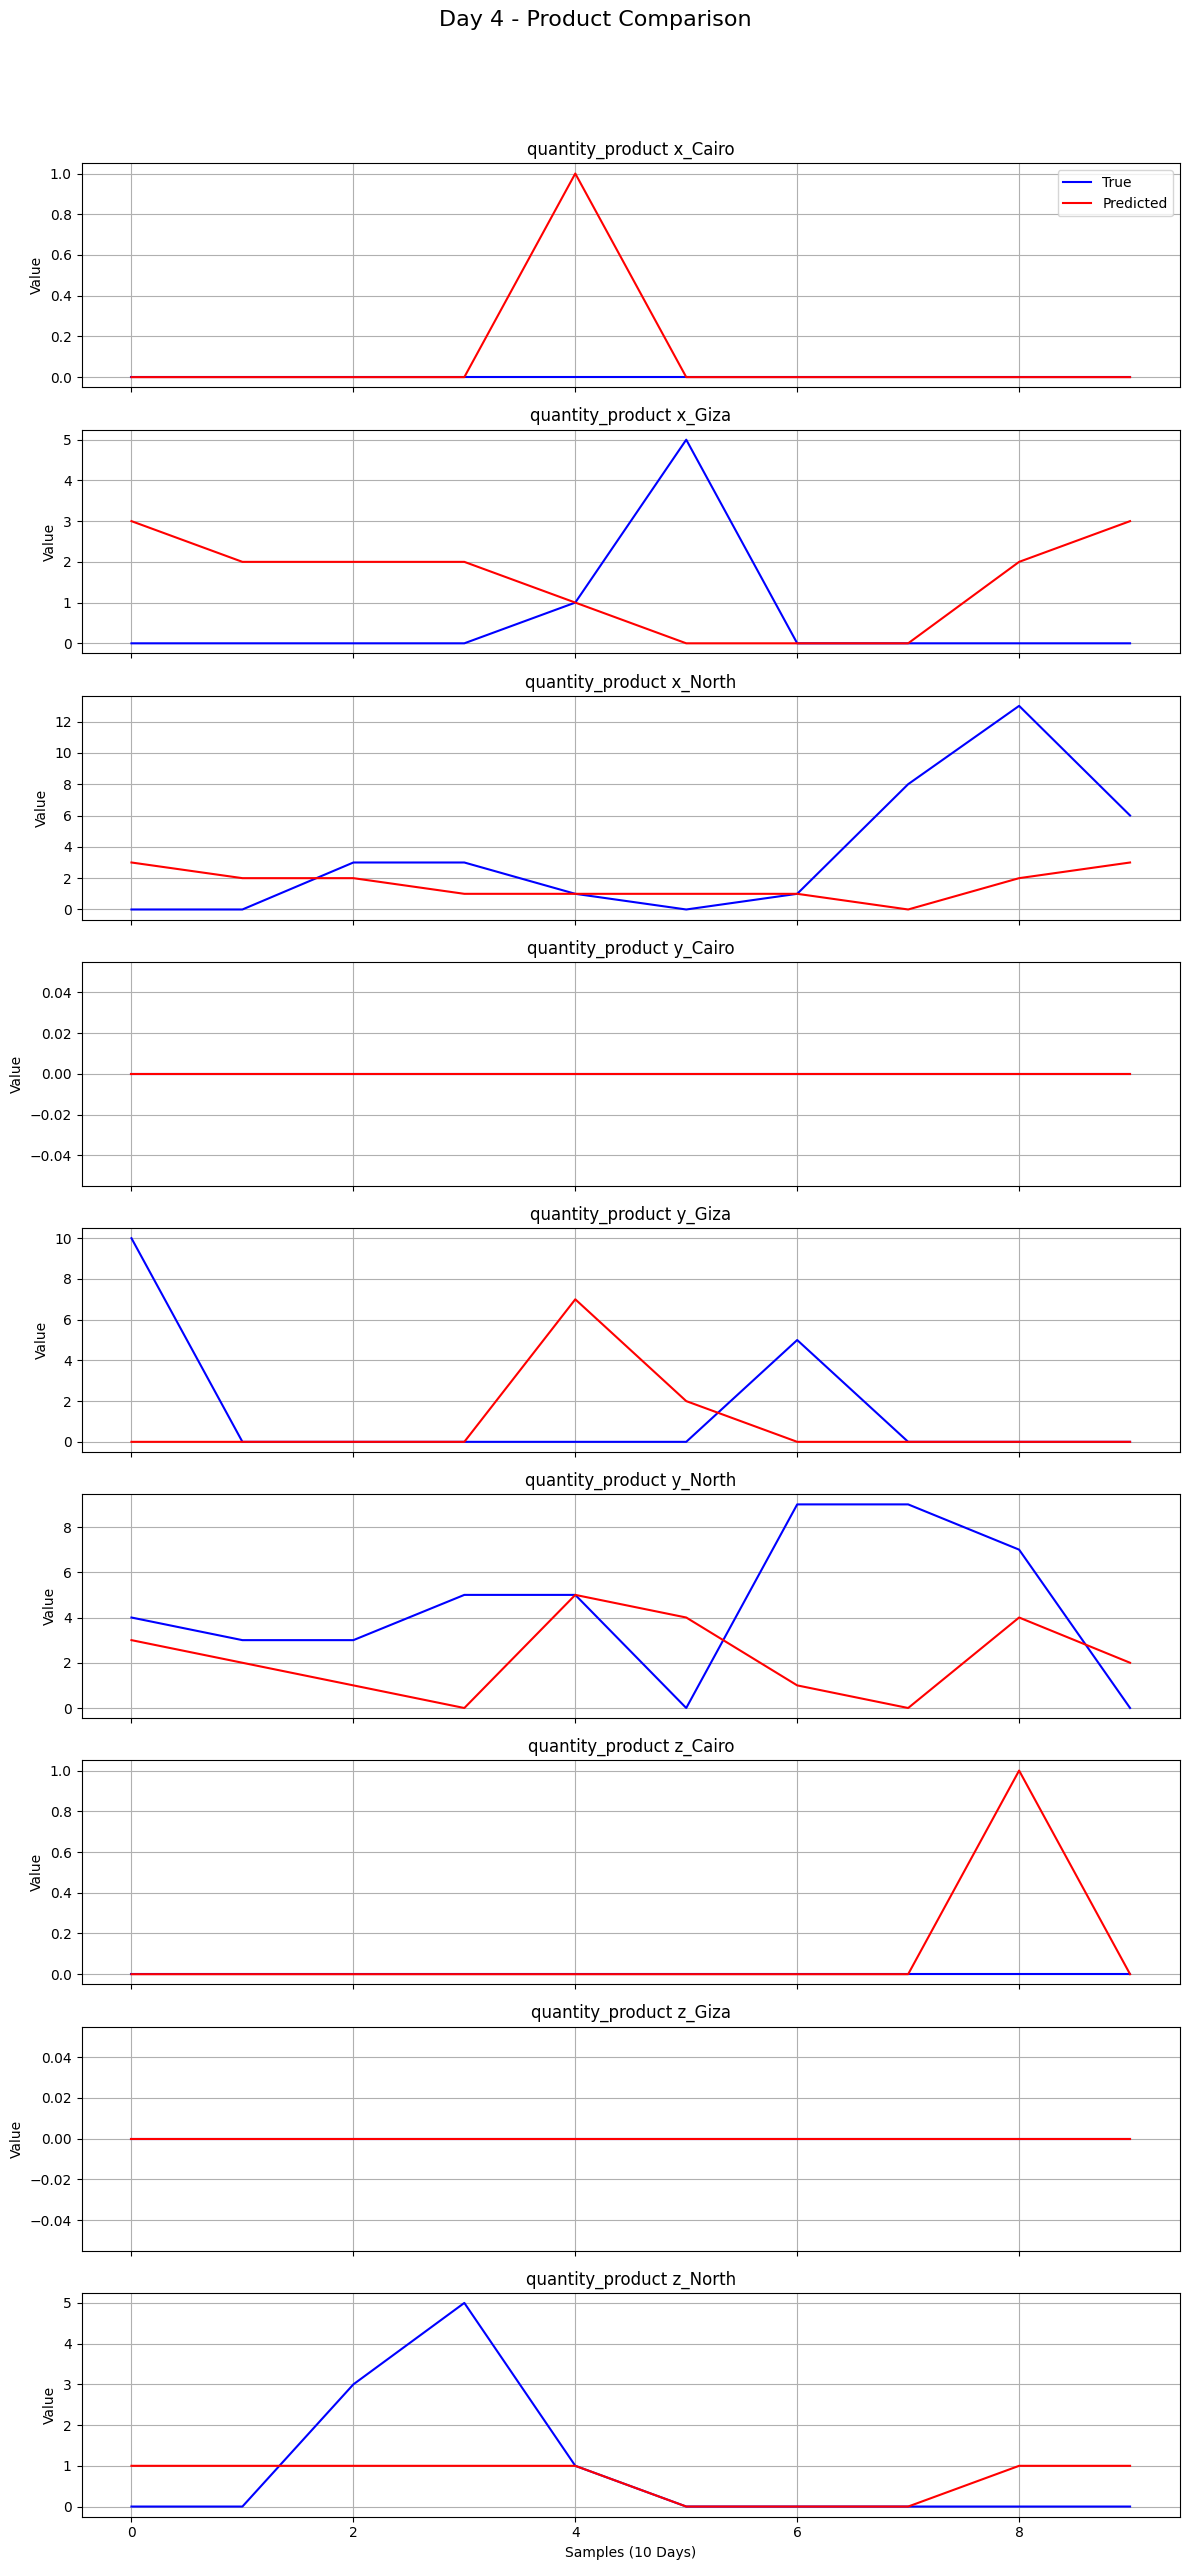


Visualizing results for Day 5 of 10


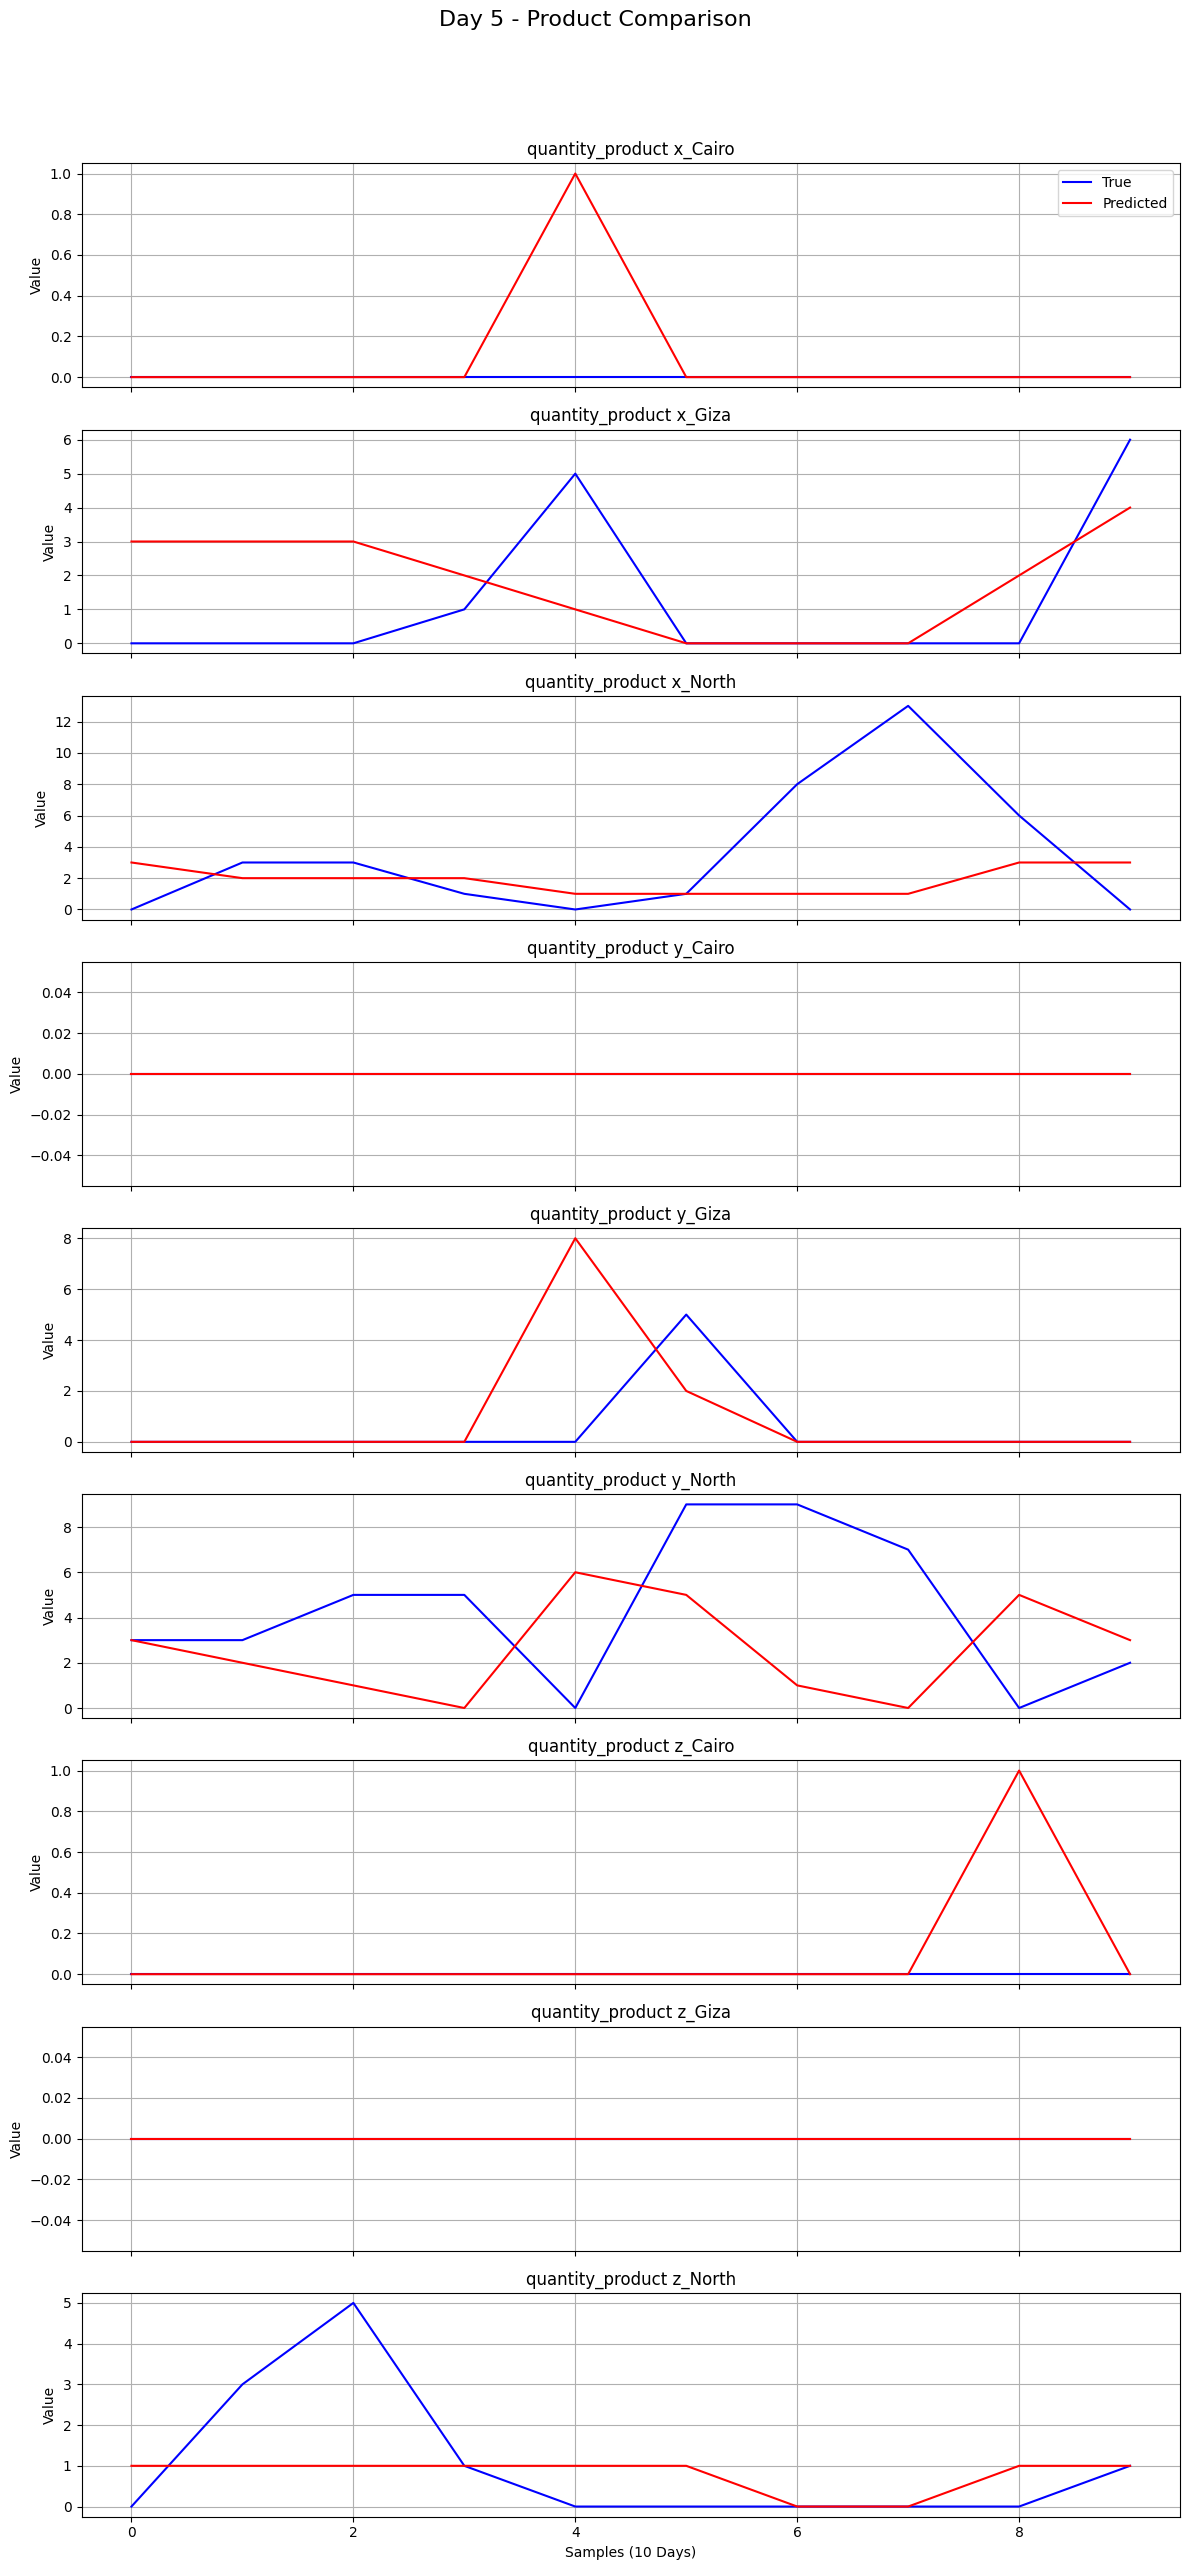


Visualizing results for Day 6 of 10


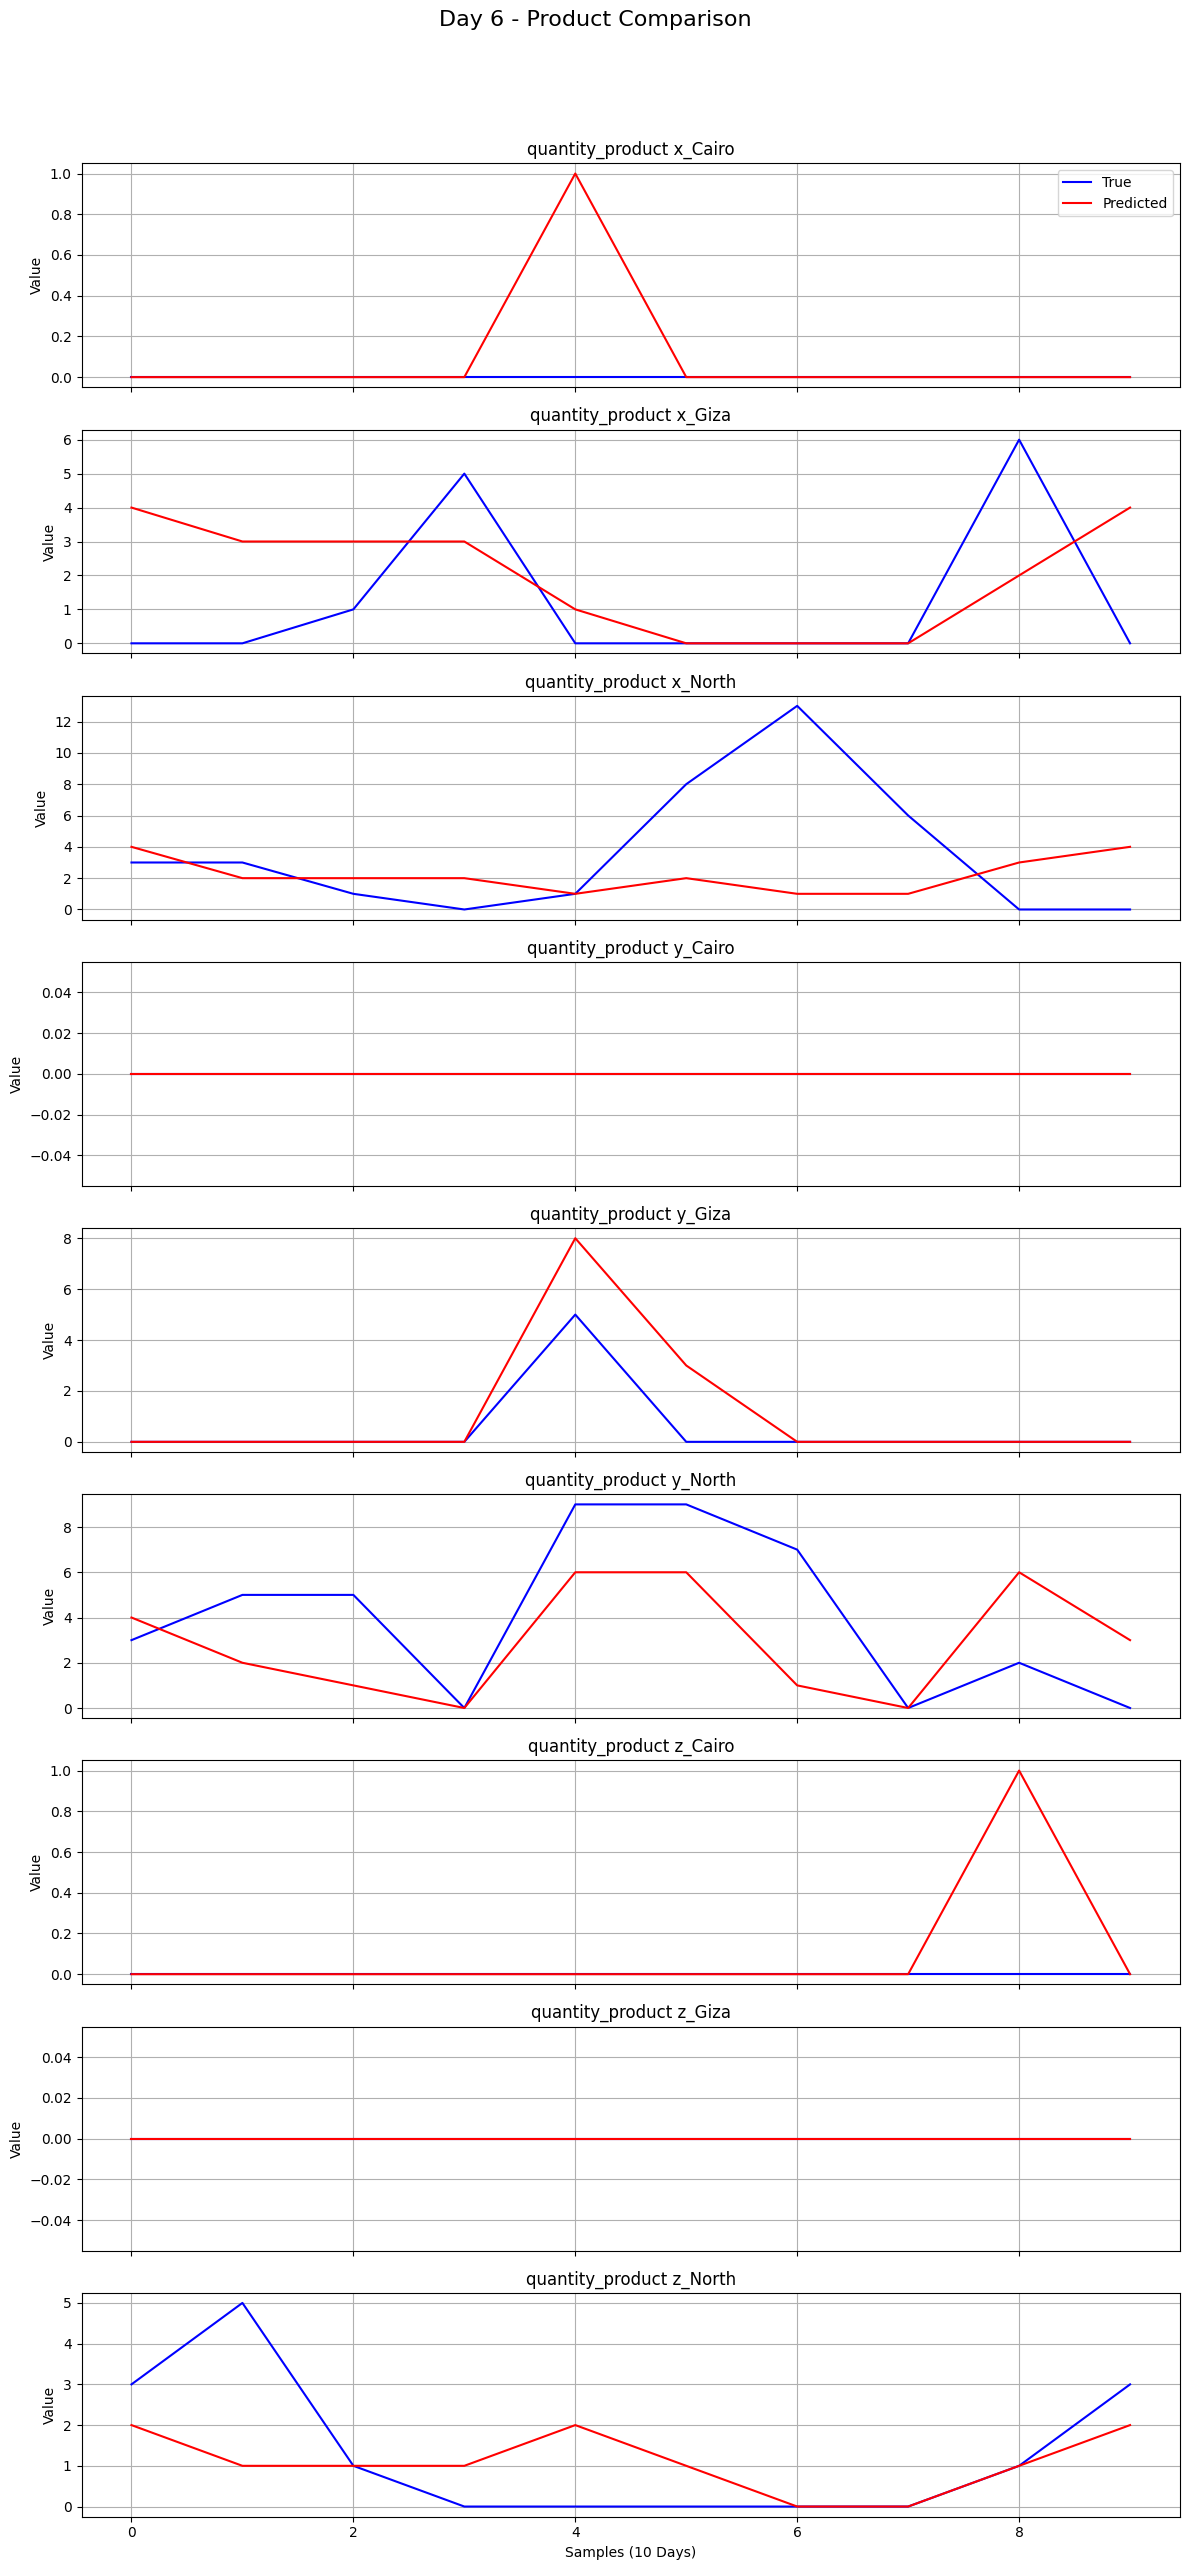


Visualizing results for Day 7 of 10


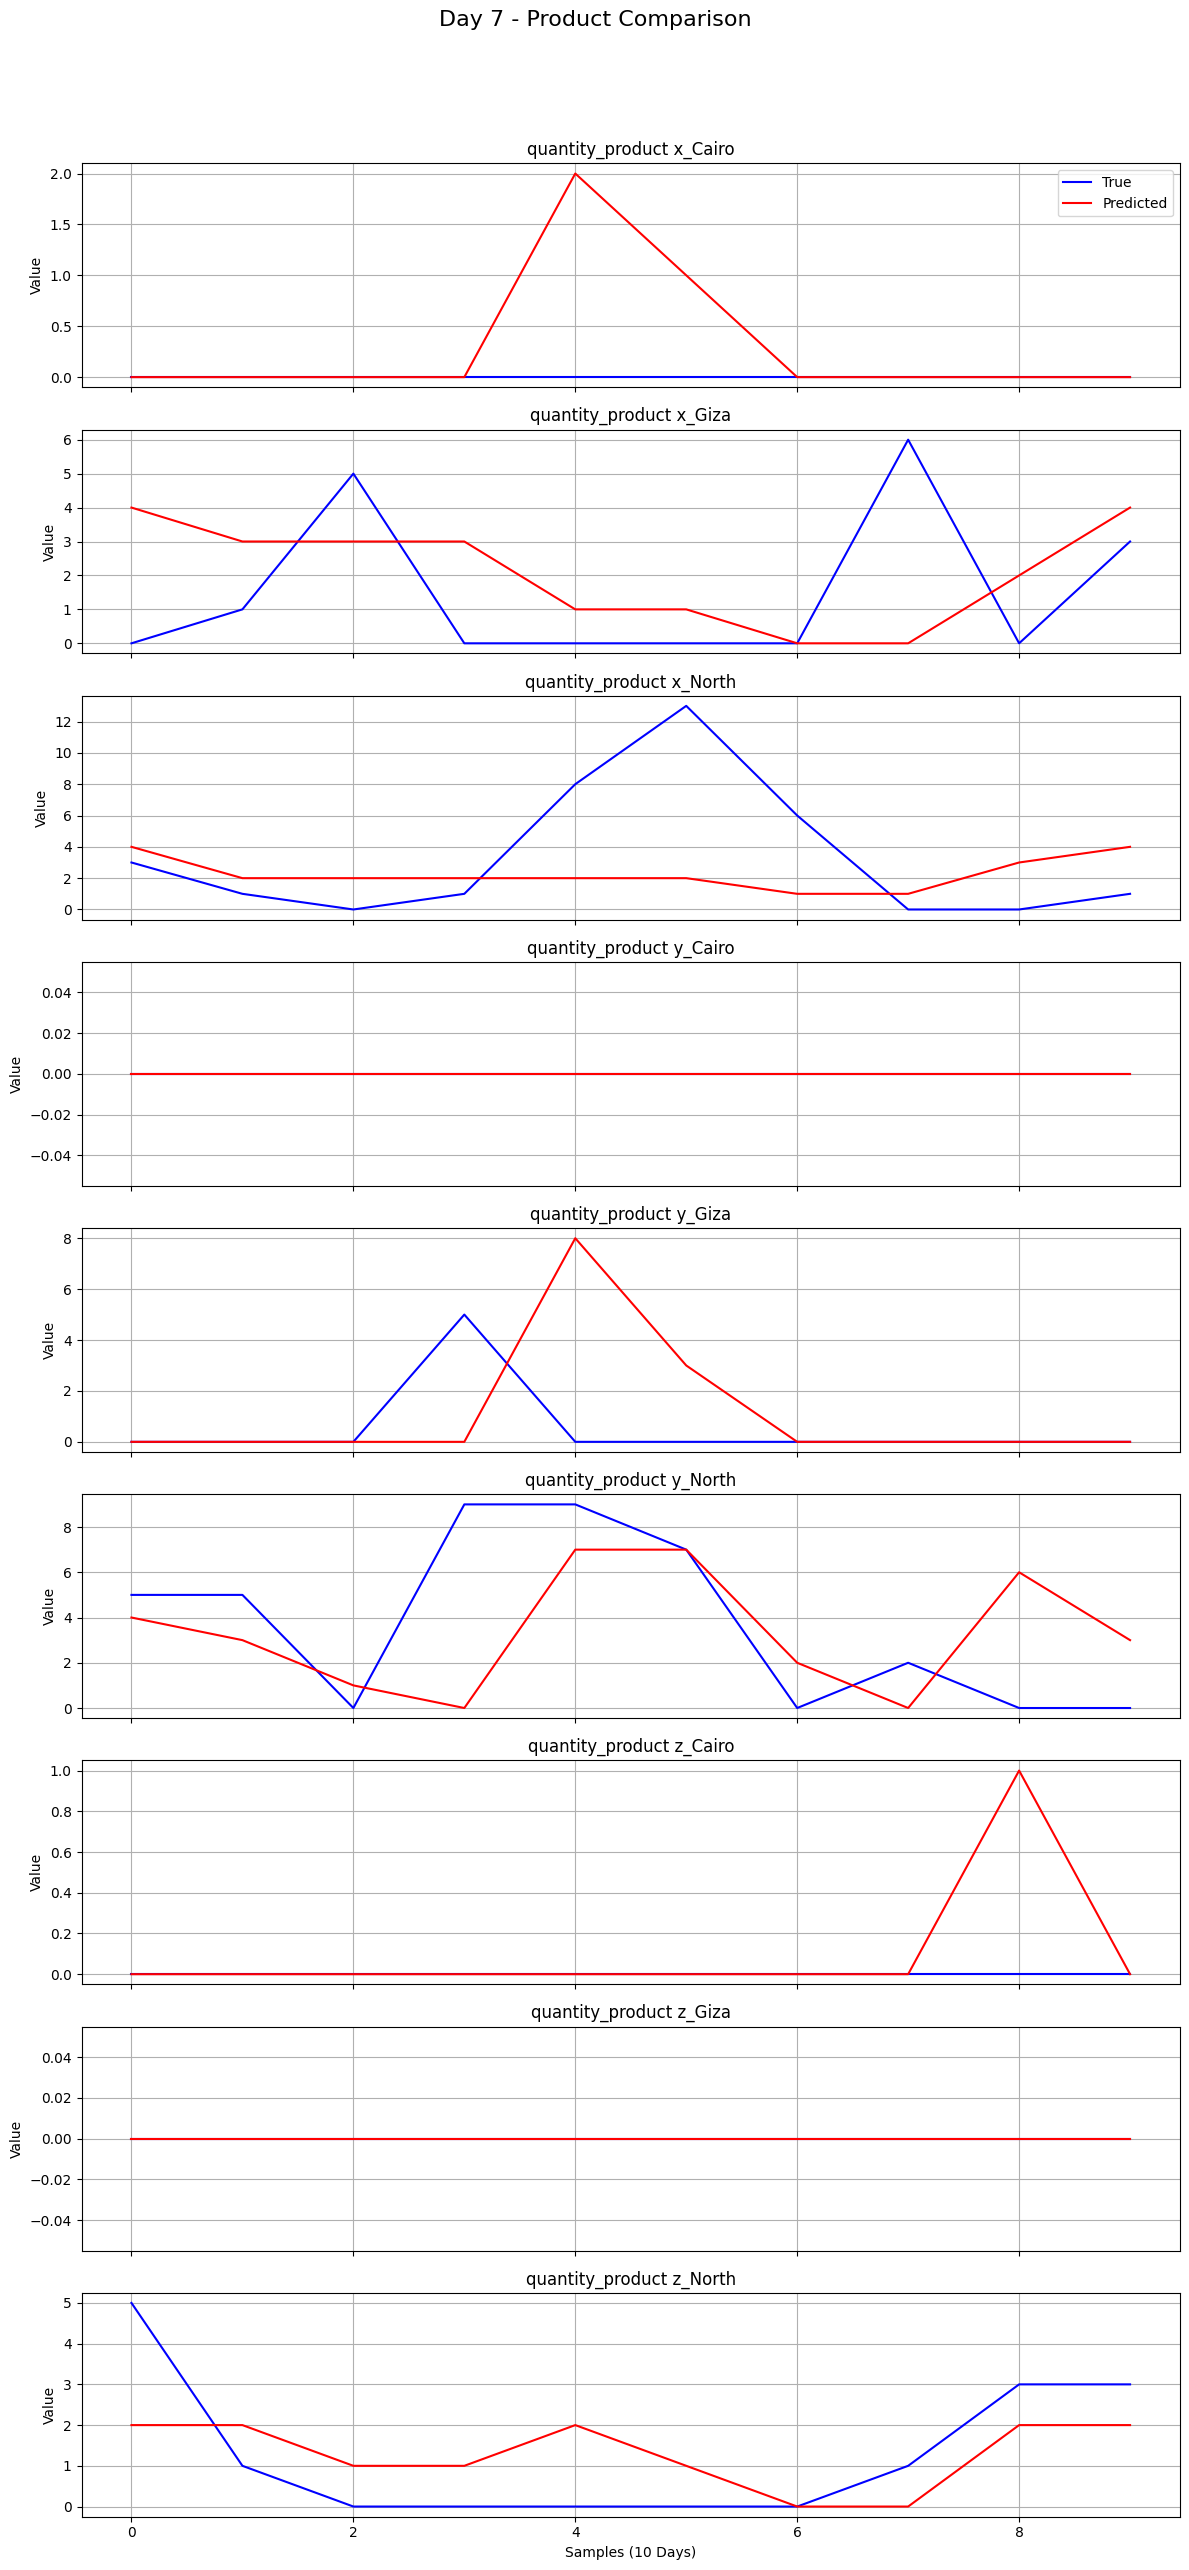


Visualizing results for Day 8 of 10


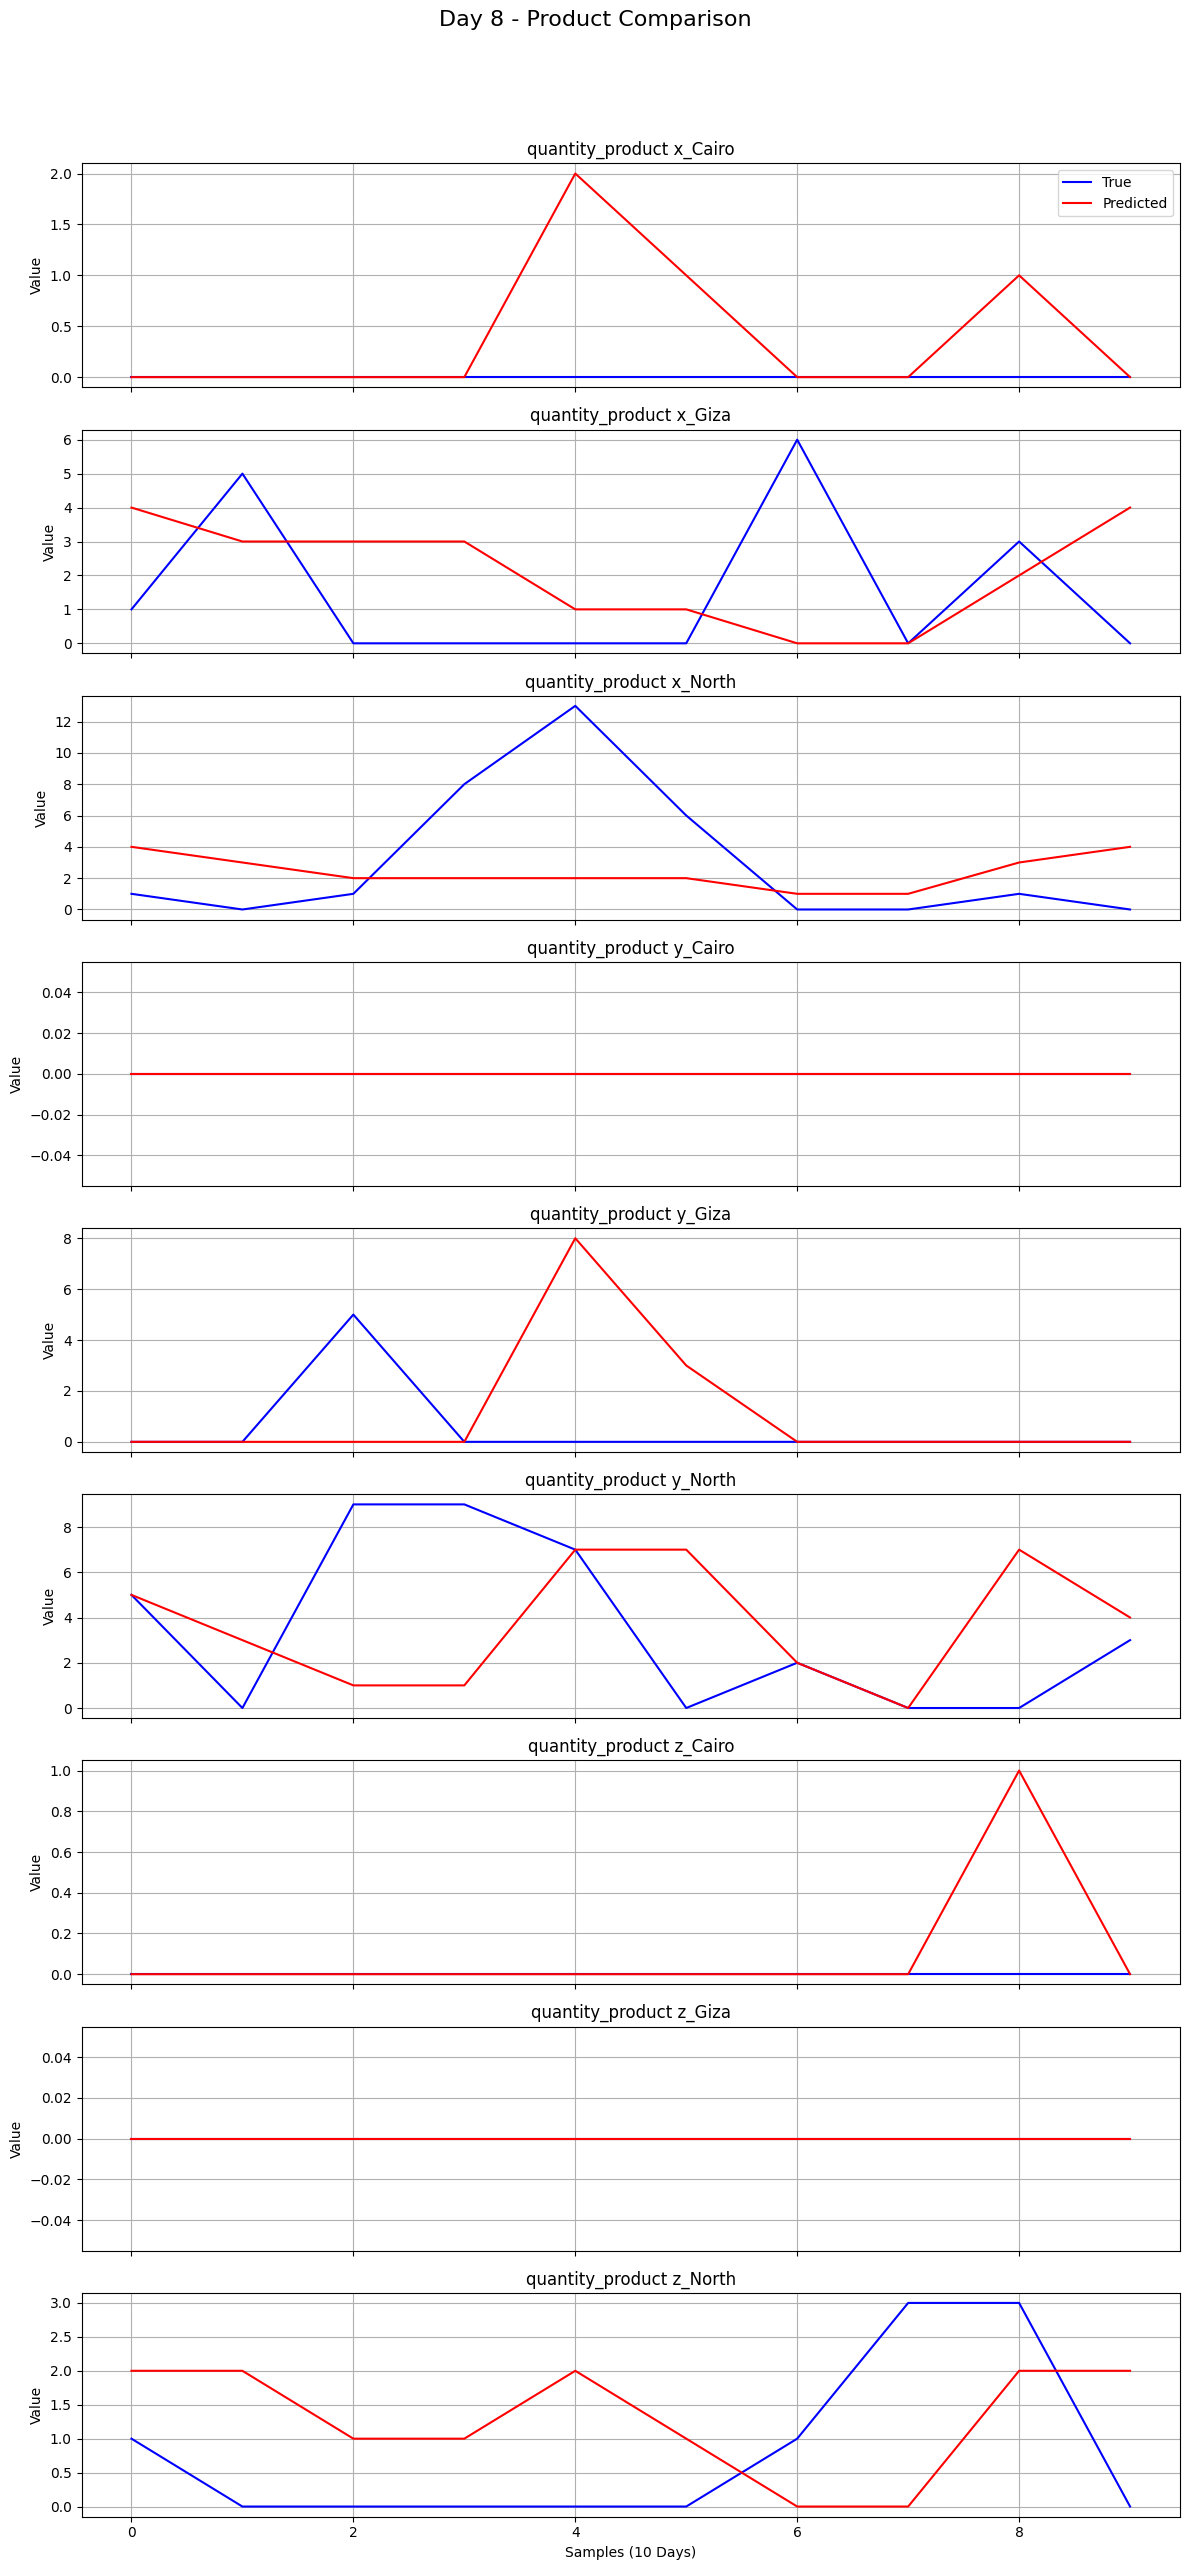


Visualizing results for Day 9 of 10


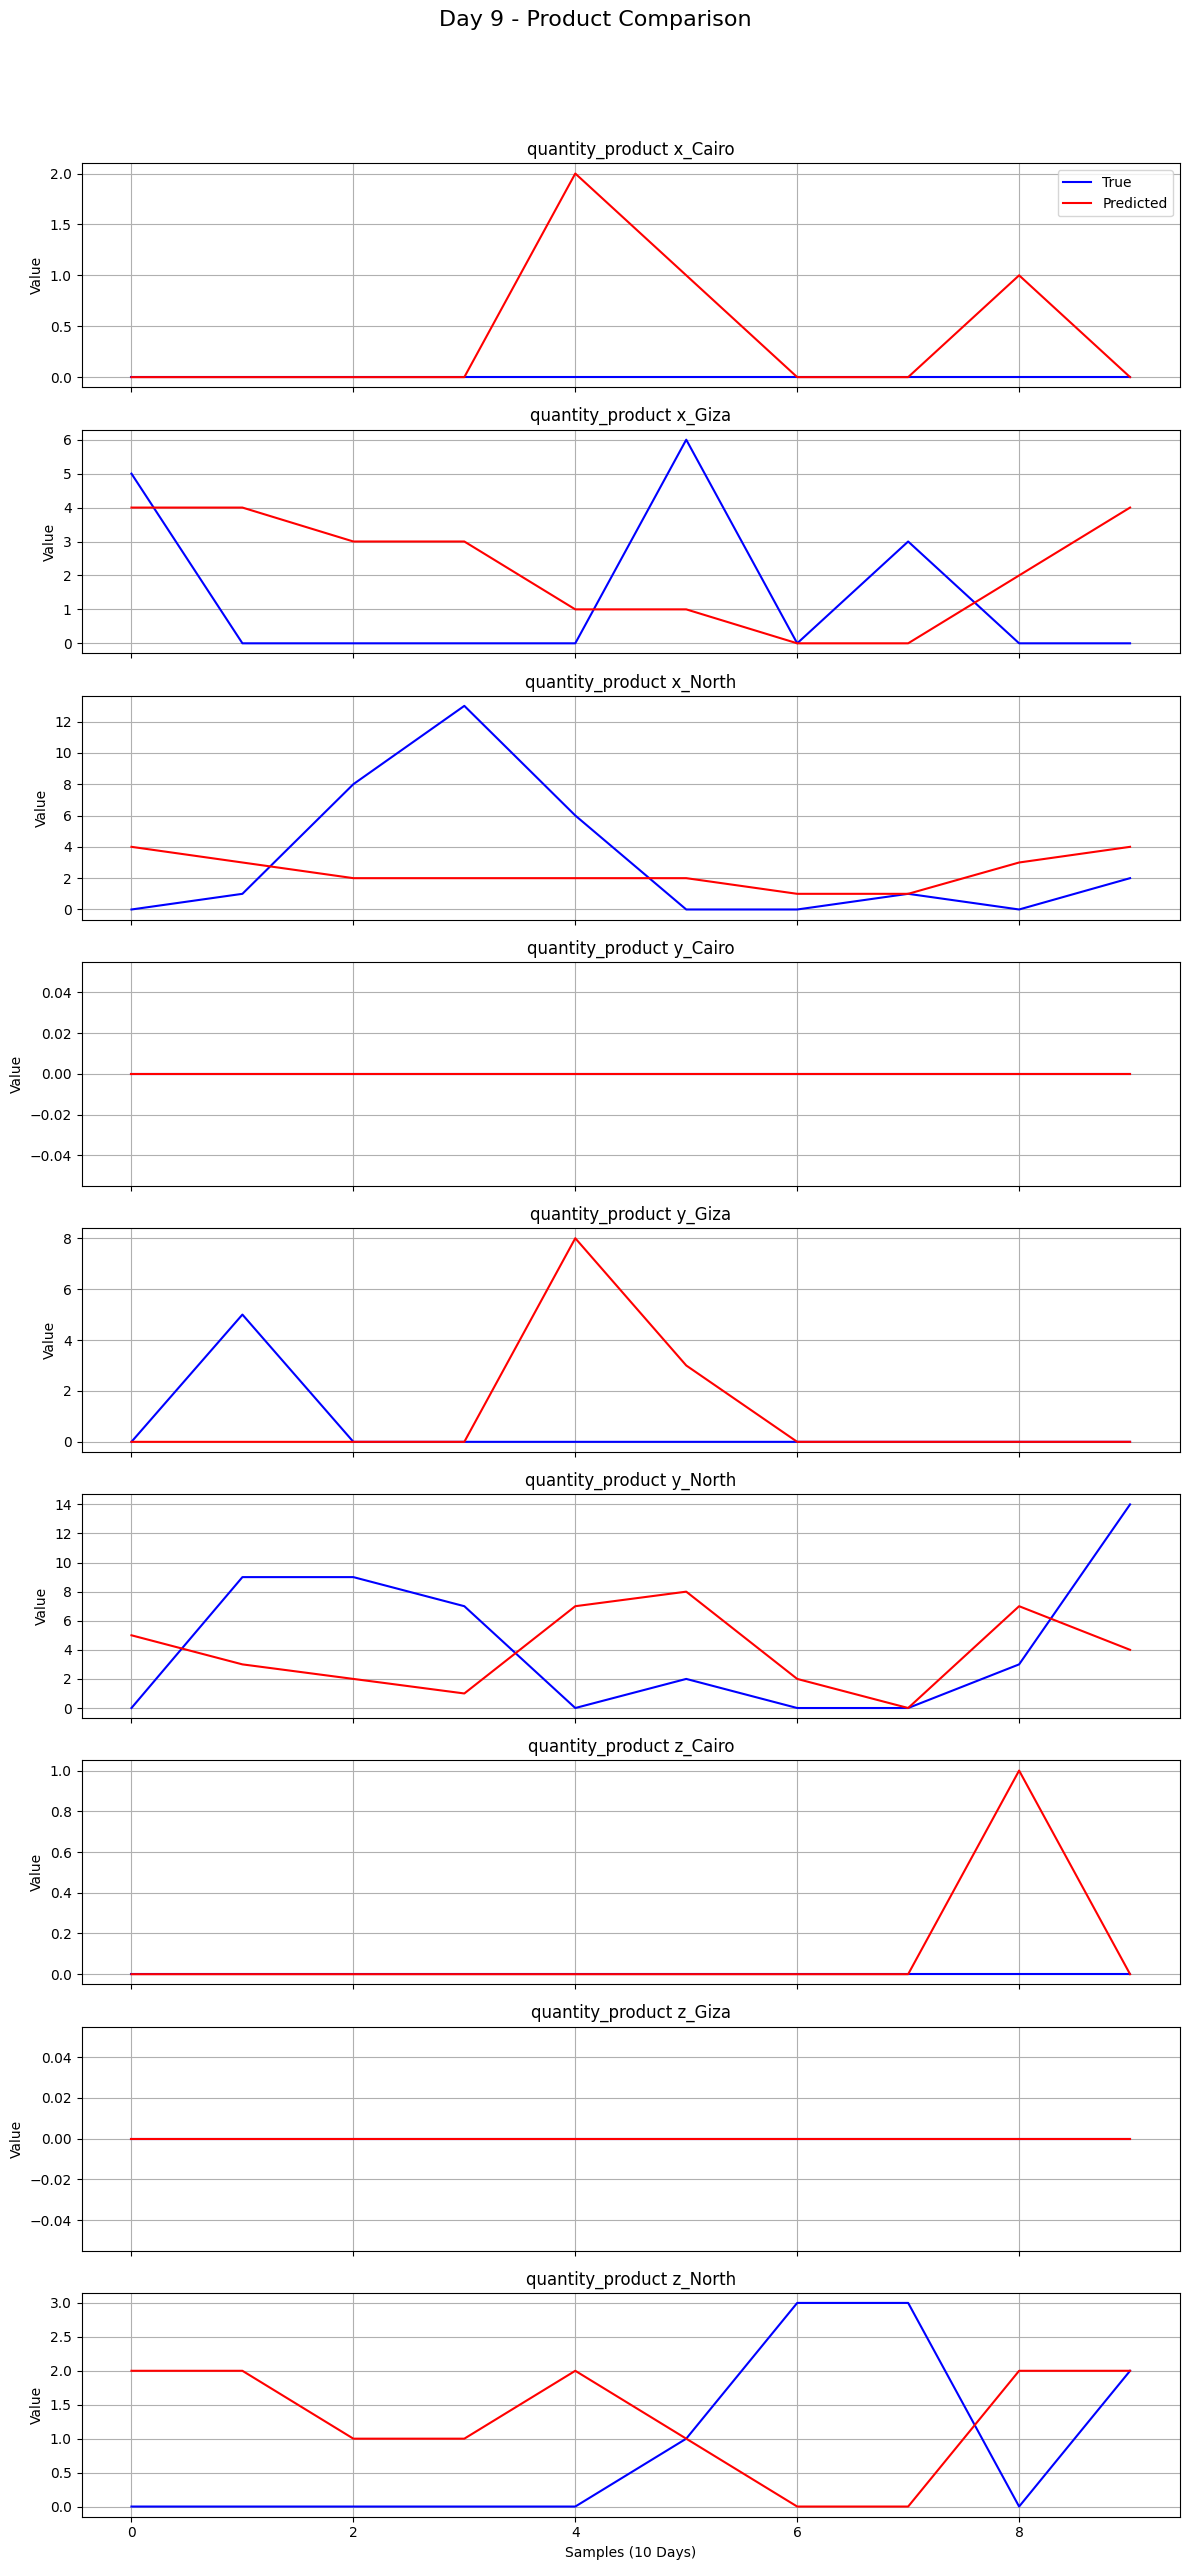


Visualizing results for Day 10 of 10


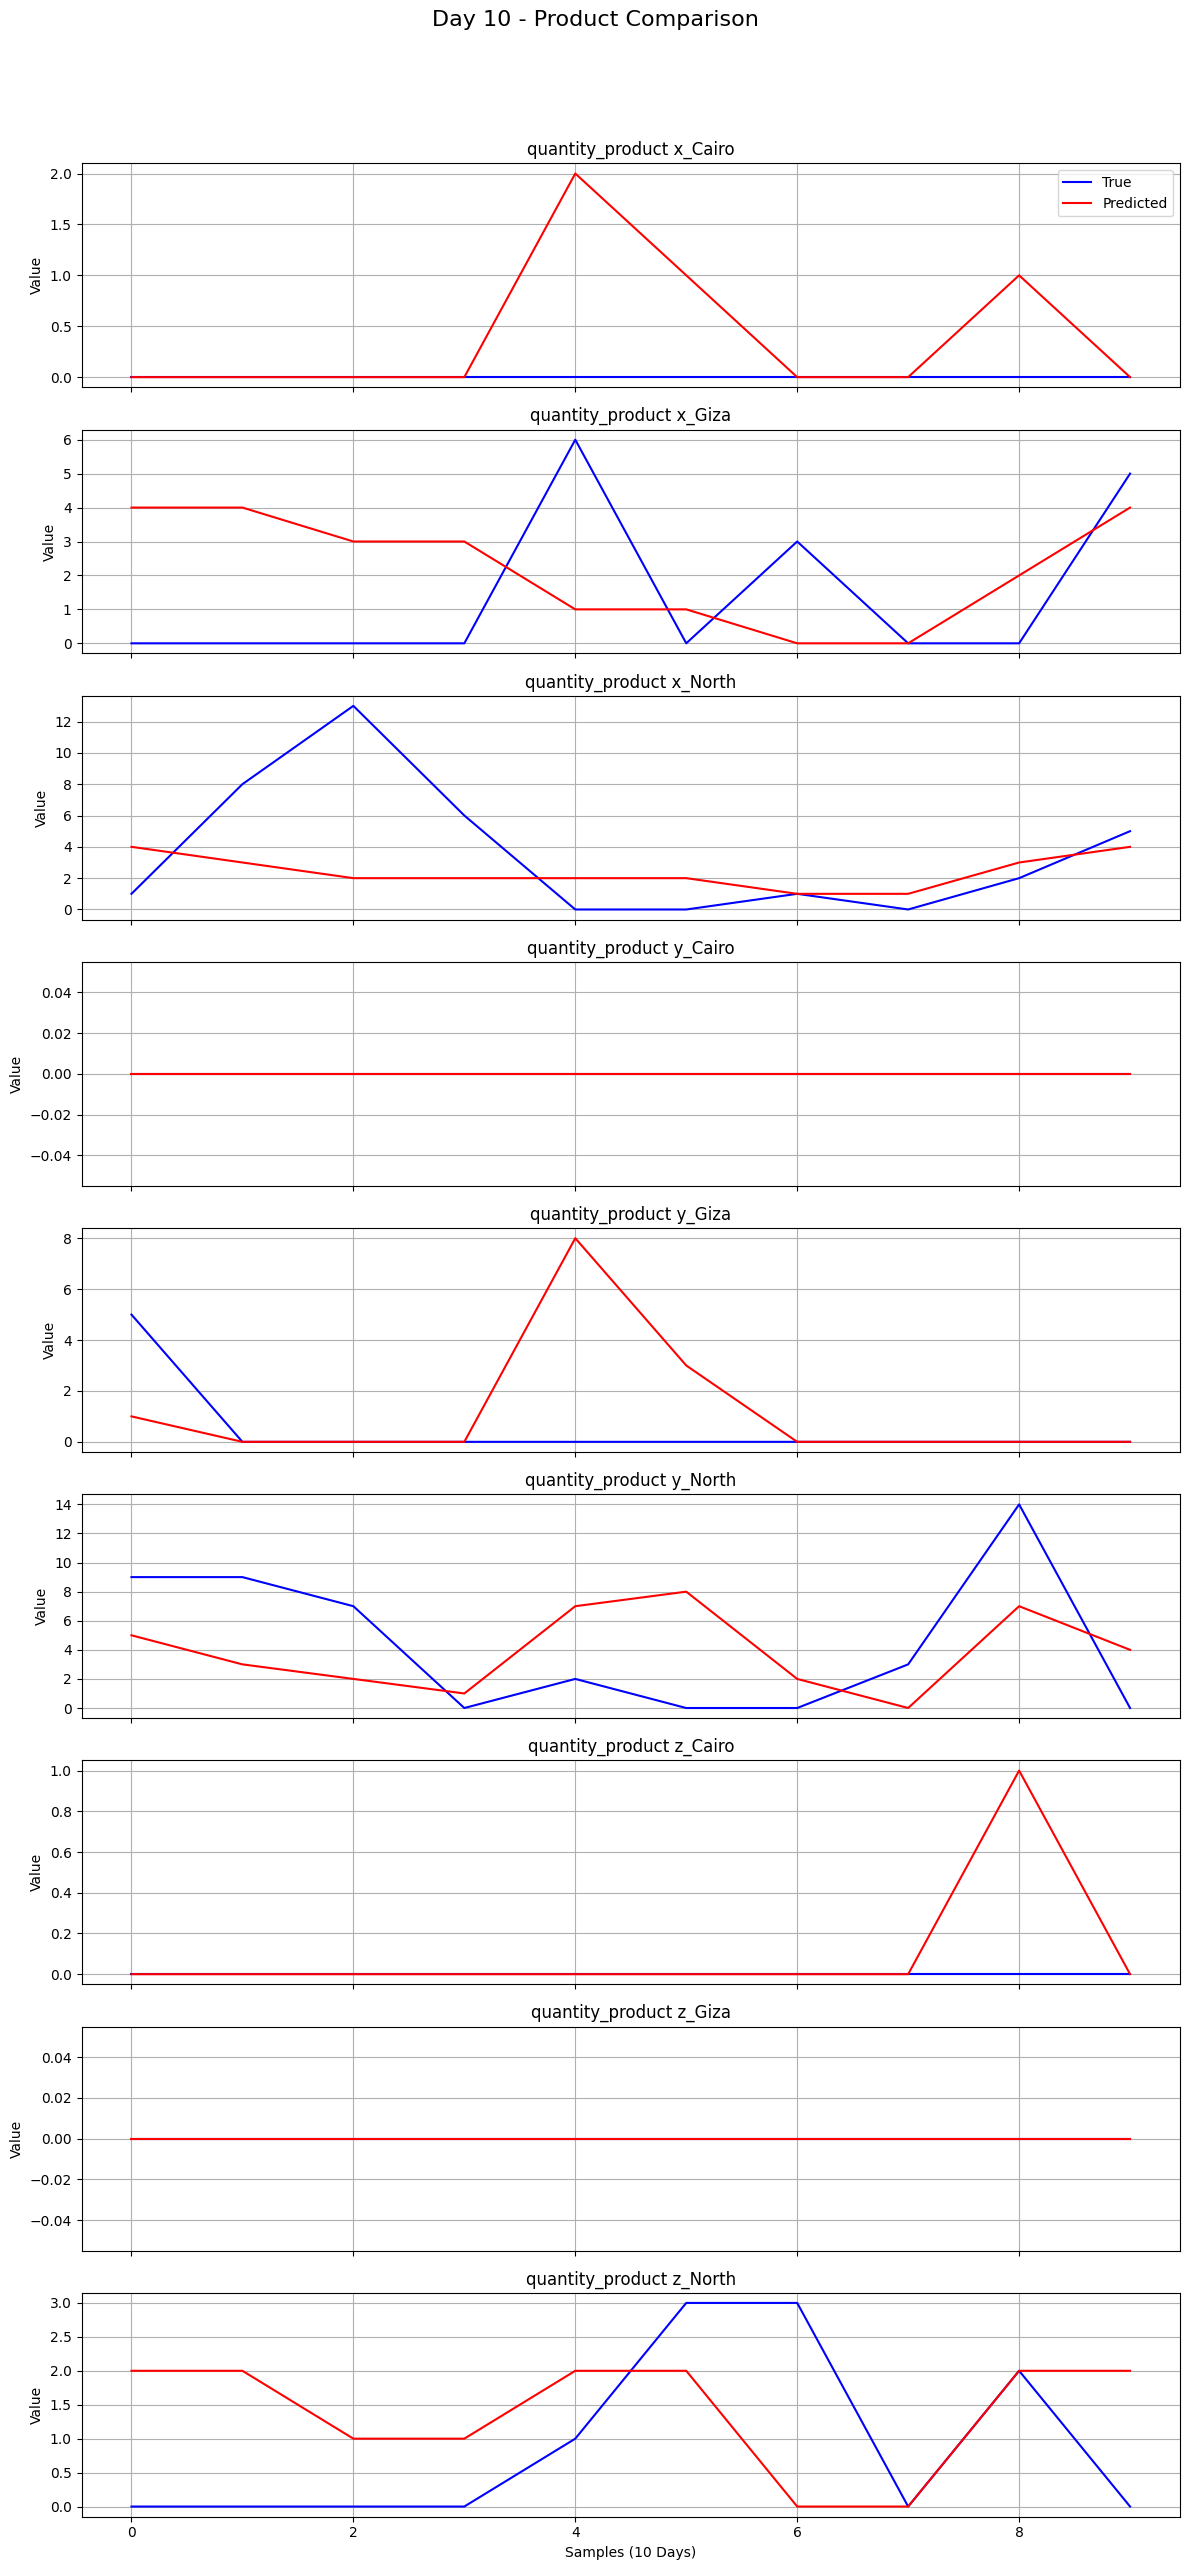

In [253]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

product_names = [
    'quantity_product x_Cairo',
    'quantity_product x_Giza',
    'quantity_product x_North',
    'quantity_product y_Cairo',
    'quantity_product y_Giza',
    'quantity_product y_North',
    'quantity_product z_Cairo',
    'quantity_product z_Giza',
    'quantity_product z_North'
]

# 1. Combine y_test and y_pred for comparison (along the feature axis)
combined = np.concatenate([y_test, y_pred], axis=-1)
print(f"Combined shape: {combined.shape}")

# 2. Compute Root Mean Squared Error (RMSE) for all samples, timesteps, and products
mse = mean_squared_error(
    y_test.reshape(-1, y_test.shape[-1]),
    y_pred.reshape(-1, y_pred.shape[-1]),
    multioutput='uniform_average'
)
print(f"Root Mean Squared Error: {mse**0.5}")

# 3. Compute Mean Absolute Error (MAE) for all samples, timesteps, and products
mae = mean_absolute_error(
    y_test.reshape(-1, y_test.shape[-1]),
    y_pred.reshape(-1, y_pred.shape[-1]),
    multioutput='uniform_average'
)
print(f"Mean Absolute Error: {mae}")

# 4. Visualize comparison by day (all products per day)
samples = y_test.shape[0]  # Number of days
timesteps = y_test.shape[1]
products = y_test.shape[2]

for day in range(timesteps):  # Loop through all days
    print(f"\nVisualizing results for Day {day + 1} of {timesteps}")

    # Create a subplot for all products for the current day
    fig, axes = plt.subplots(nrows=products, ncols=1, figsize=(12, products * 3), sharex=True)
    fig.suptitle(f"Day {day + 1} - Product Comparison", fontsize=16)

    for product_idx, ax in enumerate(axes):  # Loop through all products
        # Plot True values
        ax.plot(range(samples), y_test[:, day, product_idx], label='True', color='blue')

        # Plot Predicted values
        ax.plot(range(samples), y_pred[:, day, product_idx], label='Predicted', color='red')

        # Title and Labels
        ax.set_title(f"{product_names[product_idx]}")
        ax.set_ylabel("Value")
        ax.grid()

    # Common labels
    axes[-1].set_xlabel("Samples (10 Days)")
    axes[0].legend(loc='upper right')

    # Adjust layout and show
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust for title space
    plt.show()


#### Evalution on non-zero metrices

In [254]:
# Check performance on non-zero sales days
#MAE
non_zero_mask = y_test != 0
non_zero_mae = np.mean(np.abs(y_test[non_zero_mask] - y_pred[non_zero_mask]))
print(f"Non-Zero MAE: {non_zero_mae:.2f}")
#RMSE
non_zero_rmse = np.sqrt(np.mean((y_test[non_zero_mask] - y_pred[non_zero_mask]) ** 2))
print(f"Non-Zero RMSE: {non_zero_rmse:.2f}")


Non-Zero MAE: 3.41
Non-Zero RMSE: 4.44


### Interpretation

*    Model has Low MAE and RMSE which less LightGBM
RMSE > MAE                                                            
means high Impact of large errors and small general error across all predictions .

*   Model has Low Non-Zero MAE [3]means good balance with highly skewed data and show a tradeoff between high performence with actual sales events and sales spikes .
* Here i focused in adapting MAE .




# Notes



*   Alot of trials not included since it was't effective in model preformence like adding Attention , BILSTM ,Catboost and more models .
*   Some models can be further used like transformer (in such a case i thought it will be overpowered) .

